In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [10]:
import math

#warps image and also returns M and Minv
def warp(img,optype='warp'):
    
    #src
    src = np.float32(
      [[580,447],
       [705,447],
       [181,655],
       [1081,655]])
    
    #dst
    dst = np.float32(
      [[401,0],
       [897,0],
       [401,720],
       [897,720]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size = (img.shape[1], img.shape[0])
    if(optype=='warp'):
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    
# A function that thresholds the S-channel of HLS
def hls_select_s(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# A function that thresholds the L-channel of HLS
def hls_select_l(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gthresh = 127
    gray = cv2.threshold(gray, gthresh, 255, cv2.THRESH_BINARY)[1]
    #gray = hls_select(img, thresh=(90, 255))
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gthresh = 127
    gray = cv2.threshold(gray, gthresh, 255, cv2.THRESH_BINARY)[1]
    #gray = hls_select(img, thresh=(90, 255))
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255,inp_ksize = 3):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gthresh = 127
    gray = cv2.threshold(gray, gthresh, 255, cv2.THRESH_BINARY)[1]
    #gray = hls_select(img, thresh=(90, 255))
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=inp_ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=inp_ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

#takes a list of chessboard images and return complete set of img/obj points
def calibrate_camera(image_names):
    objpoints=[] #3d
    imgpoints=[] #2d
    
    objpts = np.zeros((6*9,3), np.float32)
    objpts[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 
    
    for img_name in image_names:
        
        
        
        #read and convert to grayscale
        image = mpimg.imread(img_name)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        #get corners
        ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
        
        if(ret == True):
            imgpoints.append(corners)
            objpoints.append(objpts)
            
            image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
            #print("processed:", img_name)
            plt.imshow(image)
    
    return imgpoints, objpoints
            
    

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




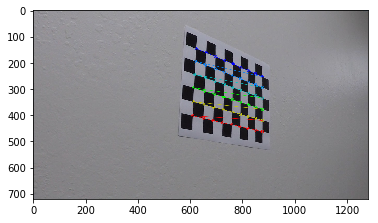

In [11]:
#calibrate the camera
import glob

imgpoints = []
objpoints = []
image_names = glob.glob('camera_cal/calibration*.jpg')
imgpoints, objpoints = calibrate_camera(image_names)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


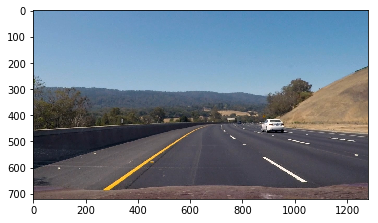

In [31]:
#reading in a test image
img = mpimg.imread('test_images/test3.jpg')

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)

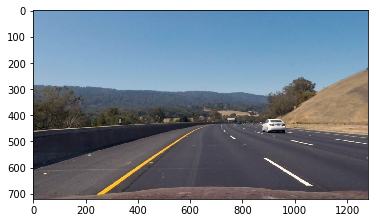

In [32]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]),None,None)

#undistort img
undst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undst)
#cv2.imwrite(r'C:\Users\chinmayd\Desktop\undistorted.png', dst)

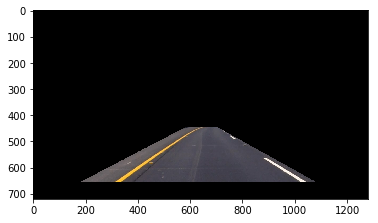

In [33]:
#apply ROI
# This defines a trapezoidal area of interest for 540X960 image
trapezoid = np.array([ [181,655], [580,447], [705,447], [1081,655]], np.int32)
undst = region_of_interest(undst, [trapezoid])
plt.imshow(undst)

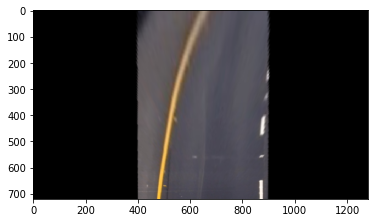

In [34]:
dst, M, Minv = warp(undst)
#blur to remove noise
dst = gaussian_blur(dst, 9)
plt.imshow(dst)

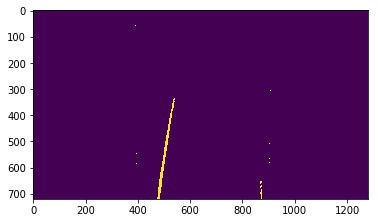

In [35]:
hls_binary_s = hls_select_s(dst, thresh=(150, 255))
#rgb_img = cv2.cvtColor(hls_binary, cv2.COLOR_HLS2RGB)
plt.imshow(hls_binary_s)

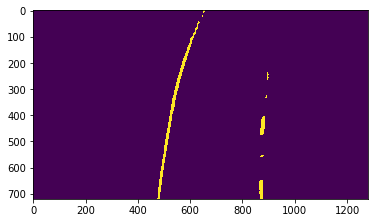

In [36]:
hls_binary_l = hls_select_l(dst, thresh=(145, 255))
#rgb_img = cv2.cvtColor(hls_binary, cv2.COLOR_HLS2RGB)
#hls_binary = np.logical_and(hls_binary_l, hls_binary_s)
plt.imshow(hls_binary_l)

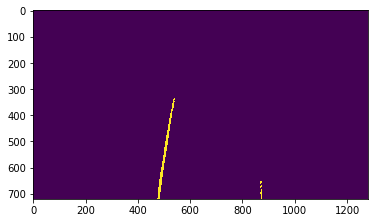

In [37]:
hls_binary = cv2.bitwise_and(hls_binary_l,hls_binary_s)

    
plt.imshow(hls_binary)

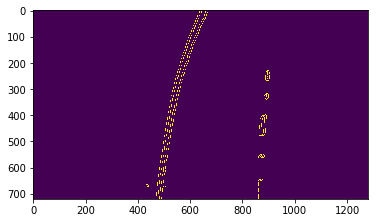

In [38]:
#thresholding and sobel of undistorted image

sobelx_img = abs_sobel_thresh(dst, 'x', 20, 100, 17)

plt.imshow(sobelx_img)

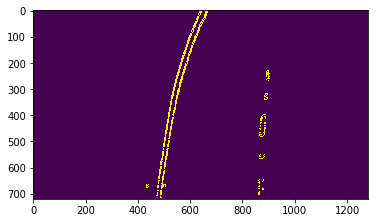

In [39]:
#thresholding and sobel of undistorted image
sobely_img = abs_sobel_thresh(dst, 'y', 10, 100, 17)
plt.imshow(sobely_img)

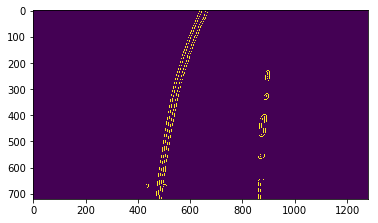

In [41]:
sobelmag_img = mag_thresh(dst, sobel_kernel=17, mag_thresh=(15, 100))
plt.imshow(sobelmag_img)

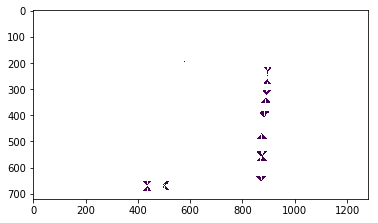

In [42]:
sobelxydir_img = dir_threshold(dst, sobel_kernel=31, thresh=(0.8, 1.4))
plt.imshow(cv2.bitwise_not(sobelxydir_img))

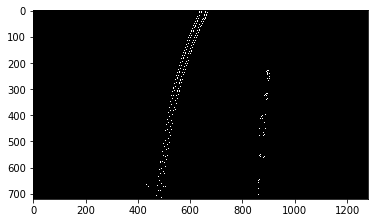

In [43]:
#combined = np.zeros_like(dir_binary)
  #  combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

and_img0 = cv2.bitwise_and(sobely_img, sobelx_img)
ret_img = np.array(and_img0, dtype=np.uint8)
plt.imshow(cv2.cvtColor(ret_img*255, cv2.COLOR_GRAY2RGB))
    

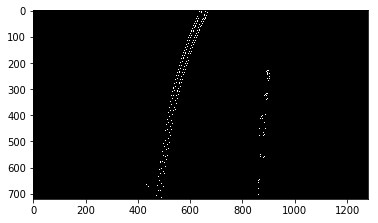

In [44]:
and_img1 = cv2.bitwise_and(sobelmag_img, and_img0)
ret_img = np.array(and_img1, dtype=np.uint8)
plt.imshow(cv2.cvtColor(ret_img*255, cv2.COLOR_GRAY2RGB))
    

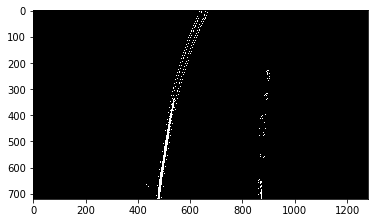

In [45]:
and_img = cv2.bitwise_or(hls_binary, and_img1)


#and_img = np.logical_and(sobelmag_img, sobelx_img)
#hls_dir = np.logical_or(hls_binary, np.logical_not(sobelxydir_img))
#and_img = np.logical_and(and_img,hls_dir)
#plt.imshow(and_img)

ret_img = np.array(and_img, dtype=np.uint8)
plt.imshow(cv2.cvtColor(ret_img*255, cv2.COLOR_GRAY2RGB))
    

484 870


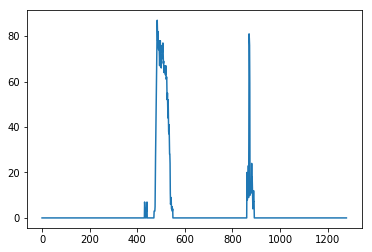

In [46]:

histogram = np.sum(and_img[350:,:], axis=0)
midpoint = np.int(histogram.shape[0]/2)

leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

plt.plot(histogram)

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

#glabal circular buffers to save points from previous frames/detections
history_leftx = collections.deque(maxlen=6)
history_lefty = collections.deque(maxlen=6)
history_rightx = collections.deque(maxlen=10)
history_righty = collections.deque(maxlen=10)


In [7]:

def getCurvature(lefty, leftx, righty, rightx):
    #calculate curvature of lane
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*720*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*720*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad+right_curverad)/2 #use average
    
def process_image(image):
    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[1], image.shape[0]),None,None)

    #undistort img
    undst = cv2.undistort(image, mtx, dist, None, mtx)
    
    #apply ROI
    # This defines a trapezoidal area of interest 
    trapezoid = np.array([ [181,655], [580,447], [705,447], [1081,655]], np.int32)
    undst_roi = region_of_interest(undst, [trapezoid])
    
    
    #change perspective
    dst, M, Minv = warp(undst_roi)
    
    #blur to remove noise
    dst = gaussian_blur(dst, 9)
    
    #hls processing (AND of L and S channels with thrsholding)
    hls_binary_s = hls_select_s(dst, thresh=(150, 255))
    hls_binary_l = hls_select_l(dst, thresh=(145, 255))
    hls_binary = cv2.bitwise_and(hls_binary_l,hls_binary_s) 

    #sobel
    sobelx_img = abs_sobel_thresh(dst, 'x', 20, 100, 17)
    sobely_img = abs_sobel_thresh(dst, 'y', 10, 100, 17)
    sobelmag_img = mag_thresh(dst, sobel_kernel=17, mag_thresh=(15, 100))

    #combine so as to cancel maximum noise
    and_img0 = cv2.bitwise_and(sobely_img, sobelx_img)
    and_img1 = cv2.bitwise_and(sobelmag_img, and_img0)
    and_img = cv2.bitwise_or(hls_binary, and_img1)
    

    #fit peaks
    histogram = np.sum(and_img[350:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    #main polyfit code
    binary_warped = and_img
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Set height of windows
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 19
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    potential_width = rightx_base - leftx_base
    skip_frame = False
    if(potential_width < 450 and potential_width > 260):
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            #draw text with num pixels
            cv2.putText(out_img,str(len(good_left_inds)), (win_xleft_low + 2,win_y_low + 2), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
            cv2.putText(out_img,str(len(good_right_inds)), (win_xright_low + 2,win_y_low + 2), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
            
            # Append these indices to the lists
            # If you found > minpix pixels, recenter next window on their mean position
            print("rightpix:",len(good_right_inds),"leftpix:", len(good_left_inds))
            if len(good_left_inds) > minpix:
                left_lane_inds.append(good_left_inds)
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                #print(len(good_left_inds))
            if len(good_right_inds) > minpix:        
                right_lane_inds.append(good_right_inds)
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        if( len(left_lane_inds) > 0 ):
            left_lane_inds = np.concatenate(left_lane_inds)
        print(type(right_lane_inds), len(left_lane_inds))
        if( len(right_lane_inds) > 0 ):
            right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        print("skip frame...width:", potential_width)
        skip_frame = True

    
    #for further processing, create list of all points including historical frames

    
    
    # Extract left and right line pixel positions
    if(skip_frame == False):
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        if(len(leftx) > 0):
            history_leftx.append(leftx)
        if(len(lefty) > 0):
            history_lefty.append(lefty)
        if(len(rightx) > 0):
            history_rightx.append(rightx)
        if(len(righty) > 0):
            history_righty.append(righty)

    
    # Merge points from previous frames from circular buffers
    oneshot = True
    for left_x, left_y, right_x, right_y in zip(history_leftx, history_lefty, history_rightx , history_righty):
        if (oneshot == True):
            oneshot = False
            leftx =  left_x
            lefty = left_y
            rightx = right_x
            righty = right_y
        else:
            leftx =  np.concatenate((leftx , left_x))
            lefty = np.concatenate((lefty , left_y))
            rightx = np.concatenate((rightx , right_x))
            righty = np.concatenate((righty , right_y))
 
            
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #get curvature
    m = getCurvature(ploty, left_fitx, ploty, right_fitx )
    
    #get x intercepts for y=720 and calculate center offset
    x_l = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    x_r = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    pos = (720 - (x_l+x_r)/2)*(3.7/700) #in meter world
    print("Offset from center ", pos)
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(out_img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    cv2.putText(result, "Curvature: " + str(m), (70, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(result, "CenterOffset: " + str(pos), (130,130), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
                

    #plt.imshow(result)
    return np.concatenate((result, out_img), axis=1)
    

In [8]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
process_image.lines_left = []
process_image.lines_right = []
clip1 = VideoFileClip("proj.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

rightpix: 604 leftpix: 1727
rightpix: 392 leftpix: 1969
rightpix: 370 leftpix: 2195
rightpix: 370 leftpix: 1431
rightpix: 417 leftpix: 288
rightpix: 684 leftpix: 69
rightpix: 375 leftpix: 96
rightpix: 4142 leftpix: 123
rightpix: 2134 leftpix: 240
<class 'list'> 8138
951.409177806 m 346.737912345 m
Offset from center  0.301047381874
[MoviePy] >>>> Building video output_images/proj_harder_challenge.mp4
[MoviePy] Writing video output_images/proj_harder_challenge.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

rightpix: 604 leftpix: 1727
rightpix: 392 leftpix: 1969
rightpix: 370 leftpix: 2195
rightpix: 370 leftpix: 1431
rightpix: 417 leftpix: 288
rightpix: 684 leftpix: 69
rightpix: 375 leftpix: 96
rightpix: 4142 leftpix: 123
rightpix: 2134 leftpix: 240
<class 'list'> 8138
951.409177806 m 346.737912345 m
Offset from center  0.301047381874


  0%|          | 1/1200 [00:00<07:49,  2.55it/s]

rightpix: 521 leftpix: 1738
rightpix: 442 leftpix: 1988
rightpix: 378 leftpix: 2248
rightpix: 394 leftpix: 1586
rightpix: 474 leftpix: 250
rightpix: 839 leftpix: 71
rightpix: 319 leftpix: 86
rightpix: 2480 leftpix: 126
rightpix: 3483 leftpix: 111
<class 'list'> 8204
1003.18897188 m 373.26983827 m
Offset from center  0.297367829326


  0%|          | 2/1200 [00:00<08:18,  2.41it/s]

rightpix: 518 leftpix: 1747
rightpix: 444 leftpix: 2011
rightpix: 365 leftpix: 2255
rightpix: 388 leftpix: 1445
rightpix: 441 leftpix: 236
rightpix: 927 leftpix: 73
rightpix: 518 leftpix: 92
rightpix: 1764 leftpix: 127
rightpix: 4743 leftpix: 122
<class 'list'> 8108
1030.17882022 m 410.527301511 m
Offset from center  0.296556875349


  0%|          | 3/1200 [00:01<08:19,  2.40it/s]

rightpix: 609 leftpix: 1761
rightpix: 485 leftpix: 2002
rightpix: 402 leftpix: 2257
rightpix: 392 leftpix: 1311
rightpix: 451 leftpix: 147
rightpix: 924 leftpix: 73
rightpix: 538 leftpix: 96
rightpix: 1922 leftpix: 120
rightpix: 5053 leftpix: 123
<class 'list'> 7890
1044.54591782 m 431.822839325 m
Offset from center  0.295165013693


  0%|          | 4/1200 [00:01<08:14,  2.42it/s]

rightpix: 518 leftpix: 1833
rightpix: 464 leftpix: 2001
rightpix: 390 leftpix: 2157
rightpix: 393 leftpix: 1244
rightpix: 449 leftpix: 144
rightpix: 864 leftpix: 69
rightpix: 432 leftpix: 96
rightpix: 2295 leftpix: 129
rightpix: 5182 leftpix: 120
<class 'list'> 7793
1049.49808589 m 433.686685449 m
Offset from center  0.292189908089


  0%|          | 5/1200 [00:02<08:11,  2.43it/s]

rightpix: 451 leftpix: 1808
rightpix: 463 leftpix: 2031
rightpix: 380 leftpix: 1985
rightpix: 343 leftpix: 1235
rightpix: 463 leftpix: 143
rightpix: 786 leftpix: 56
rightpix: 401 leftpix: 90
rightpix: 2500 leftpix: 131
rightpix: 4985 leftpix: 122
<class 'list'> 7601
1084.49814496 m 433.686685449 m
Offset from center  0.29588371497


  0%|          | 6/1200 [00:02<08:05,  2.46it/s]

rightpix: 557 leftpix: 1803
rightpix: 420 leftpix: 2063
rightpix: 363 leftpix: 1859
rightpix: 328 leftpix: 1076
rightpix: 588 leftpix: 158
rightpix: 594 leftpix: 56
rightpix: 261 leftpix: 81
rightpix: 3741 leftpix: 119
rightpix: 3610 leftpix: 103
<class 'list'> 7318
1140.48438039 m 433.686685449 m
Offset from center  0.299375839577


  1%|          | 7/1200 [00:02<07:59,  2.49it/s]

rightpix: 655 leftpix: 1788
rightpix: 326 leftpix: 2110
rightpix: 332 leftpix: 1849
rightpix: 272 leftpix: 797
rightpix: 1020 leftpix: 111
rightpix: 468 leftpix: 61
rightpix: 0 leftpix: 82
rightpix: 562 leftpix: 109
rightpix: 2652 leftpix: 257
<class 'list'> 7164
924.56144918 m 433.686685449 m
Offset from center  0.297982386548


  1%|          | 8/1200 [00:03<07:59,  2.48it/s]

rightpix: 544 leftpix: 1780
rightpix: 357 leftpix: 2075
rightpix: 297 leftpix: 1832
rightpix: 300 leftpix: 541
rightpix: 807 leftpix: 61
rightpix: 275 leftpix: 50
rightpix: 2559 leftpix: 103
rightpix: 3462 leftpix: 147
rightpix: 1309 leftpix: 452
<class 'list'> 7041
771.248287954 m 433.686685449 m
Offset from center  0.295804907911


  1%|          | 9/1200 [00:03<07:57,  2.50it/s]

rightpix: 608 leftpix: 1796
rightpix: 349 leftpix: 2004
rightpix: 323 leftpix: 1747
rightpix: 264 leftpix: 367
rightpix: 659 leftpix: 69
rightpix: 302 leftpix: 60
rightpix: 2903 leftpix: 116
rightpix: 2902 leftpix: 240
rightpix: 707 leftpix: 416
<class 'list'> 6815
686.142897898 m 429.193730965 m
Offset from center  0.283956545235


  1%|          | 10/1200 [00:04<07:55,  2.50it/s]

skip frame...width: 452
686.142897898 m 429.193730965 m
Offset from center  0.283956545235


  1%|          | 11/1200 [00:04<07:18,  2.71it/s]

rightpix: 704 leftpix: 1768
rightpix: 334 leftpix: 2085
rightpix: 331 leftpix: 1539
rightpix: 244 leftpix: 340
rightpix: 576 leftpix: 44
rightpix: 509 leftpix: 60
rightpix: 3474 leftpix: 108
rightpix: 3007 leftpix: 156
rightpix: 1140 leftpix: 448
<class 'list'> 6548
654.596147808 m 425.556113023 m
Offset from center  0.27759149124


  1%|          | 12/1200 [00:04<07:14,  2.73it/s]

skip frame...width: 463
654.596147808 m 425.556113023 m
Offset from center  0.27759149124


  1%|          | 13/1200 [00:05<06:46,  2.92it/s]

skip frame...width: 454
654.596147808 m 425.556113023 m
Offset from center  0.27759149124


  1%|          | 14/1200 [00:05<06:15,  3.16it/s]

skip frame...width: 454
654.596147808 m 425.556113023 m
Offset from center  0.27759149124


  1%|▏         | 15/1200 [00:05<05:58,  3.31it/s]

rightpix: 629 leftpix: 1747
rightpix: 330 leftpix: 1786
rightpix: 270 leftpix: 1259
rightpix: 640 leftpix: 206
rightpix: 1275 leftpix: 30
rightpix: 30 leftpix: 56
rightpix: 87 leftpix: 86
rightpix: 101 leftpix: 342
rightpix: 96 leftpix: 297
<class 'list'> 5809
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  1%|▏         | 16/1200 [00:05<06:22,  3.10it/s]

skip frame...width: 452
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  1%|▏         | 17/1200 [00:06<06:10,  3.19it/s]

skip frame...width: 453
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 18/1200 [00:06<05:54,  3.33it/s]

skip frame...width: 452
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 19/1200 [00:06<05:40,  3.46it/s]

skip frame...width: 460
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 20/1200 [00:07<05:46,  3.41it/s]

skip frame...width: 461
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 21/1200 [00:07<05:40,  3.46it/s]

skip frame...width: 458
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 22/1200 [00:07<05:53,  3.33it/s]

skip frame...width: 466
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 23/1200 [00:07<06:03,  3.24it/s]

skip frame...width: 460
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 24/1200 [00:08<06:34,  2.98it/s]

skip frame...width: 462
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 25/1200 [00:08<06:05,  3.22it/s]

skip frame...width: 470
630.662592382 m 519.738904657 m
Offset from center  0.299104259261


  2%|▏         | 26/1200 [00:08<05:41,  3.44it/s]

rightpix: 620 leftpix: 1502
rightpix: 287 leftpix: 1398
rightpix: 580 leftpix: 255
rightpix: 1296 leftpix: 14
rightpix: 25 leftpix: 35
rightpix: 60 leftpix: 52
rightpix: 84 leftpix: 147
rightpix: 95 leftpix: 452
rightpix: 334 leftpix: 138
<class 'list'> 3979
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  2%|▏         | 27/1200 [00:09<05:54,  3.31it/s]

skip frame...width: 466
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  2%|▏         | 28/1200 [00:09<05:38,  3.46it/s]

skip frame...width: 465
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  2%|▏         | 29/1200 [00:09<05:25,  3.60it/s]

skip frame...width: 465
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  2%|▎         | 30/1200 [00:09<05:17,  3.69it/s]

skip frame...width: 465
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 31/1200 [00:10<05:08,  3.79it/s]

skip frame...width: 465
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 32/1200 [00:10<05:00,  3.89it/s]

skip frame...width: 464
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 33/1200 [00:10<04:55,  3.95it/s]

skip frame...width: 468
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 34/1200 [00:10<04:51,  3.99it/s]

skip frame...width: 474
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 35/1200 [00:11<04:51,  4.00it/s]

skip frame...width: 488
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 36/1200 [00:11<04:52,  3.98it/s]

skip frame...width: 489
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 37/1200 [00:11<04:50,  4.00it/s]

skip frame...width: 464
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 38/1200 [00:11<04:49,  4.01it/s]

skip frame...width: 461
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 39/1200 [00:12<04:48,  4.03it/s]

skip frame...width: 457
651.303259143 m 519.459509661 m
Offset from center  0.318695287981


  3%|▎         | 40/1200 [00:12<04:46,  4.05it/s]

rightpix: 536 leftpix: 964
rightpix: 321 leftpix: 1322
rightpix: 746 leftpix: 809
rightpix: 939 leftpix: 18
rightpix: 3831 leftpix: 36
rightpix: 1121 leftpix: 195
rightpix: 1103 leftpix: 20
rightpix: 861 leftpix: 311
rightpix: 432 leftpix: 345
<class 'list'> 4002
630.879078189 m 510.705201224 m
Offset from center  0.337767079526


  3%|▎         | 41/1200 [00:12<05:11,  3.72it/s]

rightpix: 520 leftpix: 948
rightpix: 352 leftpix: 1419
rightpix: 1023 leftpix: 744
rightpix: 1548 leftpix: 18
rightpix: 5045 leftpix: 34
rightpix: 1170 leftpix: 211
rightpix: 826 leftpix: 0
rightpix: 752 leftpix: 367
rightpix: 421 leftpix: 284
<class 'list'> 4007
596.977385868 m 418.476072857 m
Offset from center  0.349412899492


  4%|▎         | 42/1200 [00:13<05:36,  3.44it/s]

rightpix: 450 leftpix: 822
rightpix: 511 leftpix: 1502
rightpix: 1077 leftpix: 653
rightpix: 2298 leftpix: 17
rightpix: 4536 leftpix: 33
rightpix: 1163 leftpix: 237
rightpix: 778 leftpix: 0
rightpix: 761 leftpix: 343
rightpix: 447 leftpix: 291
<class 'list'> 3881
565.556262328 m 516.941162543 m
Offset from center  0.372882966429


  4%|▎         | 43/1200 [00:13<06:07,  3.14it/s]

rightpix: 453 leftpix: 779
rightpix: 494 leftpix: 1624
rightpix: 1040 leftpix: 634
rightpix: 3219 leftpix: 17
rightpix: 3964 leftpix: 33
rightpix: 1169 leftpix: 205
rightpix: 939 leftpix: 0
rightpix: 1108 leftpix: 386
rightpix: 471 leftpix: 285
<class 'list'> 3946
523.787176253 m 607.706934309 m
Offset from center  0.389581529262


  4%|▎         | 44/1200 [00:13<06:23,  3.01it/s]

rightpix: 381 leftpix: 643
rightpix: 573 leftpix: 1777
rightpix: 1000 leftpix: 527
rightpix: 4196 leftpix: 17
rightpix: 3393 leftpix: 36
rightpix: 1096 leftpix: 237
rightpix: 947 leftpix: 0
rightpix: 938 leftpix: 444
rightpix: 466 leftpix: 226
<class 'list'> 3890
523.374003285 m 836.332078101 m
Offset from center  0.407813330805


  4%|▍         | 45/1200 [00:14<06:23,  3.01it/s]

rightpix: 364 leftpix: 602
rightpix: 620 leftpix: 1866
rightpix: 1001 leftpix: 461
rightpix: 4891 leftpix: 17
rightpix: 2788 leftpix: 38
rightpix: 1109 leftpix: 217
rightpix: 1008 leftpix: 0
rightpix: 1122 leftpix: 367
rightpix: 563 leftpix: 227
<class 'list'> 3778
491.169604702 m 2057.42202882 m
Offset from center  0.425565891413


  4%|▍         | 46/1200 [00:14<06:24,  3.00it/s]

rightpix: 307 leftpix: 739
rightpix: 662 leftpix: 1875
rightpix: 967 leftpix: 386
rightpix: 5317 leftpix: 17
rightpix: 2389 leftpix: 39
rightpix: 1066 leftpix: 215
rightpix: 1161 leftpix: 6
rightpix: 934 leftpix: 336
rightpix: 574 leftpix: 211
<class 'list'> 3801
472.000601557 m 3580.72776963 m
Offset from center  0.439507184016


  4%|▍         | 47/1200 [00:14<06:25,  2.99it/s]

rightpix: 301 leftpix: 845
rightpix: 740 leftpix: 1867
rightpix: 932 leftpix: 333
rightpix: 5826 leftpix: 18
rightpix: 2302 leftpix: 33
rightpix: 1063 leftpix: 194
rightpix: 1140 leftpix: 20
rightpix: 836 leftpix: 236
rightpix: 358 leftpix: 219
<class 'list'> 3747
453.573649254 m 1131.55386958 m
Offset from center  0.457021237423


  4%|▍         | 48/1200 [00:15<06:30,  2.95it/s]

rightpix: 352 leftpix: 904
rightpix: 774 leftpix: 1780
rightpix: 948 leftpix: 253
rightpix: 6113 leftpix: 18
rightpix: 1990 leftpix: 37
rightpix: 1012 leftpix: 218
rightpix: 1191 leftpix: 29
rightpix: 719 leftpix: 231
rightpix: 147 leftpix: 162
<class 'list'> 3614
421.824143559 m 1201.05132256 m
Offset from center  0.452126285646


  4%|▍         | 49/1200 [00:15<06:37,  2.89it/s]

rightpix: 465 leftpix: 994
rightpix: 783 leftpix: 1800
rightpix: 1151 leftpix: 228
rightpix: 6085 leftpix: 18
rightpix: 1801 leftpix: 32
rightpix: 1013 leftpix: 184
rightpix: 1210 leftpix: 55
rightpix: 440 leftpix: 226
rightpix: 133 leftpix: 213
<class 'list'> 3732
408.617097346 m 1138.31502833 m
Offset from center  0.448036604207


  4%|▍         | 50/1200 [00:15<06:38,  2.88it/s]

rightpix: 530 leftpix: 1087
rightpix: 772 leftpix: 1708
rightpix: 1229 leftpix: 209
rightpix: 5930 leftpix: 18
rightpix: 1618 leftpix: 31
rightpix: 1113 leftpix: 151
rightpix: 1058 leftpix: 117
rightpix: 311 leftpix: 176
rightpix: 274 leftpix: 271
<class 'list'> 3750
404.80414013 m 986.059905818 m
Offset from center  0.444817994948


  4%|▍         | 51/1200 [00:16<06:43,  2.85it/s]

rightpix: 477 leftpix: 1216
rightpix: 848 leftpix: 1630
rightpix: 1313 leftpix: 228
rightpix: 5500 leftpix: 18
rightpix: 1481 leftpix: 43
rightpix: 1098 leftpix: 189
rightpix: 674 leftpix: 113
rightpix: 291 leftpix: 194
rightpix: 238 leftpix: 201
<class 'list'> 3814
400.984798762 m 875.067454406 m
Offset from center  0.438227232036


  4%|▍         | 52/1200 [00:16<06:45,  2.83it/s]

rightpix: 524 leftpix: 1251
rightpix: 1077 leftpix: 1586
rightpix: 1493 leftpix: 232
rightpix: 5098 leftpix: 18
rightpix: 1535 leftpix: 36
rightpix: 1127 leftpix: 209
rightpix: 602 leftpix: 145
rightpix: 330 leftpix: 221
rightpix: 261 leftpix: 200
<class 'list'> 3880
391.326364136 m 854.954109385 m
Offset from center  0.433319642855


  4%|▍         | 53/1200 [00:16<06:46,  2.82it/s]

rightpix: 509 leftpix: 1356
rightpix: 1223 leftpix: 1510
rightpix: 1835 leftpix: 202
rightpix: 4314 leftpix: 15
rightpix: 1440 leftpix: 32
rightpix: 722 leftpix: 230
rightpix: 617 leftpix: 128
rightpix: 185 leftpix: 232
rightpix: 362 leftpix: 206
<class 'list'> 3896
382.238138795 m 888.533571138 m
Offset from center  0.43112111866


  4%|▍         | 54/1200 [00:17<06:44,  2.84it/s]

rightpix: 529 leftpix: 1380
rightpix: 1170 leftpix: 1537
rightpix: 2438 leftpix: 165
rightpix: 3766 leftpix: 18
rightpix: 1450 leftpix: 32
rightpix: 395 leftpix: 259
rightpix: 650 leftpix: 119
rightpix: 139 leftpix: 258
rightpix: 386 leftpix: 154
<class 'list'> 3904
392.525765885 m 1064.40543582 m
Offset from center  0.438746937661


  5%|▍         | 55/1200 [00:17<06:42,  2.85it/s]

rightpix: 494 leftpix: 1427
rightpix: 1200 leftpix: 1541
rightpix: 2911 leftpix: 126
rightpix: 3321 leftpix: 22
rightpix: 1226 leftpix: 34
rightpix: 436 leftpix: 264
rightpix: 572 leftpix: 95
rightpix: 227 leftpix: 201
rightpix: 367 leftpix: 160
<class 'list'> 3870
394.897241797 m 1563.71336588 m
Offset from center  0.44219285265


  5%|▍         | 56/1200 [00:18<06:42,  2.84it/s]

rightpix: 267 leftpix: 1511
rightpix: 932 leftpix: 1501
rightpix: 3204 leftpix: 116
rightpix: 2204 leftpix: 21
rightpix: 746 leftpix: 31
rightpix: 521 leftpix: 333
rightpix: 525 leftpix: 125
rightpix: 251 leftpix: 174
rightpix: 370 leftpix: 179
<class 'list'> 3991
410.562385717 m 4657.56646642 m
Offset from center  0.446634793048


  5%|▍         | 57/1200 [00:18<06:50,  2.78it/s]

rightpix: 294 leftpix: 1558
rightpix: 1039 leftpix: 1458
rightpix: 3263 leftpix: 98
rightpix: 1743 leftpix: 18
rightpix: 504 leftpix: 38
rightpix: 560 leftpix: 372
rightpix: 322 leftpix: 152
rightpix: 314 leftpix: 205
rightpix: 399 leftpix: 194
<class 'list'> 4075
432.36287918 m 3185.70671459 m
Offset from center  0.452213327653


  5%|▍         | 58/1200 [00:18<06:48,  2.80it/s]

rightpix: 277 leftpix: 1549
rightpix: 947 leftpix: 1373
rightpix: 3113 leftpix: 85
rightpix: 1405 leftpix: 18
rightpix: 364 leftpix: 37
rightpix: 467 leftpix: 481
rightpix: 395 leftpix: 146
rightpix: 364 leftpix: 284
rightpix: 449 leftpix: 175
<class 'list'> 4130
444.370459362 m 1403.55399951 m
Offset from center  0.454631442124


  5%|▍         | 59/1200 [00:19<06:50,  2.78it/s]

rightpix: 362 leftpix: 1539
rightpix: 809 leftpix: 1331
rightpix: 3046 leftpix: 74
rightpix: 995 leftpix: 15
rightpix: 235 leftpix: 34
rightpix: 546 leftpix: 468
rightpix: 447 leftpix: 184
rightpix: 380 leftpix: 166
rightpix: 356 leftpix: 172
<class 'list'> 3968
476.515934118 m 890.588891827 m
Offset from center  0.456244768138


  5%|▌         | 60/1200 [00:19<06:45,  2.81it/s]

rightpix: 409 leftpix: 1466
rightpix: 757 leftpix: 1208
rightpix: 2145 leftpix: 57
rightpix: 584 leftpix: 21
rightpix: 224 leftpix: 31
rightpix: 666 leftpix: 383
rightpix: 779 leftpix: 264
rightpix: 412 leftpix: 189
rightpix: 308 leftpix: 153
<class 'list'> 3772
467.756680669 m 790.851179617 m
Offset from center  0.443192132007


  5%|▌         | 61/1200 [00:19<06:43,  2.83it/s]

rightpix: 374 leftpix: 1529
rightpix: 827 leftpix: 1139
rightpix: 1984 leftpix: 46
rightpix: 319 leftpix: 22
rightpix: 178 leftpix: 29
rightpix: 717 leftpix: 302
rightpix: 747 leftpix: 334
rightpix: 378 leftpix: 122
rightpix: 272 leftpix: 120
<class 'list'> 3643
461.284226181 m 715.416527568 m
Offset from center  0.441400626228


  5%|▌         | 62/1200 [00:20<06:44,  2.81it/s]

rightpix: 373 leftpix: 1534
rightpix: 751 leftpix: 1142
rightpix: 1867 leftpix: 31
rightpix: 223 leftpix: 22
rightpix: 147 leftpix: 37
rightpix: 682 leftpix: 262
rightpix: 759 leftpix: 395
rightpix: 236 leftpix: 139
rightpix: 254 leftpix: 139
<class 'list'> 3701
445.230942183 m 643.103594997 m
Offset from center  0.440995429443


  5%|▌         | 63/1200 [00:20<06:40,  2.84it/s]

rightpix: 232 leftpix: 1485
rightpix: 681 leftpix: 1212
rightpix: 1721 leftpix: 29
rightpix: 152 leftpix: 18
rightpix: 250 leftpix: 31
rightpix: 687 leftpix: 257
rightpix: 854 leftpix: 310
rightpix: 273 leftpix: 170
rightpix: 293 leftpix: 378
<class 'list'> 3872
438.025532132 m 614.971768688 m
Offset from center  0.436185758772


  5%|▌         | 64/1200 [00:20<06:36,  2.86it/s]

rightpix: 367 leftpix: 1417
rightpix: 1034 leftpix: 1261
rightpix: 1304 leftpix: 31
rightpix: 79 leftpix: 17
rightpix: 283 leftpix: 44
rightpix: 1072 leftpix: 256
rightpix: 498 leftpix: 268
rightpix: 277 leftpix: 189
rightpix: 268 leftpix: 336
<class 'list'> 3802
441.168893132 m 623.176432488 m
Offset from center  0.427911237275


  5%|▌         | 65/1200 [00:21<06:38,  2.85it/s]

skip frame...width: 488
441.168893132 m 623.176432488 m
Offset from center  0.427911237275


  6%|▌         | 66/1200 [00:21<06:12,  3.04it/s]

skip frame...width: 490
441.168893132 m 623.176432488 m
Offset from center  0.427911237275


  6%|▌         | 67/1200 [00:21<05:51,  3.22it/s]

rightpix: 384 leftpix: 1422
rightpix: 1750 leftpix: 1231
rightpix: 290 leftpix: 19
rightpix: 50 leftpix: 14
rightpix: 838 leftpix: 53
rightpix: 925 leftpix: 287
rightpix: 0 leftpix: 207
rightpix: 0 leftpix: 460
rightpix: 0 leftpix: 118
<class 'list'> 3778
471.040301414 m 676.515252828 m
Offset from center  0.426390314695


  6%|▌         | 68/1200 [00:22<06:02,  3.12it/s]

skip frame...width: 489
471.040301414 m 676.515252828 m
Offset from center  0.426390314695


  6%|▌         | 69/1200 [00:22<05:44,  3.28it/s]

skip frame...width: 489
471.040301414 m 676.515252828 m
Offset from center  0.426390314695


  6%|▌         | 70/1200 [00:22<05:30,  3.42it/s]

rightpix: 467 leftpix: 1416
rightpix: 1441 leftpix: 1049
rightpix: 36 leftpix: 18
rightpix: 304 leftpix: 17
rightpix: 488 leftpix: 25
rightpix: 218 leftpix: 43
rightpix: 52 leftpix: 103
rightpix: 401 leftpix: 247
rightpix: 489 leftpix: 102
<class 'list'> 2985
462.048856539 m 711.024197031 m
Offset from center  0.429535070342


  6%|▌         | 71/1200 [00:22<05:47,  3.25it/s]

rightpix: 500 leftpix: 1391
rightpix: 1335 leftpix: 1024
rightpix: 38 leftpix: 38
rightpix: 389 leftpix: 17
rightpix: 315 leftpix: 26
rightpix: 83 leftpix: 51
rightpix: 129 leftpix: 92
rightpix: 405 leftpix: 137
rightpix: 479 leftpix: 92
<class 'list'> 2851
447.012565269 m 869.357512072 m
Offset from center  0.412344157502


  6%|▌         | 72/1200 [00:23<06:07,  3.07it/s]

skip frame...width: 490
447.012565269 m 869.357512072 m
Offset from center  0.412344157502


  6%|▌         | 73/1200 [00:23<05:52,  3.20it/s]

skip frame...width: 490
447.012565269 m 869.357512072 m
Offset from center  0.412344157502


  6%|▌         | 74/1200 [00:23<05:36,  3.34it/s]

skip frame...width: 490
447.012565269 m 869.357512072 m
Offset from center  0.412344157502


  6%|▋         | 75/1200 [00:24<05:22,  3.48it/s]

rightpix: 644 leftpix: 1015
rightpix: 805 leftpix: 913
rightpix: 382 leftpix: 24
rightpix: 327 leftpix: 18
rightpix: 281 leftpix: 36
rightpix: 135 leftpix: 54
rightpix: 1020 leftpix: 76
rightpix: 60 leftpix: 114
rightpix: 169 leftpix: 111
<class 'list'> 2343
449.930110241 m 1348.60590119 m
Offset from center  0.395276939273


  6%|▋         | 76/1200 [00:24<05:37,  3.33it/s]

rightpix: 610 leftpix: 1075
rightpix: 750 leftpix: 882
rightpix: 255 leftpix: 24
rightpix: 342 leftpix: 18
rightpix: 255 leftpix: 45
rightpix: 182 leftpix: 55
rightpix: 1595 leftpix: 80
rightpix: 123 leftpix: 98
rightpix: 923 leftpix: 108
<class 'list'> 2367
453.686604234 m 1722.11344211 m
Offset from center  0.392501296115


  6%|▋         | 77/1200 [00:24<05:54,  3.16it/s]

rightpix: 621 leftpix: 1015
rightpix: 811 leftpix: 836
rightpix: 212 leftpix: 32
rightpix: 344 leftpix: 21
rightpix: 170 leftpix: 41
rightpix: 118 leftpix: 45
rightpix: 1206 leftpix: 86
rightpix: 139 leftpix: 106
rightpix: 662 leftpix: 115
<class 'list'> 2297
452.684673074 m 750.903268116 m
Offset from center  0.409453927116


  6%|▋         | 78/1200 [00:25<06:09,  3.03it/s]

rightpix: 667 leftpix: 1002
rightpix: 695 leftpix: 809
rightpix: 216 leftpix: 26
rightpix: 379 leftpix: 17
rightpix: 109 leftpix: 38
rightpix: 197 leftpix: 42
rightpix: 1117 leftpix: 68
rightpix: 156 leftpix: 97
rightpix: 702 leftpix: 103
<class 'list'> 2185
347.366410242 m 539.515588895 m
Offset from center  0.401594848551


  7%|▋         | 79/1200 [00:25<06:20,  2.95it/s]

rightpix: 645 leftpix: 995
rightpix: 668 leftpix: 789
rightpix: 229 leftpix: 18
rightpix: 360 leftpix: 15
rightpix: 123 leftpix: 41
rightpix: 231 leftpix: 40
rightpix: 911 leftpix: 76
rightpix: 134 leftpix: 110
rightpix: 175 leftpix: 103
<class 'list'> 2154
385.993029688 m 727.447828235 m
Offset from center  0.394493364204


  7%|▋         | 80/1200 [00:25<06:49,  2.73it/s]

rightpix: 284 leftpix: 1067
rightpix: 740 leftpix: 748
rightpix: 248 leftpix: 16
rightpix: 472 leftpix: 15
rightpix: 97 leftpix: 56
rightpix: 1236 leftpix: 46
rightpix: 780 leftpix: 82
rightpix: 256 leftpix: 99
rightpix: 210 leftpix: 101
<class 'list'> 2199
459.166863514 m 918.570238911 m
Offset from center  0.398730514655


  7%|▋         | 81/1200 [00:26<06:55,  2.69it/s]

skip frame...width: 489
459.166863514 m 918.570238911 m
Offset from center  0.398730514655


  7%|▋         | 82/1200 [00:26<06:35,  2.83it/s]

skip frame...width: 489
459.166863514 m 918.570238911 m
Offset from center  0.398730514655


  7%|▋         | 83/1200 [00:26<06:12,  3.00it/s]

rightpix: 649 leftpix: 860
rightpix: 506 leftpix: 690
rightpix: 230 leftpix: 18
rightpix: 309 leftpix: 16
rightpix: 101 leftpix: 46
rightpix: 1571 leftpix: 24
rightpix: 78 leftpix: 67
rightpix: 285 leftpix: 124
rightpix: 264 leftpix: 113
<class 'list'> 1924
473.971639341 m 144603.956581 m
Offset from center  0.386495234475


  7%|▋         | 84/1200 [00:27<06:30,  2.85it/s]

rightpix: 619 leftpix: 762
rightpix: 490 leftpix: 685
rightpix: 294 leftpix: 24
rightpix: 318 leftpix: 15
rightpix: 155 leftpix: 59
rightpix: 2489 leftpix: 16
rightpix: 85 leftpix: 78
rightpix: 421 leftpix: 118
rightpix: 247 leftpix: 112
<class 'list'> 1838
466.604312457 m 565.584292225 m
Offset from center  0.363800138276


  7%|▋         | 85/1200 [00:27<06:42,  2.77it/s]

rightpix: 618 leftpix: 663
rightpix: 452 leftpix: 672
rightpix: 322 leftpix: 28
rightpix: 353 leftpix: 20
rightpix: 130 leftpix: 51
rightpix: 2191 leftpix: 61
rightpix: 147 leftpix: 88
rightpix: 473 leftpix: 105
rightpix: 267 leftpix: 123
<class 'list'> 1811
469.561640302 m 363.503803292 m
Offset from center  0.357799107882


  7%|▋         | 86/1200 [00:28<06:58,  2.66it/s]

skip frame...width: 495
469.561640302 m 363.503803292 m
Offset from center  0.357799107882


  7%|▋         | 87/1200 [00:28<06:36,  2.80it/s]

skip frame...width: 489
469.561640302 m 363.503803292 m
Offset from center  0.357799107882


  7%|▋         | 88/1200 [00:28<06:17,  2.94it/s]

rightpix: 172 leftpix: 517
rightpix: 438 leftpix: 431
rightpix: 393 leftpix: 26
rightpix: 250 leftpix: 12
rightpix: 1429 leftpix: 46
rightpix: 120 leftpix: 50
rightpix: 673 leftpix: 240
rightpix: 304 leftpix: 183
rightpix: 162 leftpix: 106
<class 'list'> 1599
489.046470416 m 286.937267012 m
Offset from center  0.356007421164


  7%|▋         | 89/1200 [00:29<06:27,  2.87it/s]

rightpix: 533 leftpix: 1078
rightpix: 330 leftpix: 422
rightpix: 390 leftpix: 29
rightpix: 255 leftpix: 12
rightpix: 1286 leftpix: 78
rightpix: 524 leftpix: 61
rightpix: 211 leftpix: 255
rightpix: 316 leftpix: 204
rightpix: 4 leftpix: 186
<class 'list'> 2313
434.154325682 m 301.400912204 m
Offset from center  0.344179665537


  8%|▊         | 90/1200 [00:29<06:39,  2.78it/s]

rightpix: 248 leftpix: 1143
rightpix: 323 leftpix: 248
rightpix: 472 leftpix: 44
rightpix: 138 leftpix: 13
rightpix: 686 leftpix: 83
rightpix: 311 leftpix: 53
rightpix: 341 leftpix: 278
rightpix: 173 leftpix: 202
rightpix: 0 leftpix: 223
<class 'list'> 2274
367.673971812 m 351.268772795 m
Offset from center  0.342304070064


  8%|▊         | 91/1200 [00:29<06:50,  2.70it/s]

rightpix: 386 leftpix: 1230
rightpix: 343 leftpix: 236
rightpix: 448 leftpix: 34
rightpix: 422 leftpix: 25
rightpix: 457 leftpix: 100
rightpix: 598 leftpix: 51
rightpix: 184 leftpix: 225
rightpix: 175 leftpix: 182
rightpix: 0 leftpix: 202
<class 'list'> 2285
326.713758851 m 417.667062672 m
Offset from center  0.335882813646


  8%|▊         | 92/1200 [00:30<07:01,  2.63it/s]

rightpix: 134 leftpix: 1279
rightpix: 461 leftpix: 284
rightpix: 487 leftpix: 40
rightpix: 483 leftpix: 23
rightpix: 166 leftpix: 126
rightpix: 660 leftpix: 61
rightpix: 128 leftpix: 217
rightpix: 133 leftpix: 170
rightpix: 0 leftpix: 217
<class 'list'> 2417
301.119666218 m 586.226843639 m
Offset from center  0.342059443945


  8%|▊         | 93/1200 [00:30<07:06,  2.60it/s]

rightpix: 313 leftpix: 1396
rightpix: 426 leftpix: 303
rightpix: 534 leftpix: 44
rightpix: 555 leftpix: 25
rightpix: 208 leftpix: 138
rightpix: 690 leftpix: 57
rightpix: 155 leftpix: 257
rightpix: 160 leftpix: 93
rightpix: 0 leftpix: 142
<class 'list'> 2455
294.208277423 m 571.868466186 m
Offset from center  0.337859940267


  8%|▊         | 94/1200 [00:31<07:11,  2.56it/s]

rightpix: 316 leftpix: 1291
rightpix: 432 leftpix: 402
rightpix: 572 leftpix: 39
rightpix: 630 leftpix: 30
rightpix: 190 leftpix: 131
rightpix: 486 leftpix: 51
rightpix: 82 leftpix: 206
rightpix: 147 leftpix: 89
rightpix: 0 leftpix: 0
<class 'list'> 2239
292.64082605 m 459.640476418 m
Offset from center  0.337861590827


  8%|▊         | 95/1200 [00:31<07:12,  2.55it/s]

rightpix: 356 leftpix: 1333
rightpix: 456 leftpix: 506
rightpix: 476 leftpix: 43
rightpix: 957 leftpix: 33
rightpix: 250 leftpix: 111
rightpix: 476 leftpix: 51
rightpix: 77 leftpix: 125
rightpix: 170 leftpix: 152
rightpix: 3 leftpix: 0
<class 'list'> 2354
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 96/1200 [00:31<07:11,  2.56it/s]

skip frame...width: 494
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 97/1200 [00:32<06:47,  2.71it/s]

skip frame...width: 488
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 98/1200 [00:32<06:25,  2.86it/s]

skip frame...width: 456
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 99/1200 [00:32<06:10,  2.97it/s]

skip frame...width: 477
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 100/1200 [00:33<05:56,  3.08it/s]

skip frame...width: 478
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 101/1200 [00:33<05:49,  3.15it/s]

skip frame...width: 462
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  8%|▊         | 102/1200 [00:33<05:40,  3.23it/s]

skip frame...width: 458
278.71395899 m 420.878545725 m
Offset from center  0.346242506557


  9%|▊         | 103/1200 [00:34<05:36,  3.26it/s]

rightpix: 106 leftpix: 1600
rightpix: 246 leftpix: 545
rightpix: 226 leftpix: 322
rightpix: 45 leftpix: 164
rightpix: 50 leftpix: 53
rightpix: 65 leftpix: 49
rightpix: 79 leftpix: 84
rightpix: 109 leftpix: 282
rightpix: 430 leftpix: 0
<class 'list'> 3099
283.164102457 m 360.965939851 m
Offset from center  0.357290854362


  9%|▊         | 104/1200 [00:34<06:02,  3.03it/s]

rightpix: 137 leftpix: 1622
rightpix: 184 leftpix: 493
rightpix: 136 leftpix: 318
rightpix: 37 leftpix: 261
rightpix: 54 leftpix: 37
rightpix: 66 leftpix: 50
rightpix: 95 leftpix: 99
rightpix: 131 leftpix: 303
rightpix: 456 leftpix: 118
<class 'list'> 3301
337.374521232 m 295.524332535 m
Offset from center  0.370534037078


  9%|▉         | 105/1200 [00:34<06:26,  2.83it/s]

rightpix: 189 leftpix: 1650
rightpix: 198 leftpix: 502
rightpix: 75 leftpix: 374
rightpix: 43 leftpix: 304
rightpix: 46 leftpix: 107
rightpix: 55 leftpix: 50
rightpix: 101 leftpix: 82
rightpix: 176 leftpix: 258
rightpix: 452 leftpix: 162
<class 'list'> 3489
463.874999579 m 274.832858166 m
Offset from center  0.382477866803


  9%|▉         | 106/1200 [00:35<06:40,  2.73it/s]

skip frame...width: 475
463.874999579 m 274.832858166 m
Offset from center  0.382477866803


  9%|▉         | 107/1200 [00:35<06:22,  2.85it/s]

rightpix: 90 leftpix: 1659
rightpix: 185 leftpix: 577
rightpix: 23 leftpix: 415
rightpix: 56 leftpix: 278
rightpix: 37 leftpix: 200
rightpix: 82 leftpix: 180
rightpix: 157 leftpix: 120
rightpix: 256 leftpix: 108
rightpix: 213 leftpix: 111
<class 'list'> 3648
814.099139183 m 341.557764073 m
Offset from center  0.414788283685


  9%|▉         | 108/1200 [00:35<06:30,  2.79it/s]

rightpix: 65 leftpix: 1656
rightpix: 127 leftpix: 615
rightpix: 32 leftpix: 371
rightpix: 35 leftpix: 300
rightpix: 41 leftpix: 168
rightpix: 80 leftpix: 227
rightpix: 157 leftpix: 168
rightpix: 356 leftpix: 131
rightpix: 108 leftpix: 37
<class 'list'> 3673
1370.42596536 m 755.677474772 m
Offset from center  0.439706789741


  9%|▉         | 109/1200 [00:36<06:45,  2.69it/s]

skip frame...width: 490
1370.42596536 m 755.677474772 m
Offset from center  0.439706789741


  9%|▉         | 110/1200 [00:36<06:24,  2.84it/s]

skip frame...width: 469
1370.42596536 m 755.677474772 m
Offset from center  0.439706789741


  9%|▉         | 111/1200 [00:36<06:03,  3.00it/s]

skip frame...width: 460
1370.42596536 m 755.677474772 m
Offset from center  0.439706789741


  9%|▉         | 112/1200 [00:37<05:51,  3.10it/s]

rightpix: 34 leftpix: 1680
rightpix: 0 leftpix: 590
rightpix: 48 leftpix: 35
rightpix: 45 leftpix: 295
rightpix: 55 leftpix: 575
rightpix: 314 leftpix: 191
rightpix: 258 leftpix: 0
rightpix: 0 leftpix: 21
rightpix: 0 leftpix: 0
<class 'list'> 3387
1785.51705361 m 2297.03840252 m
Offset from center  0.452246574414


  9%|▉         | 113/1200 [00:37<06:13,  2.91it/s]

skip frame...width: 453
1785.51705361 m 2297.03840252 m
Offset from center  0.452246574414


 10%|▉         | 114/1200 [00:37<06:04,  2.98it/s]

rightpix: 17 leftpix: 1558
rightpix: 0 leftpix: 555
rightpix: 48 leftpix: 81
rightpix: 40 leftpix: 18
rightpix: 67 leftpix: 218
rightpix: 280 leftpix: 327
rightpix: 0 leftpix: 437
rightpix: 0 leftpix: 131
rightpix: 0 leftpix: 0
<class 'list'> 3307
2859.47407612 m 19800.7485925 m
Offset from center  0.438476582304


 10%|▉         | 115/1200 [00:38<06:21,  2.84it/s]

rightpix: 20 leftpix: 1490
rightpix: 0 leftpix: 636
rightpix: 48 leftpix: 92
rightpix: 49 leftpix: 14
rightpix: 80 leftpix: 38
rightpix: 199 leftpix: 86
rightpix: 0 leftpix: 457
rightpix: 0 leftpix: 290
rightpix: 0 leftpix: 125
<class 'list'> 3214
1966.49624851 m 1682.50692044 m
Offset from center  0.425332861972


 10%|▉         | 116/1200 [00:38<06:38,  2.72it/s]

rightpix: 23 leftpix: 1469
rightpix: 0 leftpix: 980
rightpix: 48 leftpix: 82
rightpix: 58 leftpix: 14
rightpix: 42 leftpix: 26
rightpix: 202 leftpix: 40
rightpix: 0 leftpix: 98
rightpix: 0 leftpix: 166
rightpix: 0 leftpix: 85
<class 'list'> 2946
1418.06801923 m 865.454834357 m
Offset from center  0.392681649611


 10%|▉         | 117/1200 [00:39<06:43,  2.68it/s]

rightpix: 19 leftpix: 1561
rightpix: 0 leftpix: 1038
rightpix: 48 leftpix: 60
rightpix: 71 leftpix: 12
rightpix: 52 leftpix: 105
rightpix: 201 leftpix: 50
rightpix: 15 leftpix: 89
rightpix: 0 leftpix: 115
rightpix: 0 leftpix: 0
<class 'list'> 3018
974.261751773 m 454.508939218 m
Offset from center  0.341791703533


 10%|▉         | 118/1200 [00:39<06:50,  2.64it/s]

skip frame...width: 490
974.261751773 m 454.508939218 m
Offset from center  0.341791703533


 10%|▉         | 119/1200 [00:39<06:28,  2.79it/s]

rightpix: 209 leftpix: 1134
rightpix: 271 leftpix: 1105
rightpix: 497 leftpix: 367
rightpix: 146 leftpix: 93
rightpix: 227 leftpix: 964
rightpix: 63 leftpix: 49
rightpix: 280 leftpix: 99
rightpix: 81 leftpix: 127
rightpix: 19 leftpix: 0
<class 'list'> 3938
588.518673042 m 557.779739337 m
Offset from center  0.316645795562


 10%|█         | 120/1200 [00:40<06:31,  2.76it/s]

skip frame...width: 487
588.518673042 m 557.779739337 m
Offset from center  0.316645795562


 10%|█         | 121/1200 [00:40<06:14,  2.88it/s]

rightpix: 255 leftpix: 1107
rightpix: 279 leftpix: 1239
rightpix: 398 leftpix: 1646
rightpix: 183 leftpix: 2390
rightpix: 517 leftpix: 1229
rightpix: 319 leftpix: 49
rightpix: 156 leftpix: 74
rightpix: 175 leftpix: 104
rightpix: 46 leftpix: 0
<class 'list'> 7838
626.310178233 m 833.301066915 m
Offset from center  0.29081857813


 10%|█         | 122/1200 [00:40<06:24,  2.80it/s]

rightpix: 258 leftpix: 930
rightpix: 278 leftpix: 1368
rightpix: 476 leftpix: 2181
rightpix: 218 leftpix: 2662
rightpix: 569 leftpix: 1111
rightpix: 313 leftpix: 0
rightpix: 200 leftpix: 7
rightpix: 113 leftpix: 79
rightpix: 64 leftpix: 0
<class 'list'> 8331
746.505807316 m 7090.61054913 m
Offset from center  0.246168211528


 10%|█         | 123/1200 [00:41<06:47,  2.64it/s]

rightpix: 273 leftpix: 1101
rightpix: 295 leftpix: 1389
rightpix: 444 leftpix: 2190
rightpix: 267 leftpix: 2424
rightpix: 692 leftpix: 1132
rightpix: 227 leftpix: 0
rightpix: 286 leftpix: 0
rightpix: 95 leftpix: 68
rightpix: 50 leftpix: 0
<class 'list'> 8304
919.026023497 m 4090.3879028 m
Offset from center  0.228376526105


 10%|█         | 124/1200 [00:41<06:54,  2.60it/s]

rightpix: 281 leftpix: 1149
rightpix: 307 leftpix: 1504
rightpix: 549 leftpix: 2229
rightpix: 387 leftpix: 2322
rightpix: 660 leftpix: 750
rightpix: 266 leftpix: 0
rightpix: 227 leftpix: 3
rightpix: 94 leftpix: 101
rightpix: 74 leftpix: 0
<class 'list'> 8055
1035.14238179 m 609.567287025 m
Offset from center  0.576565101741


 10%|█         | 125/1200 [00:42<07:00,  2.56it/s]

rightpix: 296 leftpix: 1125
rightpix: 278 leftpix: 1697
rightpix: 549 leftpix: 2271
rightpix: 398 leftpix: 2198
rightpix: 632 leftpix: 654
rightpix: 330 leftpix: 0
rightpix: 265 leftpix: 4
rightpix: 88 leftpix: 88
rightpix: 110 leftpix: 0
<class 'list'> 8033
801.757931505 m 404.970035879 m
Offset from center  0.574976366124


 10%|█         | 126/1200 [00:42<07:01,  2.55it/s]

rightpix: 302 leftpix: 1162
rightpix: 302 leftpix: 1893
rightpix: 524 leftpix: 2288
rightpix: 447 leftpix: 2140
rightpix: 607 leftpix: 506
rightpix: 392 leftpix: 0
rightpix: 283 leftpix: 3
rightpix: 80 leftpix: 92
rightpix: 0 leftpix: 0
<class 'list'> 8081
493.627600777 m 2363.39901655 m
Offset from center  0.514113328766


 11%|█         | 127/1200 [00:42<07:03,  2.53it/s]

rightpix: 273 leftpix: 1239
rightpix: 271 leftpix: 2059
rightpix: 509 leftpix: 2219
rightpix: 534 leftpix: 2070
rightpix: 514 leftpix: 497
rightpix: 497 leftpix: 0
rightpix: 273 leftpix: 4
rightpix: 0 leftpix: 92
rightpix: 0 leftpix: 0
<class 'list'> 8176
402.693112499 m 1490.93682734 m
Offset from center  0.485841933616


 11%|█         | 128/1200 [00:43<07:04,  2.52it/s]

rightpix: 290 leftpix: 1073
rightpix: 311 leftpix: 1973
rightpix: 538 leftpix: 2336
rightpix: 471 leftpix: 2063
rightpix: 438 leftpix: 447
rightpix: 340 leftpix: 0
rightpix: 249 leftpix: 19
rightpix: 0 leftpix: 89
rightpix: 0 leftpix: 0
<class 'list'> 7981
444.574213882 m 665.641937219 m
Offset from center  0.468969712607


 11%|█         | 129/1200 [00:43<07:09,  2.49it/s]

rightpix: 266 leftpix: 1033
rightpix: 263 leftpix: 1963
rightpix: 358 leftpix: 2433
rightpix: 365 leftpix: 1940
rightpix: 255 leftpix: 439
rightpix: 123 leftpix: 0
rightpix: 111 leftpix: 62
rightpix: 0 leftpix: 56
rightpix: 0 leftpix: 0
<class 'list'> 7926
512.861299544 m 454.866250039 m
Offset from center  0.453627672806


 11%|█         | 130/1200 [00:44<07:08,  2.50it/s]

rightpix: 284 leftpix: 1118
rightpix: 279 leftpix: 1900
rightpix: 239 leftpix: 2552
rightpix: 334 leftpix: 1590
rightpix: 156 leftpix: 305
rightpix: 69 leftpix: 0
rightpix: 109 leftpix: 117
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 7582
512.959801306 m 615.579618061 m
Offset from center  0.450064421703


 11%|█         | 131/1200 [00:44<07:09,  2.49it/s]

rightpix: 310 leftpix: 1244
rightpix: 299 leftpix: 1894
rightpix: 224 leftpix: 2691
rightpix: 222 leftpix: 1324
rightpix: 58 leftpix: 207
rightpix: 83 leftpix: 0
rightpix: 147 leftpix: 134
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 7494
576.243351501 m 758.614357707 m
Offset from center  0.451819205331


 11%|█         | 132/1200 [00:44<07:07,  2.50it/s]

rightpix: 361 leftpix: 1382
rightpix: 277 leftpix: 1956
rightpix: 164 leftpix: 2462
rightpix: 124 leftpix: 1227
rightpix: 51 leftpix: 106
rightpix: 68 leftpix: 0
rightpix: 93 leftpix: 124
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 7257
580.782158812 m 869.072324598 m
Offset from center  0.439187458338


 11%|█         | 133/1200 [00:45<07:09,  2.48it/s]

rightpix: 329 leftpix: 1494
rightpix: 256 leftpix: 2007
rightpix: 84 leftpix: 2248
rightpix: 35 leftpix: 1202
rightpix: 56 leftpix: 0
rightpix: 74 leftpix: 0
rightpix: 69 leftpix: 153
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 7104
846.621080524 m 873.57605033 m
Offset from center  0.425194510656


 11%|█         | 134/1200 [00:45<07:05,  2.51it/s]

rightpix: 340 leftpix: 1475
rightpix: 221 leftpix: 2068
rightpix: 54 leftpix: 2150
rightpix: 37 leftpix: 1007
rightpix: 51 leftpix: 0
rightpix: 81 leftpix: 0
rightpix: 61 leftpix: 196
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6896
2501.56239058 m 1126.50687353 m
Offset from center  0.417058009924


 11%|█▏        | 135/1200 [00:46<07:08,  2.48it/s]

rightpix: 345 leftpix: 1385
rightpix: 196 leftpix: 2108
rightpix: 49 leftpix: 1975
rightpix: 36 leftpix: 841
rightpix: 53 leftpix: 0
rightpix: 55 leftpix: 0
rightpix: 61 leftpix: 173
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6482
2245.49837073 m 2117.93219185 m
Offset from center  0.413584474604


 11%|█▏        | 136/1200 [00:46<07:09,  2.48it/s]

rightpix: 326 leftpix: 1469
rightpix: 209 leftpix: 2056
rightpix: 49 leftpix: 1977
rightpix: 35 leftpix: 695
rightpix: 56 leftpix: 0
rightpix: 118 leftpix: 0
rightpix: 66 leftpix: 158
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6355
761.252190232 m 6483.23368829 m
Offset from center  0.412040084871


 11%|█▏        | 137/1200 [00:46<07:09,  2.48it/s]

rightpix: 339 leftpix: 1590
rightpix: 202 leftpix: 2031
rightpix: 49 leftpix: 1856
rightpix: 36 leftpix: 515
rightpix: 48 leftpix: 0
rightpix: 74 leftpix: 0
rightpix: 54 leftpix: 158
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6150
463.804507949 m 1336.15776136 m
Offset from center  0.411831795722


 12%|█▏        | 138/1200 [00:47<07:05,  2.50it/s]

rightpix: 340 leftpix: 1661
rightpix: 170 leftpix: 2131
rightpix: 35 leftpix: 1708
rightpix: 36 leftpix: 449
rightpix: 133 leftpix: 0
rightpix: 105 leftpix: 11
rightpix: 51 leftpix: 157
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6106
336.059658098 m 651.906136385 m
Offset from center  0.410398810126


 12%|█▏        | 139/1200 [00:47<07:04,  2.50it/s]

rightpix: 335 leftpix: 1646
rightpix: 156 leftpix: 2224
rightpix: 21 leftpix: 1524
rightpix: 35 leftpix: 319
rightpix: 210 leftpix: 0
rightpix: 118 leftpix: 18
rightpix: 54 leftpix: 121
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5834
309.924393296 m 420.62646859 m
Offset from center  0.40791546916


 12%|█▏        | 140/1200 [00:48<07:00,  2.52it/s]

rightpix: 311 leftpix: 1599
rightpix: 132 leftpix: 2322
rightpix: 25 leftpix: 1412
rightpix: 38 leftpix: 368
rightpix: 340 leftpix: 0
rightpix: 124 leftpix: 25
rightpix: 18 leftpix: 111
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5837
289.766130391 m 318.900502634 m
Offset from center  0.403746491764


 12%|█▏        | 141/1200 [00:48<07:01,  2.51it/s]

rightpix: 309 leftpix: 1622
rightpix: 103 leftpix: 2327
rightpix: 25 leftpix: 1274
rightpix: 37 leftpix: 341
rightpix: 370 leftpix: 0
rightpix: 143 leftpix: 42
rightpix: 0 leftpix: 29
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5635
272.711833725 m 275.819823632 m
Offset from center  0.396791616574


 12%|█▏        | 142/1200 [00:48<07:02,  2.51it/s]

rightpix: 307 leftpix: 1624
rightpix: 53 leftpix: 2163
rightpix: 24 leftpix: 1354
rightpix: 36 leftpix: 206
rightpix: 267 leftpix: 0
rightpix: 184 leftpix: 84
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5431
264.945947953 m 262.149823186 m
Offset from center  0.385678086255


 12%|█▏        | 143/1200 [00:49<07:03,  2.49it/s]

rightpix: 312 leftpix: 1654
rightpix: 35 leftpix: 2027
rightpix: 18 leftpix: 1284
rightpix: 36 leftpix: 118
rightpix: 150 leftpix: 0
rightpix: 154 leftpix: 106
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5189
262.556546794 m 275.172563289 m
Offset from center  0.369178653388


 12%|█▏        | 144/1200 [00:49<07:02,  2.50it/s]

rightpix: 291 leftpix: 1659
rightpix: 17 leftpix: 2002
rightpix: 24 leftpix: 1132
rightpix: 36 leftpix: 80
rightpix: 125 leftpix: 0
rightpix: 123 leftpix: 137
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5010
262.771111981 m 301.044262258 m
Offset from center  0.35237569468


 12%|█▏        | 145/1200 [00:50<06:59,  2.51it/s]

rightpix: 289 leftpix: 1665
rightpix: 13 leftpix: 1904
rightpix: 24 leftpix: 1084
rightpix: 36 leftpix: 65
rightpix: 173 leftpix: 0
rightpix: 110 leftpix: 141
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4859
256.628004986 m 312.63114161 m
Offset from center  0.339340886853


 12%|█▏        | 146/1200 [00:50<06:59,  2.51it/s]

rightpix: 277 leftpix: 1625
rightpix: 15 leftpix: 1888
rightpix: 18 leftpix: 984
rightpix: 35 leftpix: 50
rightpix: 496 leftpix: 0
rightpix: 110 leftpix: 105
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4652
273.930791394 m 306.450265045 m
Offset from center  0.328433555598


 12%|█▏        | 147/1200 [00:50<07:00,  2.50it/s]

rightpix: 252 leftpix: 1682
rightpix: 11 leftpix: 1895
rightpix: 28 leftpix: 900
rightpix: 35 leftpix: 5
rightpix: 307 leftpix: 0
rightpix: 108 leftpix: 72
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4549
235.516120846 m 305.567924696 m
Offset from center  0.320926531941


 12%|█▏        | 148/1200 [00:51<06:56,  2.53it/s]

rightpix: 232 leftpix: 1662
rightpix: 12 leftpix: 1832
rightpix: 40 leftpix: 851
rightpix: 35 leftpix: 49
rightpix: 477 leftpix: 0
rightpix: 113 leftpix: 94
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4488
228.924984021 m 317.254446153 m
Offset from center  0.315073692852


 12%|█▏        | 149/1200 [00:51<06:55,  2.53it/s]

rightpix: 207 leftpix: 1734
rightpix: 10 leftpix: 1763
rightpix: 30 leftpix: 920
rightpix: 36 leftpix: 39
rightpix: 319 leftpix: 0
rightpix: 170 leftpix: 78
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4534
222.121972727 m 310.219919317 m
Offset from center  0.311468896885


 12%|█▎        | 150/1200 [00:52<06:55,  2.53it/s]

rightpix: 194 leftpix: 1758
rightpix: 16 leftpix: 1623
rightpix: 30 leftpix: 900
rightpix: 36 leftpix: 20
rightpix: 489 leftpix: 0
rightpix: 162 leftpix: 155
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4456
234.4699222 m 410.081226305 m
Offset from center  0.300023608664


 13%|█▎        | 151/1200 [00:52<06:56,  2.52it/s]

rightpix: 169 leftpix: 1684
rightpix: 20 leftpix: 1543
rightpix: 30 leftpix: 739
rightpix: 36 leftpix: 2
rightpix: 457 leftpix: 0
rightpix: 177 leftpix: 76
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4042
225.978215459 m 514.737886915 m
Offset from center  0.291676067123


 13%|█▎        | 152/1200 [00:52<06:55,  2.52it/s]

rightpix: 156 leftpix: 1624
rightpix: 10 leftpix: 1531
rightpix: 28 leftpix: 621
rightpix: 33 leftpix: 0
rightpix: 204 leftpix: 0
rightpix: 179 leftpix: 137
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3913
183.721457771 m 774.43273594 m
Offset from center  0.284479338605


 13%|█▎        | 153/1200 [00:53<07:04,  2.47it/s]

rightpix: 134 leftpix: 1660
rightpix: 10 leftpix: 1540
rightpix: 30 leftpix: 536
rightpix: 31 leftpix: 0
rightpix: 402 leftpix: 34
rightpix: 154 leftpix: 96
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3866
180.077229548 m 1568.36113218 m
Offset from center  0.274661996102


 13%|█▎        | 154/1200 [00:53<06:58,  2.50it/s]

skip frame...width: 489
180.077229548 m 1568.36113218 m
Offset from center  0.274661996102


 13%|█▎        | 155/1200 [00:54<06:28,  2.69it/s]

rightpix: 122 leftpix: 1695
rightpix: 24 leftpix: 1443
rightpix: 28 leftpix: 381
rightpix: 40 leftpix: 0
rightpix: 337 leftpix: 207
rightpix: 12 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3726
158.60000882 m 2000.20187259 m
Offset from center  0.26658207636


 13%|█▎        | 156/1200 [00:54<06:31,  2.67it/s]

skip frame...width: 495
158.60000882 m 2000.20187259 m
Offset from center  0.26658207636


 13%|█▎        | 157/1200 [00:54<06:08,  2.83it/s]

skip frame...width: 494
158.60000882 m 2000.20187259 m
Offset from center  0.26658207636


 13%|█▎        | 158/1200 [00:54<05:46,  3.01it/s]

rightpix: 88 leftpix: 1629
rightpix: 30 leftpix: 1301
rightpix: 12 leftpix: 177
rightpix: 162 leftpix: 97
rightpix: 319 leftpix: 61
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3265
145.706255754 m 2482.33095057 m
Offset from center  0.255112297514


 13%|█▎        | 159/1200 [00:55<06:00,  2.89it/s]

rightpix: 81 leftpix: 1799
rightpix: 32 leftpix: 1135
rightpix: 13 leftpix: 37
rightpix: 171 leftpix: 184
rightpix: 129 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3155
120.048910613 m 1397.56948884 m
Offset from center  0.249332270701


 13%|█▎        | 160/1200 [00:55<06:15,  2.77it/s]

rightpix: 71 leftpix: 899
rightpix: 32 leftpix: 1529
rightpix: 14 leftpix: 224
rightpix: 161 leftpix: 180
rightpix: 7 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2832
104.504842132 m 2070.55317506 m
Offset from center  0.244833471449


 13%|█▎        | 161/1200 [00:56<06:20,  2.73it/s]

skip frame...width: 236
104.504842132 m 2070.55317506 m
Offset from center  0.244833471449


 14%|█▎        | 162/1200 [00:56<06:03,  2.85it/s]

skip frame...width: 244
104.504842132 m 2070.55317506 m
Offset from center  0.244833471449


 14%|█▎        | 163/1200 [00:56<05:42,  3.02it/s]

skip frame...width: 122
104.504842132 m 2070.55317506 m
Offset from center  0.244833471449


 14%|█▎        | 164/1200 [00:57<05:28,  3.15it/s]

skip frame...width: 147
104.504842132 m 2070.55317506 m
Offset from center  0.244833471449


 14%|█▍        | 165/1200 [00:57<05:16,  3.27it/s]

rightpix: 42 leftpix: 1839
rightpix: 30 leftpix: 876
rightpix: 33 leftpix: 230
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2945
103.95448407 m 1017.66051634 m
Offset from center  0.233127355194


 14%|█▍        | 166/1200 [00:57<05:35,  3.08it/s]

rightpix: 37 leftpix: 1587
rightpix: 22 leftpix: 1064
rightpix: 33 leftpix: 186
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2837
99.8055159067 m 1942.15643016 m
Offset from center  0.219829982464


 14%|█▍        | 167/1200 [00:58<05:56,  2.89it/s]

rightpix: 35 leftpix: 911
rightpix: 30 leftpix: 1451
rightpix: 30 leftpix: 187
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2549
81.7734682346 m 1941.67324847 m
Offset from center  0.216694390643


 14%|█▍        | 168/1200 [00:58<06:07,  2.81it/s]

rightpix: 38 leftpix: 1189
rightpix: 36 leftpix: 1354
rightpix: 45 leftpix: 249
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2792
79.7141571639 m 2020.59837025 m
Offset from center  0.209234985031


 14%|█▍        | 169/1200 [00:58<06:22,  2.69it/s]

rightpix: 33 leftpix: 1142
rightpix: 55 leftpix: 1345
rightpix: 33 leftpix: 291
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2778
68.8626566902 m 2367.40809371 m
Offset from center  0.206552489823


 14%|█▍        | 170/1200 [00:59<06:26,  2.67it/s]

rightpix: 30 leftpix: 1301
rightpix: 78 leftpix: 1255
rightpix: 0 leftpix: 167
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2723
49.9286993081 m 3112.75153115 m
Offset from center  0.207777213519


 14%|█▍        | 171/1200 [00:59<06:30,  2.63it/s]

rightpix: 28 leftpix: 1590
rightpix: 93 leftpix: 1007
rightpix: 0 leftpix: 43
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2640
55.0309061451 m 367.636632471 m
Offset from center  0.202215194688


 14%|█▍        | 172/1200 [00:59<06:29,  2.64it/s]

rightpix: 28 leftpix: 1777
rightpix: 92 leftpix: 614
rightpix: 0 leftpix: 1
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2391
57.0053804198 m 315.405123779 m
Offset from center  0.195619977412


 14%|█▍        | 173/1200 [01:00<06:30,  2.63it/s]

rightpix: 27 leftpix: 1767
rightpix: 66 leftpix: 402
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2169
58.9153722058 m 260.868451171 m
Offset from center  0.187649992852


 14%|█▍        | 174/1200 [01:00<06:28,  2.64it/s]

rightpix: 28 leftpix: 1546
rightpix: 49 leftpix: 265
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1811
58.5038048428 m 177.687873009 m
Offset from center  0.181178073041


 15%|█▍        | 175/1200 [01:01<06:33,  2.61it/s]

rightpix: 44 leftpix: 1371
rightpix: 15 leftpix: 268
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1639
50.2179223068 m 2791.24665869 m
Offset from center  0.171031294682


 15%|█▍        | 176/1200 [01:01<06:31,  2.62it/s]

rightpix: 67 leftpix: 1150
rightpix: 0 leftpix: 365
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 229 leftpix: 0
rightpix: 41 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1515
38.9517395894 m 165.555488754 m
Offset from center  0.163010820197


 15%|█▍        | 177/1200 [01:01<06:33,  2.60it/s]

rightpix: 95 leftpix: 1062
rightpix: 7 leftpix: 395
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 3 leftpix: 0
rightpix: 106 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1457
29.2148765148 m 92.3662515881 m
Offset from center  0.159136366531


 15%|█▍        | 178/1200 [01:02<06:32,  2.60it/s]

rightpix: 49 leftpix: 1052
rightpix: 0 leftpix: 357
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1409
41.7321988473 m 63.3117348544 m
Offset from center  0.139885626307


 15%|█▍        | 179/1200 [01:02<06:33,  2.59it/s]

rightpix: 103 leftpix: 1157
rightpix: 0 leftpix: 268
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 154 leftpix: 0
rightpix: 106 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1425
49.5958841528 m 112.366979247 m
Offset from center  0.135624120781


 15%|█▌        | 180/1200 [01:03<06:30,  2.61it/s]

rightpix: 25 leftpix: 1145
rightpix: 0 leftpix: 185
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 28 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1330
98.7233578804 m 270.101354333 m
Offset from center  0.124306014391


 15%|█▌        | 181/1200 [01:03<06:33,  2.59it/s]

rightpix: 21 leftpix: 1099
rightpix: 0 leftpix: 142
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 146 leftpix: 0
rightpix: 9 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1241
347.2895088 m 166.243356375 m
Offset from center  0.149357032867


 15%|█▌        | 182/1200 [01:03<06:30,  2.60it/s]

rightpix: 17 leftpix: 776
rightpix: 0 leftpix: 51
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 48 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 288 leftpix: 0
rightpix: 111 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 827
53.8485348488 m 118.220696819 m
Offset from center  0.123366113103


 15%|█▌        | 183/1200 [01:04<06:31,  2.60it/s]

rightpix: 0 leftpix: 608
rightpix: 0 leftpix: 32
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 257 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 491 leftpix: 0
rightpix: 277 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 640
32.9196035387 m 70.2387536366 m
Offset from center  0.147050101906


 15%|█▌        | 184/1200 [01:04<06:28,  2.62it/s]

rightpix: 0 leftpix: 568
rightpix: 0 leftpix: 30
rightpix: 0 leftpix: 0
rightpix: 34 leftpix: 0
rightpix: 817 leftpix: 211
rightpix: 1 leftpix: 97
rightpix: 421 leftpix: 0
rightpix: 491 leftpix: 0
rightpix: 120 leftpix: 0
<class 'list'> 906
253.743465043 m 64.2949933908 m
Offset from center  0.187402780724


 15%|█▌        | 185/1200 [01:04<06:29,  2.61it/s]

rightpix: 0 leftpix: 32
rightpix: 0 leftpix: 178
rightpix: 0 leftpix: 0
rightpix: 282 leftpix: 0
rightpix: 1067 leftpix: 215
rightpix: 11 leftpix: 94
rightpix: 440 leftpix: 0
rightpix: 784 leftpix: 0
rightpix: 10 leftpix: 0
<class 'list'> 519
200.522036352 m 59.4076177194 m
Offset from center  0.192568587297


 16%|█▌        | 186/1200 [01:05<06:27,  2.62it/s]

rightpix: 0 leftpix: 197
rightpix: 0 leftpix: 101
rightpix: 0 leftpix: 0
rightpix: 900 leftpix: 29
rightpix: 346 leftpix: 247
rightpix: 38 leftpix: 64
rightpix: 674 leftpix: 0
rightpix: 428 leftpix: 0
rightpix: 2 leftpix: 0
<class 'list'> 638
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 187/1200 [01:05<06:25,  2.63it/s]

skip frame...width: 255
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 188/1200 [01:06<05:57,  2.83it/s]

skip frame...width: 243
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 189/1200 [01:06<05:36,  3.01it/s]

skip frame...width: 227
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 190/1200 [01:06<05:21,  3.15it/s]

skip frame...width: 224
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 191/1200 [01:06<05:09,  3.26it/s]

skip frame...width: 224
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 192/1200 [01:07<04:59,  3.36it/s]

skip frame...width: 119
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 193/1200 [01:07<04:52,  3.44it/s]

skip frame...width: 141
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▌        | 194/1200 [01:07<04:46,  3.51it/s]

skip frame...width: 4
273.669530241 m 109.790976951 m
Offset from center  0.318418496012


 16%|█▋        | 195/1200 [01:07<04:46,  3.51it/s]

rightpix: 0 leftpix: 51
rightpix: 54 leftpix: 525
rightpix: 88 leftpix: 508
rightpix: 0 leftpix: 73
rightpix: 83 leftpix: 639
rightpix: 2543 leftpix: 591
rightpix: 2050 leftpix: 340
rightpix: 1345 leftpix: 192
rightpix: 192 leftpix: 0
<class 'list'> 2919
209.078494479 m 814.695803206 m
Offset from center  0.326980841585


 16%|█▋        | 196/1200 [01:08<05:10,  3.23it/s]

rightpix: 0 leftpix: 0
rightpix: 32 leftpix: 842
rightpix: 162 leftpix: 90
rightpix: 3 leftpix: 107
rightpix: 68 leftpix: 569
rightpix: 61 leftpix: 563
rightpix: 77 leftpix: 310
rightpix: 99 leftpix: 171
rightpix: 325 leftpix: 0
<class 'list'> 2652
259.447220391 m 644.105805781 m
Offset from center  0.335745241175


 16%|█▋        | 197/1200 [01:08<05:33,  3.01it/s]

rightpix: 0 leftpix: 0
rightpix: 36 leftpix: 878
rightpix: 177 leftpix: 0
rightpix: 0 leftpix: 170
rightpix: 177 leftpix: 513
rightpix: 70 leftpix: 609
rightpix: 78 leftpix: 382
rightpix: 101 leftpix: 45
rightpix: 216 leftpix: 113
<class 'list'> 2710
1082.0200902 m 1165.63106239 m
Offset from center  -0.0207656779309


 16%|█▋        | 198/1200 [01:09<05:49,  2.86it/s]

rightpix: 0 leftpix: 0
rightpix: 234 leftpix: 0
rightpix: 1 leftpix: 264
rightpix: 164 leftpix: 473
rightpix: 1977 leftpix: 663
rightpix: 1938 leftpix: 399
rightpix: 998 leftpix: 188
rightpix: 109 leftpix: 0
rightpix: 309 leftpix: 0
<class 'list'> 1987
210.14059285 m 531.242685496 m
Offset from center  -0.255946634405


 17%|█▋        | 199/1200 [01:09<06:06,  2.73it/s]

skip frame...width: 110
210.14059285 m 531.242685496 m
Offset from center  -0.255946634405


 17%|█▋        | 200/1200 [01:09<05:46,  2.88it/s]

skip frame...width: 101
210.14059285 m 531.242685496 m
Offset from center  -0.255946634405


 17%|█▋        | 201/1200 [01:10<05:27,  3.05it/s]

skip frame...width: 15
210.14059285 m 531.242685496 m
Offset from center  -0.255946634405


 17%|█▋        | 202/1200 [01:10<05:12,  3.20it/s]

rightpix: 51 leftpix: 298
rightpix: 102 leftpix: 240
rightpix: 191 leftpix: 285
rightpix: 85 leftpix: 1883
rightpix: 852 leftpix: 1048
rightpix: 5712 leftpix: 353
rightpix: 4184 leftpix: 278
rightpix: 2192 leftpix: 527
rightpix: 545 leftpix: 261
<class 'list'> 5173
380.454663016 m 251.966018226 m
Offset from center  -0.481644426403


 17%|█▋        | 203/1200 [01:10<05:27,  3.04it/s]

rightpix: 60 leftpix: 536
rightpix: 144 leftpix: 45
rightpix: 158 leftpix: 410
rightpix: 88 leftpix: 1789
rightpix: 4073 leftpix: 613
rightpix: 4869 leftpix: 506
rightpix: 3266 leftpix: 369
rightpix: 949 leftpix: 430
rightpix: 517 leftpix: 291
<class 'list'> 4989
437.761302259 m 216.39499696 m
Offset from center  -0.527088190874


 17%|█▋        | 204/1200 [01:11<05:47,  2.86it/s]

rightpix: 51 leftpix: 663
rightpix: 178 leftpix: 41
rightpix: 213 leftpix: 648
rightpix: 782 leftpix: 1791
rightpix: 5837 leftpix: 466
rightpix: 2437 leftpix: 525
rightpix: 1670 leftpix: 491
rightpix: 680 leftpix: 257
rightpix: 470 leftpix: 243
<class 'list'> 5125
681.061360718 m 218.739195149 m
Offset from center  -0.446210162651


 17%|█▋        | 205/1200 [01:11<05:57,  2.79it/s]

rightpix: 58 leftpix: 738
rightpix: 170 leftpix: 107
rightpix: 134 leftpix: 963
rightpix: 3403 leftpix: 1418
rightpix: 5386 leftpix: 194
rightpix: 981 leftpix: 451
rightpix: 249 leftpix: 600
rightpix: 757 leftpix: 299
rightpix: 279 leftpix: 103
<class 'list'> 4873
1657.14249852 m 190.690491754 m
Offset from center  -0.183025035387


 17%|█▋        | 206/1200 [01:11<06:15,  2.65it/s]

rightpix: 52 leftpix: 740
rightpix: 231 leftpix: 174
rightpix: 101 leftpix: 1173
rightpix: 5859 leftpix: 1033
rightpix: 3828 leftpix: 278
rightpix: 830 leftpix: 496
rightpix: 113 leftpix: 519
rightpix: 425 leftpix: 247
rightpix: 266 leftpix: 0
<class 'list'> 4660
9760.3975896 m 452.812662878 m
Offset from center  0.0638051420378


 17%|█▋        | 207/1200 [01:12<06:21,  2.60it/s]

rightpix: 9 leftpix: 706
rightpix: 83 leftpix: 216
rightpix: 1083 leftpix: 1450
rightpix: 5470 leftpix: 699
rightpix: 1914 leftpix: 404
rightpix: 569 leftpix: 575
rightpix: 23 leftpix: 381
rightpix: 261 leftpix: 171
rightpix: 200 leftpix: 0
<class 'list'> 4602
1537.50141584 m 839.218441476 m
Offset from center  0.0469787094547


 17%|█▋        | 208/1200 [01:12<06:27,  2.56it/s]

rightpix: 15 leftpix: 633
rightpix: 106 leftpix: 289
rightpix: 2745 leftpix: 1645
rightpix: 5470 leftpix: 410
rightpix: 994 leftpix: 555
rightpix: 463 leftpix: 635
rightpix: 0 leftpix: 350
rightpix: 0 leftpix: 74
rightpix: 206 leftpix: 0
<class 'list'> 4591
2454.20717326 m 1095.46412204 m
Offset from center  0.0329517621252


 17%|█▋        | 209/1200 [01:13<06:29,  2.55it/s]

skip frame...width: 254
2454.20717326 m 1095.46412204 m
Offset from center  0.0329517621252


 18%|█▊        | 210/1200 [01:13<06:03,  2.72it/s]

skip frame...width: 259
2454.20717326 m 1095.46412204 m
Offset from center  0.0329517621252


 18%|█▊        | 211/1200 [01:13<05:40,  2.91it/s]

rightpix: 596 leftpix: 88
rightpix: 1613 leftpix: 199
rightpix: 7654 leftpix: 121
rightpix: 2124 leftpix: 6405
rightpix: 647 leftpix: 967
rightpix: 271 leftpix: 440
rightpix: 401 leftpix: 173
rightpix: 658 leftpix: 129
rightpix: 549 leftpix: 618
<class 'list'> 9140
245.902197374 m 3666.44137475 m
Offset from center  0.0812321492098


 18%|█▊        | 212/1200 [01:14<05:53,  2.80it/s]

rightpix: 584 leftpix: 58
rightpix: 2387 leftpix: 208
rightpix: 8465 leftpix: 1433
rightpix: 1580 leftpix: 4884
rightpix: 451 leftpix: 455
rightpix: 223 leftpix: 258
rightpix: 392 leftpix: 154
rightpix: 524 leftpix: 202
rightpix: 533 leftpix: 497
<class 'list'> 8149
171.189962177 m 2030.30997501 m
Offset from center  0.128505494777


 18%|█▊        | 213/1200 [01:14<06:02,  2.73it/s]

rightpix: 566 leftpix: 59
rightpix: 3733 leftpix: 127
rightpix: 8207 leftpix: 1651
rightpix: 1289 leftpix: 4389
rightpix: 384 leftpix: 650
rightpix: 209 leftpix: 385
rightpix: 362 leftpix: 150
rightpix: 506 leftpix: 433
rightpix: 224 leftpix: 470
<class 'list'> 8314
161.126839226 m 850.358225066 m
Offset from center  0.121825928751


 18%|█▊        | 214/1200 [01:14<06:07,  2.68it/s]

rightpix: 579 leftpix: 47
rightpix: 5060 leftpix: 104
rightpix: 7925 leftpix: 1396
rightpix: 1166 leftpix: 4354
rightpix: 336 leftpix: 1191
rightpix: 392 leftpix: 458
rightpix: 204 leftpix: 192
rightpix: 412 leftpix: 610
rightpix: 135 leftpix: 542
<class 'list'> 8894
170.438734318 m 822.467062081 m
Offset from center  0.0430133151941


 18%|█▊        | 215/1200 [01:15<06:14,  2.63it/s]

rightpix: 622 leftpix: 67
rightpix: 6186 leftpix: 1362
rightpix: 7480 leftpix: 681
rightpix: 1019 leftpix: 870
rightpix: 419 leftpix: 953
rightpix: 202 leftpix: 610
rightpix: 109 leftpix: 158
rightpix: 447 leftpix: 656
rightpix: 81 leftpix: 554
<class 'list'> 5911
163.795277916 m 1805.72677753 m
Offset from center  0.0758988931237


 18%|█▊        | 216/1200 [01:15<06:16,  2.61it/s]

rightpix: 768 leftpix: 88
rightpix: 6823 leftpix: 1455
rightpix: 6975 leftpix: 584
rightpix: 888 leftpix: 835
rightpix: 459 leftpix: 1097
rightpix: 192 leftpix: 598
rightpix: 312 leftpix: 212
rightpix: 465 leftpix: 541
rightpix: 46 leftpix: 535
<class 'list'> 5945
145.173781857 m 24126.7036252 m
Offset from center  0.150208714818


 18%|█▊        | 217/1200 [01:16<06:18,  2.60it/s]

rightpix: 939 leftpix: 158
rightpix: 7041 leftpix: 1552
rightpix: 6517 leftpix: 475
rightpix: 831 leftpix: 950
rightpix: 587 leftpix: 1112
rightpix: 114 leftpix: 568
rightpix: 181 leftpix: 246
rightpix: 436 leftpix: 495
rightpix: 91 leftpix: 474
<class 'list'> 6030
145.084594087 m 3077.02115072 m
Offset from center  0.26048472714


 18%|█▊        | 218/1200 [01:16<06:21,  2.57it/s]

rightpix: 1047 leftpix: 202
rightpix: 7418 leftpix: 1571
rightpix: 6362 leftpix: 426
rightpix: 754 leftpix: 1084
rightpix: 553 leftpix: 1206
rightpix: 43 leftpix: 634
rightpix: 192 leftpix: 257
rightpix: 488 leftpix: 520
rightpix: 43 leftpix: 395
<class 'list'> 6295
168.983849295 m 3396.240176 m
Offset from center  0.355672754394


 18%|█▊        | 219/1200 [01:16<06:25,  2.54it/s]

rightpix: 1508 leftpix: 335
rightpix: 7425 leftpix: 1614
rightpix: 6112 leftpix: 327
rightpix: 716 leftpix: 1206
rightpix: 571 leftpix: 1391
rightpix: 21 leftpix: 788
rightpix: 164 leftpix: 237
rightpix: 556 leftpix: 439
rightpix: 20 leftpix: 295
<class 'list'> 6632
244.716866642 m 2575.47450217 m
Offset from center  0.399493403553


 18%|█▊        | 220/1200 [01:17<06:30,  2.51it/s]

rightpix: 1693 leftpix: 574
rightpix: 7627 leftpix: 1423
rightpix: 5699 leftpix: 210
rightpix: 821 leftpix: 1319
rightpix: 561 leftpix: 1510
rightpix: 107 leftpix: 1154
rightpix: 29 leftpix: 340
rightpix: 621 leftpix: 528
rightpix: 180 leftpix: 276
<class 'list'> 7334
796.749358792 m 3935.5229205 m
Offset from center  0.39198335007


 18%|█▊        | 221/1200 [01:17<06:32,  2.50it/s]

rightpix: 2133 leftpix: 551
rightpix: 7697 leftpix: 1367
rightpix: 5322 leftpix: 170
rightpix: 698 leftpix: 1342
rightpix: 623 leftpix: 1806
rightpix: 114 leftpix: 1246
rightpix: 20 leftpix: 355
rightpix: 677 leftpix: 676
rightpix: 211 leftpix: 328
<class 'list'> 7841
736.030175824 m 2824.86106657 m
Offset from center  0.419444380215


 18%|█▊        | 222/1200 [01:18<06:31,  2.50it/s]

rightpix: 2664 leftpix: 481
rightpix: 7920 leftpix: 1201
rightpix: 4877 leftpix: 137
rightpix: 658 leftpix: 1372
rightpix: 598 leftpix: 1997
rightpix: 123 leftpix: 1431
rightpix: 21 leftpix: 380
rightpix: 641 leftpix: 636
rightpix: 175 leftpix: 432
<class 'list'> 8067
799.187311416 m 1182.56488809 m
Offset from center  0.432840915042


 19%|█▊        | 223/1200 [01:18<06:29,  2.51it/s]

rightpix: 3010 leftpix: 345
rightpix: 8075 leftpix: 731
rightpix: 4311 leftpix: 119
rightpix: 596 leftpix: 1275
rightpix: 451 leftpix: 1977
rightpix: 36 leftpix: 1303
rightpix: 74 leftpix: 509
rightpix: 557 leftpix: 659
rightpix: 236 leftpix: 604
<class 'list'> 7522
925.66266004 m 845.712942583 m
Offset from center  0.435191334182


 19%|█▊        | 224/1200 [01:18<06:28,  2.51it/s]

rightpix: 2850 leftpix: 313
rightpix: 8203 leftpix: 828
rightpix: 3751 leftpix: 113
rightpix: 597 leftpix: 1184
rightpix: 473 leftpix: 1855
rightpix: 201 leftpix: 1056
rightpix: 489 leftpix: 667
rightpix: 602 leftpix: 720
rightpix: 194 leftpix: 683
<class 'list'> 7419
1173.52618872 m 741.124520475 m
Offset from center  0.42786331005


 19%|█▉        | 225/1200 [01:19<06:29,  2.51it/s]

rightpix: 2749 leftpix: 243
rightpix: 8286 leftpix: 350
rightpix: 2888 leftpix: 106
rightpix: 552 leftpix: 1155
rightpix: 546 leftpix: 1182
rightpix: 373 leftpix: 1282
rightpix: 589 leftpix: 533
rightpix: 846 leftpix: 716
rightpix: 200 leftpix: 621
<class 'list'> 6188
1745.31050233 m 736.700180224 m
Offset from center  0.409882766314


 19%|█▉        | 226/1200 [01:19<06:28,  2.51it/s]

rightpix: 2937 leftpix: 212
rightpix: 8297 leftpix: 121
rightpix: 1819 leftpix: 86
rightpix: 407 leftpix: 1084
rightpix: 366 leftpix: 614
rightpix: 425 leftpix: 1219
rightpix: 696 leftpix: 545
rightpix: 585 leftpix: 631
rightpix: 80 leftpix: 653
<class 'list'> 5165
3424.21928133 m 761.203571446 m
Offset from center  0.393577773443


 19%|█▉        | 227/1200 [01:20<06:31,  2.48it/s]

rightpix: 2931 leftpix: 209
rightpix: 7819 leftpix: 0
rightpix: 1128 leftpix: 2244
rightpix: 553 leftpix: 5692
rightpix: 360 leftpix: 2662
rightpix: 513 leftpix: 1252
rightpix: 749 leftpix: 358
rightpix: 694 leftpix: 704
rightpix: 70 leftpix: 548
<class 'list'> 13669
744.922220287 m 881.118618599 m
Offset from center  0.311421883284


 19%|█▉        | 228/1200 [01:20<06:33,  2.47it/s]

rightpix: 2568 leftpix: 218
rightpix: 6928 leftpix: 2
rightpix: 834 leftpix: 1584
rightpix: 347 leftpix: 6387
rightpix: 447 leftpix: 1983
rightpix: 528 leftpix: 1295
rightpix: 671 leftpix: 313
rightpix: 512 leftpix: 466
rightpix: 51 leftpix: 594
<class 'list'> 12840
695.36917671 m 1135.72961227 m
Offset from center  0.223333714999


 19%|█▉        | 229/1200 [01:20<06:32,  2.48it/s]

rightpix: 2886 leftpix: 160
rightpix: 6565 leftpix: 0
rightpix: 895 leftpix: 1768
rightpix: 438 leftpix: 6493
rightpix: 385 leftpix: 1830
rightpix: 575 leftpix: 1188
rightpix: 594 leftpix: 346
rightpix: 126 leftpix: 385
rightpix: 93 leftpix: 429
<class 'list'> 12599
752.712757615 m 1920.55394827 m
Offset from center  0.147037557341


 19%|█▉        | 230/1200 [01:21<06:35,  2.45it/s]

rightpix: 3228 leftpix: 125
rightpix: 6254 leftpix: 0
rightpix: 1003 leftpix: 2305
rightpix: 531 leftpix: 6256
rightpix: 469 leftpix: 2149
rightpix: 614 leftpix: 1104
rightpix: 439 leftpix: 369
rightpix: 255 leftpix: 652
rightpix: 194 leftpix: 508
<class 'list'> 13468
1876.14930307 m 1641355.72376 m
Offset from center  0.0324816048657


 19%|█▉        | 231/1200 [01:21<06:35,  2.45it/s]

rightpix: 3694 leftpix: 56
rightpix: 6516 leftpix: 0
rightpix: 1073 leftpix: 2752
rightpix: 640 leftpix: 6199
rightpix: 522 leftpix: 2801
rightpix: 460 leftpix: 829
rightpix: 580 leftpix: 762
rightpix: 233 leftpix: 620
rightpix: 132 leftpix: 473
<class 'list'> 14492
41056.1491052 m 1500.9837129 m
Offset from center  -0.0535061587056


 19%|█▉        | 232/1200 [01:22<06:30,  2.48it/s]

rightpix: 2912 leftpix: 49
rightpix: 5962 leftpix: 0
rightpix: 1035 leftpix: 2562
rightpix: 776 leftpix: 6296
rightpix: 227 leftpix: 3691
rightpix: 337 leftpix: 724
rightpix: 337 leftpix: 1388
rightpix: 478 leftpix: 245
rightpix: 194 leftpix: 561
<class 'list'> 15516
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 19%|█▉        | 233/1200 [01:22<06:34,  2.45it/s]

skip frame...width: 143
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|█▉        | 234/1200 [01:22<06:07,  2.63it/s]

skip frame...width: 147
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|█▉        | 235/1200 [01:23<05:53,  2.73it/s]

skip frame...width: 150
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|█▉        | 236/1200 [01:23<05:32,  2.90it/s]

skip frame...width: 151
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|█▉        | 237/1200 [01:23<05:20,  3.00it/s]

skip frame...width: 150
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|█▉        | 238/1200 [01:24<05:13,  3.07it/s]

skip frame...width: 149
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|█▉        | 239/1200 [01:24<05:08,  3.12it/s]

skip frame...width: 154
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 240/1200 [01:24<05:00,  3.19it/s]

skip frame...width: 159
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 241/1200 [01:25<04:56,  3.24it/s]

skip frame...width: 160
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 242/1200 [01:25<04:53,  3.26it/s]

skip frame...width: 165
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 243/1200 [01:25<04:53,  3.26it/s]

skip frame...width: 173
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 244/1200 [01:25<04:55,  3.23it/s]

skip frame...width: 185
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 245/1200 [01:26<04:56,  3.22it/s]

skip frame...width: 184
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 20%|██        | 246/1200 [01:26<04:55,  3.22it/s]

skip frame...width: 200
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 21%|██        | 247/1200 [01:26<04:53,  3.25it/s]

skip frame...width: 182
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 21%|██        | 248/1200 [01:27<04:54,  3.23it/s]

skip frame...width: 190
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 21%|██        | 249/1200 [01:27<04:50,  3.28it/s]

skip frame...width: 148
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 21%|██        | 250/1200 [01:27<04:48,  3.29it/s]

skip frame...width: 159
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 21%|██        | 251/1200 [01:28<04:49,  3.28it/s]

skip frame...width: 175
2998.02331348 m 730.184288717 m
Offset from center  -0.111086781289


 21%|██        | 252/1200 [01:28<04:52,  3.24it/s]

rightpix: 5013 leftpix: 1380
rightpix: 8621 leftpix: 286
rightpix: 7037 leftpix: 48
rightpix: 6138 leftpix: 71
rightpix: 6335 leftpix: 17
rightpix: 1323 leftpix: 452
rightpix: 386 leftpix: 3609
rightpix: 644 leftpix: 2583
rightpix: 486 leftpix: 285
<class 'list'> 8714
271.333959506 m 502.844662711 m
Offset from center  0.10072750197


 21%|██        | 253/1200 [01:28<05:20,  2.95it/s]

rightpix: 5134 leftpix: 1433
rightpix: 8644 leftpix: 300
rightpix: 6081 leftpix: 79
rightpix: 8106 leftpix: 75
rightpix: 3916 leftpix: 112
rightpix: 1090 leftpix: 879
rightpix: 412 leftpix: 5447
rightpix: 526 leftpix: 2033
rightpix: 494 leftpix: 550
<class 'list'> 10908
176.651590361 m 427.74588019 m
Offset from center  0.195690738601


 21%|██        | 254/1200 [01:29<05:42,  2.76it/s]

skip frame...width: 461
176.651590361 m 427.74588019 m
Offset from center  0.195690738601


 21%|██▏       | 255/1200 [01:29<05:33,  2.84it/s]

skip frame...width: 465
176.651590361 m 427.74588019 m
Offset from center  0.195690738601


 21%|██▏       | 256/1200 [01:29<05:21,  2.94it/s]

rightpix: 5627 leftpix: 1699
rightpix: 8483 leftpix: 296
rightpix: 7030 leftpix: 41
rightpix: 5978 leftpix: 0
rightpix: 307 leftpix: 162
rightpix: 23 leftpix: 3794
rightpix: 402 leftpix: 1305
rightpix: 328 leftpix: 327
rightpix: 487 leftpix: 197
<class 'list'> 7821
154.175386131 m 396.969994639 m
Offset from center  0.263731968525


 21%|██▏       | 257/1200 [01:30<05:37,  2.79it/s]

rightpix: 5688 leftpix: 1771
rightpix: 8315 leftpix: 302
rightpix: 7971 leftpix: 38
rightpix: 4228 leftpix: 0
rightpix: 68 leftpix: 270
rightpix: 0 leftpix: 3652
rightpix: 349 leftpix: 565
rightpix: 430 leftpix: 395
rightpix: 461 leftpix: 246
<class 'list'> 7239
145.803441703 m 429.99922604 m
Offset from center  0.320981651432


 22%|██▏       | 258/1200 [01:30<05:49,  2.69it/s]

skip frame...width: 456
145.803441703 m 429.99922604 m
Offset from center  0.320981651432


 22%|██▏       | 259/1200 [01:31<05:35,  2.80it/s]

rightpix: 5918 leftpix: 1732
rightpix: 8148 leftpix: 414
rightpix: 9846 leftpix: 0
rightpix: 545 leftpix: 0
rightpix: 0 leftpix: 394
rightpix: 335 leftpix: 1142
rightpix: 790 leftpix: 70
rightpix: 666 leftpix: 411
rightpix: 210 leftpix: 126
<class 'list'> 4289
163.360367883 m 326.878341213 m
Offset from center  0.352088456112


 22%|██▏       | 260/1200 [01:31<05:45,  2.72it/s]

rightpix: 6067 leftpix: 1762
rightpix: 8370 leftpix: 416
rightpix: 8629 leftpix: 0
rightpix: 45 leftpix: 0
rightpix: 0 leftpix: 256
rightpix: 424 leftpix: 159
rightpix: 682 leftpix: 66
rightpix: 270 leftpix: 250
rightpix: 295 leftpix: 110
<class 'list'> 3019
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 261/1200 [01:31<05:58,  2.62it/s]

skip frame...width: 247
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 262/1200 [01:32<05:40,  2.75it/s]

skip frame...width: 230
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 263/1200 [01:32<05:30,  2.83it/s]

skip frame...width: 220
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 264/1200 [01:32<05:17,  2.95it/s]

skip frame...width: 205
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 265/1200 [01:33<05:08,  3.03it/s]

skip frame...width: 194
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 266/1200 [01:33<05:03,  3.07it/s]

skip frame...width: 193
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 267/1200 [01:33<04:58,  3.13it/s]

skip frame...width: 213
2229.2185466 m 327.493009453 m
Offset from center  0.361078394268


 22%|██▏       | 268/1200 [01:34<04:55,  3.16it/s]

rightpix: 6973 leftpix: 1459
rightpix: 3313 leftpix: 184
rightpix: 337 leftpix: 0
rightpix: 1259 leftpix: 0
rightpix: 771 leftpix: 0
rightpix: 21 leftpix: 472
rightpix: 484 leftpix: 0
rightpix: 55 leftpix: 0
rightpix: 329 leftpix: 0
<class 'list'> 2115
9356.42772843 m 342.552712388 m
Offset from center  0.357418339364


 22%|██▏       | 269/1200 [01:34<05:16,  2.94it/s]

rightpix: 6871 leftpix: 1367
rightpix: 1888 leftpix: 182
rightpix: 533 leftpix: 0
rightpix: 1174 leftpix: 0
rightpix: 694 leftpix: 34
rightpix: 143 leftpix: 432
rightpix: 590 leftpix: 0
rightpix: 195 leftpix: 273
rightpix: 513 leftpix: 0
<class 'list'> 2288
917.892844918 m 342.75486517 m
Offset from center  0.34738118146


 22%|██▎       | 270/1200 [01:34<05:36,  2.76it/s]

rightpix: 6440 leftpix: 1175
rightpix: 529 leftpix: 305
rightpix: 670 leftpix: 0
rightpix: 961 leftpix: 0
rightpix: 366 leftpix: 56
rightpix: 320 leftpix: 291
rightpix: 242 leftpix: 48
rightpix: 122 leftpix: 486
rightpix: 527 leftpix: 119
<class 'list'> 2480
5378.20152208 m 348.047848601 m
Offset from center  0.350271794558


 23%|██▎       | 271/1200 [01:35<05:53,  2.63it/s]

rightpix: 5720 leftpix: 970
rightpix: 209 leftpix: 261
rightpix: 787 leftpix: 0
rightpix: 858 leftpix: 0
rightpix: 207 leftpix: 19
rightpix: 426 leftpix: 177
rightpix: 106 leftpix: 79
rightpix: 218 leftpix: 599
rightpix: 446 leftpix: 205
<class 'list'> 2291
9972.96932128 m 360.127464523 m
Offset from center  0.345189056095


 23%|██▎       | 272/1200 [01:35<06:09,  2.51it/s]

rightpix: 4628 leftpix: 740
rightpix: 158 leftpix: 338
rightpix: 961 leftpix: 0
rightpix: 794 leftpix: 0
rightpix: 77 leftpix: 49
rightpix: 268 leftpix: 233
rightpix: 149 leftpix: 89
rightpix: 329 leftpix: 583
rightpix: 214 leftpix: 247
<class 'list'> 2279
1037.12692445 m 407.17861332 m
Offset from center  0.331856194639


 23%|██▎       | 273/1200 [01:36<06:16,  2.46it/s]

rightpix: 3631 leftpix: 519
rightpix: 201 leftpix: 381
rightpix: 1280 leftpix: 0
rightpix: 535 leftpix: 0
rightpix: 237 leftpix: 87
rightpix: 197 leftpix: 219
rightpix: 159 leftpix: 110
rightpix: 162 leftpix: 518
rightpix: 4 leftpix: 223
<class 'list'> 2057
1161.19380629 m 451.530332368 m
Offset from center  0.328574292394


 23%|██▎       | 274/1200 [01:36<06:15,  2.47it/s]

rightpix: 98 leftpix: 450
rightpix: 549 leftpix: 391
rightpix: 3664 leftpix: 0
rightpix: 339 leftpix: 0
rightpix: 38 leftpix: 112
rightpix: 0 leftpix: 169
rightpix: 78 leftpix: 83
rightpix: 110 leftpix: 569
rightpix: 0 leftpix: 223
<class 'list'> 1997
1099.80243166 m 484.862099477 m
Offset from center  0.331102480225


 23%|██▎       | 275/1200 [01:36<06:22,  2.42it/s]

rightpix: 93 leftpix: 369
rightpix: 1282 leftpix: 396
rightpix: 2601 leftpix: 0
rightpix: 364 leftpix: 0
rightpix: 39 leftpix: 124
rightpix: 37 leftpix: 116
rightpix: 118 leftpix: 101
rightpix: 111 leftpix: 504
rightpix: 0 leftpix: 266
<class 'list'> 1876
1039.29001185 m 531.080378858 m
Offset from center  0.338293919911


 23%|██▎       | 276/1200 [01:37<06:23,  2.41it/s]

rightpix: 297 leftpix: 329
rightpix: 1695 leftpix: 378
rightpix: 1916 leftpix: 0
rightpix: 302 leftpix: 0
rightpix: 0 leftpix: 192
rightpix: 104 leftpix: 39
rightpix: 139 leftpix: 3
rightpix: 0 leftpix: 264
rightpix: 0 leftpix: 204
<class 'list'> 1406
730.480555478 m 547.95307104 m
Offset from center  0.33659665466


 23%|██▎       | 277/1200 [01:37<06:20,  2.42it/s]

rightpix: 30 leftpix: 311
rightpix: 2989 leftpix: 390
rightpix: 1545 leftpix: 0
rightpix: 139 leftpix: 0
rightpix: 0 leftpix: 240
rightpix: 53 leftpix: 6
rightpix: 32 leftpix: 12
rightpix: 0 leftpix: 216
rightpix: 0 leftpix: 211
<class 'list'> 1368
699.550402134 m 529.576309769 m
Offset from center  0.338945027417


 23%|██▎       | 278/1200 [01:38<06:24,  2.40it/s]

rightpix: 78 leftpix: 390
rightpix: 3541 leftpix: 366
rightpix: 873 leftpix: 23
rightpix: 98 leftpix: 0
rightpix: 58 leftpix: 214
rightpix: 47 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 149
<class 'list'> 1142
712.389450371 m 311.447310732 m
Offset from center  0.339849698056


 23%|██▎       | 279/1200 [01:38<06:24,  2.39it/s]

rightpix: 452 leftpix: 556
rightpix: 3713 leftpix: 335
rightpix: 728 leftpix: 0
rightpix: 22 leftpix: 0
rightpix: 111 leftpix: 242
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 128
<class 'list'> 1261
720.422796501 m 235.9572976 m
Offset from center  0.340269714806


 23%|██▎       | 280/1200 [01:39<06:18,  2.43it/s]

rightpix: 558 leftpix: 619
rightpix: 4000 leftpix: 333
rightpix: 494 leftpix: 99
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 188
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 6
<class 'list'> 1239
693.649605431 m 196.719286375 m
Offset from center  0.343647297996


 23%|██▎       | 281/1200 [01:39<06:13,  2.46it/s]

rightpix: 636 leftpix: 898
rightpix: 4342 leftpix: 447
rightpix: 398 leftpix: 101
rightpix: 29 leftpix: 0
rightpix: 0 leftpix: 181
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1627
569.464086676 m 152.743237871 m
Offset from center  0.339445081133


 24%|██▎       | 282/1200 [01:39<06:08,  2.49it/s]

rightpix: 680 leftpix: 837
rightpix: 4732 leftpix: 448
rightpix: 344 leftpix: 110
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 128
rightpix: 0 leftpix: 64
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1587
475.102742065 m 130.637317916 m
Offset from center  0.349749328639


 24%|██▎       | 283/1200 [01:40<06:03,  2.52it/s]

rightpix: 993 leftpix: 977
rightpix: 5277 leftpix: 489
rightpix: 348 leftpix: 96
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 60
rightpix: 0 leftpix: 185
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 13 leftpix: 0
<class 'list'> 1807
434.515789804 m 150.546899159 m
Offset from center  0.420921939413


 24%|██▎       | 284/1200 [01:40<05:59,  2.55it/s]

rightpix: 1463 leftpix: 847
rightpix: 5050 leftpix: 493
rightpix: 314 leftpix: 164
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 27
rightpix: 0 leftpix: 242
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 97 leftpix: 0
<class 'list'> 1773
377.88502826 m 152.802296463 m
Offset from center  0.418011014095


 24%|██▍       | 285/1200 [01:40<05:59,  2.54it/s]

rightpix: 1885 leftpix: 1008
rightpix: 4627 leftpix: 620
rightpix: 295 leftpix: 162
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 9
rightpix: 0 leftpix: 193
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 153 leftpix: 0
<class 'list'> 1983
169.858865207 m 132.650834176 m
Offset from center  0.37502536561


 24%|██▍       | 286/1200 [01:41<06:05,  2.50it/s]

rightpix: 2856 leftpix: 477
rightpix: 3666 leftpix: 454
rightpix: 196 leftpix: 151
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 79
rightpix: 0 leftpix: 146
rightpix: 0 leftpix: 0
rightpix: 65 leftpix: 0
rightpix: 386 leftpix: 0
<class 'list'> 1307
165.629593311 m 93.3715016549 m
Offset from center  0.332631056225


 24%|██▍       | 287/1200 [01:41<06:07,  2.48it/s]

rightpix: 3841 leftpix: 742
rightpix: 2477 leftpix: 545
rightpix: 84 leftpix: 85
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 149
rightpix: 0 leftpix: 7
rightpix: 0 leftpix: 0
rightpix: 178 leftpix: 0
rightpix: 157 leftpix: 0
<class 'list'> 1521
173.968104441 m 88.0218466127 m
Offset from center  0.325006076683


 24%|██▍       | 288/1200 [01:42<06:04,  2.50it/s]

rightpix: 3717 leftpix: 260
rightpix: 1584 leftpix: 143
rightpix: 17 leftpix: 37
rightpix: 0 leftpix: 0
rightpix: 126 leftpix: 122
rightpix: 510 leftpix: 0
rightpix: 277 leftpix: 0
rightpix: 299 leftpix: 0
rightpix: 181 leftpix: 0
<class 'list'> 562
175.087616648 m 819.674696064 m
Offset from center  0.384909303245


 24%|██▍       | 289/1200 [01:42<06:00,  2.53it/s]

rightpix: 3689 leftpix: 165
rightpix: 1137 leftpix: 182
rightpix: 0 leftpix: 14
rightpix: 0 leftpix: 0
rightpix: 121 leftpix: 119
rightpix: 532 leftpix: 0
rightpix: 268 leftpix: 0
rightpix: 310 leftpix: 0
rightpix: 51 leftpix: 0
<class 'list'> 466
172.958770924 m 1123.44792104 m
Offset from center  0.362503298249


 24%|██▍       | 290/1200 [01:42<05:59,  2.53it/s]

rightpix: 4149 leftpix: 110
rightpix: 919 leftpix: 222
rightpix: 0 leftpix: 9
rightpix: 0 leftpix: 0
rightpix: 24 leftpix: 85
rightpix: 471 leftpix: 67
rightpix: 372 leftpix: 0
rightpix: 329 leftpix: 0
rightpix: 163 leftpix: 0
<class 'list'> 484
168.162388822 m 1362.66765938 m
Offset from center  0.349135685057


 24%|██▍       | 291/1200 [01:43<06:01,  2.51it/s]

rightpix: 4170 leftpix: 89
rightpix: 736 leftpix: 197
rightpix: 0 leftpix: 37
rightpix: 20 leftpix: 0
rightpix: 258 leftpix: 0
rightpix: 209 leftpix: 117
rightpix: 517 leftpix: 0
rightpix: 190 leftpix: 0
rightpix: 357 leftpix: 0
<class 'list'> 440
159.57632523 m 1638.22211523 m
Offset from center  0.334080248619


 24%|██▍       | 292/1200 [01:43<05:58,  2.53it/s]

rightpix: 4487 leftpix: 89
rightpix: 585 leftpix: 181
rightpix: 0 leftpix: 99
rightpix: 0 leftpix: 0
rightpix: 211 leftpix: 0
rightpix: 60 leftpix: 66
rightpix: 160 leftpix: 150
rightpix: 326 leftpix: 0
rightpix: 279 leftpix: 0
<class 'list'> 585
212.749487899 m 933.666544181 m
Offset from center  0.322685076676


 24%|██▍       | 293/1200 [01:44<06:01,  2.51it/s]

rightpix: 4433 leftpix: 56
rightpix: 306 leftpix: 160
rightpix: 0 leftpix: 160
rightpix: 0 leftpix: 0
rightpix: 292 leftpix: 0
rightpix: 286 leftpix: 0
rightpix: 0 leftpix: 118
rightpix: 223 leftpix: 22
rightpix: 324 leftpix: 0
<class 'list'> 516
315.018404516 m 780.163476602 m
Offset from center  0.311629286933


 24%|██▍       | 294/1200 [01:44<06:03,  2.49it/s]

rightpix: 4670 leftpix: 86
rightpix: 151 leftpix: 178
rightpix: 0 leftpix: 165
rightpix: 0 leftpix: 0
rightpix: 303 leftpix: 0
rightpix: 690 leftpix: 0
rightpix: 78 leftpix: 19
rightpix: 0 leftpix: 117
rightpix: 0 leftpix: 0
<class 'list'> 546
483.142015069 m 668.999693353 m
Offset from center  0.325923653726


 25%|██▍       | 295/1200 [01:44<06:03,  2.49it/s]

rightpix: 4171 leftpix: 75
rightpix: 104 leftpix: 249
rightpix: 0 leftpix: 201
rightpix: 0 leftpix: 0
rightpix: 216 leftpix: 0
rightpix: 695 leftpix: 0
rightpix: 314 leftpix: 0
rightpix: 0 leftpix: 115
rightpix: 0 leftpix: 128
<class 'list'> 768
684.403111075 m 547.266592262 m
Offset from center  0.333171968457


 25%|██▍       | 296/1200 [01:45<06:01,  2.50it/s]

rightpix: 3867 leftpix: 113
rightpix: 115 leftpix: 282
rightpix: 3 leftpix: 152
rightpix: 0 leftpix: 0
rightpix: 253 leftpix: 0
rightpix: 541 leftpix: 0
rightpix: 219 leftpix: 0
rightpix: 24 leftpix: 34
rightpix: 0 leftpix: 398
<class 'list'> 979
469.499744073 m 447.753280002 m
Offset from center  0.306177526884


 25%|██▍       | 297/1200 [01:45<06:00,  2.51it/s]

rightpix: 3462 leftpix: 135
rightpix: 80 leftpix: 318
rightpix: 22 leftpix: 114
rightpix: 41 leftpix: 0
rightpix: 171 leftpix: 0
rightpix: 414 leftpix: 0
rightpix: 74 leftpix: 0
rightpix: 288 leftpix: 0
rightpix: 38 leftpix: 34
<class 'list'> 601
399.181818633 m 398.57809181 m
Offset from center  0.280566258516


 25%|██▍       | 298/1200 [01:46<06:00,  2.50it/s]

rightpix: 3076 leftpix: 200
rightpix: 93 leftpix: 366
rightpix: 4 leftpix: 59
rightpix: 54 leftpix: 0
rightpix: 190 leftpix: 0
rightpix: 477 leftpix: 0
rightpix: 137 leftpix: 0
rightpix: 282 leftpix: 0
rightpix: 51 leftpix: 0
<class 'list'> 625
283.804395095 m 510.134411613 m
Offset from center  0.245763108691


 25%|██▍       | 299/1200 [01:46<06:00,  2.50it/s]

rightpix: 2642 leftpix: 242
rightpix: 147 leftpix: 386
rightpix: 0 leftpix: 47
rightpix: 76 leftpix: 0
rightpix: 149 leftpix: 0
rightpix: 412 leftpix: 0
rightpix: 147 leftpix: 0
rightpix: 253 leftpix: 0
rightpix: 135 leftpix: 0
<class 'list'> 675
279.659788337 m 572.425049067 m
Offset from center  0.237349390459


 25%|██▌       | 300/1200 [01:46<06:00,  2.49it/s]

rightpix: 2112 leftpix: 275
rightpix: 177 leftpix: 494
rightpix: 0 leftpix: 21
rightpix: 94 leftpix: 0
rightpix: 156 leftpix: 0
rightpix: 381 leftpix: 0
rightpix: 259 leftpix: 0
rightpix: 101 leftpix: 0
rightpix: 242 leftpix: 0
<class 'list'> 790
301.83252886 m 581.222821517 m
Offset from center  0.234885111987


 25%|██▌       | 301/1200 [01:47<06:01,  2.49it/s]

rightpix: 1528 leftpix: 266
rightpix: 251 leftpix: 518
rightpix: 52 leftpix: 9
rightpix: 101 leftpix: 0
rightpix: 161 leftpix: 0
rightpix: 321 leftpix: 0
rightpix: 217 leftpix: 0
rightpix: 98 leftpix: 0
rightpix: 185 leftpix: 0
<class 'list'> 784
332.594529554 m 564.487683169 m
Offset from center  0.237325221588


 25%|██▌       | 302/1200 [01:47<05:58,  2.51it/s]

rightpix: 1040 leftpix: 277
rightpix: 238 leftpix: 613
rightpix: 68 leftpix: 40
rightpix: 135 leftpix: 0
rightpix: 150 leftpix: 0
rightpix: 310 leftpix: 0
rightpix: 333 leftpix: 0
rightpix: 187 leftpix: 0
rightpix: 74 leftpix: 0
<class 'list'> 930
409.242337523 m 534.214111707 m
Offset from center  0.234882898601


 25%|██▌       | 303/1200 [01:48<06:00,  2.49it/s]

rightpix: 511 leftpix: 291
rightpix: 190 leftpix: 537
rightpix: 65 leftpix: 43
rightpix: 116 leftpix: 0
rightpix: 146 leftpix: 0
rightpix: 191 leftpix: 0
rightpix: 372 leftpix: 0
rightpix: 184 leftpix: 0
rightpix: 92 leftpix: 0
<class 'list'> 871
221.931603668 m 768.161266414 m
Offset from center  0.257197233373


 25%|██▌       | 304/1200 [01:48<06:00,  2.49it/s]

rightpix: 402 leftpix: 388
rightpix: 170 leftpix: 457
rightpix: 56 leftpix: 84
rightpix: 131 leftpix: 0
rightpix: 163 leftpix: 0
rightpix: 82 leftpix: 0
rightpix: 379 leftpix: 0
rightpix: 144 leftpix: 0
rightpix: 83 leftpix: 0
<class 'list'> 929
254.34878963 m 685.139736798 m
Offset from center  0.250504038155


 25%|██▌       | 305/1200 [01:48<05:57,  2.50it/s]

rightpix: 348 leftpix: 416
rightpix: 170 leftpix: 393
rightpix: 64 leftpix: 39
rightpix: 104 leftpix: 35
rightpix: 161 leftpix: 0
rightpix: 133 leftpix: 0
rightpix: 293 leftpix: 0
rightpix: 90 leftpix: 0
rightpix: 85 leftpix: 0
<class 'list'> 883
2142.57163019 m 591.933339802 m
Offset from center  0.235704111445


 26%|██▌       | 306/1200 [01:49<05:54,  2.52it/s]

rightpix: 328 leftpix: 550
rightpix: 209 leftpix: 183
rightpix: 105 leftpix: 40
rightpix: 55 leftpix: 45
rightpix: 250 leftpix: 0
rightpix: 260 leftpix: 0
rightpix: 191 leftpix: 0
rightpix: 78 leftpix: 0
rightpix: 95 leftpix: 0
<class 'list'> 818
1151.10742445 m 639.888161453 m
Offset from center  0.234288883916


 26%|██▌       | 307/1200 [01:49<05:55,  2.51it/s]

rightpix: 323 leftpix: 581
rightpix: 123 leftpix: 109
rightpix: 122 leftpix: 87
rightpix: 131 leftpix: 0
rightpix: 276 leftpix: 0
rightpix: 251 leftpix: 0
rightpix: 112 leftpix: 0
rightpix: 115 leftpix: 0
rightpix: 42 leftpix: 0
<class 'list'> 777
5277.27245524 m 654.839012234 m
Offset from center  0.247942676503


 26%|██▌       | 308/1200 [01:50<05:55,  2.51it/s]

rightpix: 274 leftpix: 563
rightpix: 179 leftpix: 61
rightpix: 153 leftpix: 98
rightpix: 184 leftpix: 0
rightpix: 152 leftpix: 0
rightpix: 287 leftpix: 0
rightpix: 98 leftpix: 0
rightpix: 152 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 722
5275.92679718 m 663.706902343 m
Offset from center  0.258814143568


 26%|██▌       | 309/1200 [01:50<05:58,  2.49it/s]

rightpix: 240 leftpix: 518
rightpix: 166 leftpix: 57
rightpix: 250 leftpix: 88
rightpix: 211 leftpix: 42
rightpix: 133 leftpix: 0
rightpix: 296 leftpix: 0
rightpix: 89 leftpix: 0
rightpix: 191 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 705
703.515842266 m 641.088708679 m
Offset from center  0.262266920929


 26%|██▌       | 310/1200 [01:50<05:54,  2.51it/s]

rightpix: 236 leftpix: 510
rightpix: 199 leftpix: 128
rightpix: 180 leftpix: 122
rightpix: 200 leftpix: 14
rightpix: 207 leftpix: 0
rightpix: 241 leftpix: 0
rightpix: 65 leftpix: 0
rightpix: 146 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 760
301.06840536 m 735.47961582 m
Offset from center  0.275651716716


 26%|██▌       | 311/1200 [01:51<05:53,  2.51it/s]

rightpix: 206 leftpix: 442
rightpix: 127 leftpix: 102
rightpix: 251 leftpix: 206
rightpix: 259 leftpix: 4
rightpix: 315 leftpix: 0
rightpix: 202 leftpix: 0
rightpix: 67 leftpix: 0
rightpix: 141 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 750
153.915527121 m 1890.48921746 m
Offset from center  0.304325858012


 26%|██▌       | 312/1200 [01:51<05:52,  2.52it/s]

rightpix: 200 leftpix: 484
rightpix: 181 leftpix: 50
rightpix: 350 leftpix: 222
rightpix: 256 leftpix: 0
rightpix: 286 leftpix: 0
rightpix: 211 leftpix: 0
rightpix: 70 leftpix: 0
rightpix: 161 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 756
108.441373378 m 26708.8474084 m
Offset from center  0.317013327361


 26%|██▌       | 313/1200 [01:52<06:01,  2.46it/s]

rightpix: 209 leftpix: 1061
rightpix: 294 leftpix: 740
rightpix: 416 leftpix: 355
rightpix: 229 leftpix: 111
rightpix: 346 leftpix: 0
rightpix: 199 leftpix: 0
rightpix: 451 leftpix: 0
rightpix: 284 leftpix: 234
rightpix: 0 leftpix: 41
<class 'list'> 2542
583.938826805 m 6588.76005002 m
Offset from center  0.331959311315


 26%|██▌       | 314/1200 [01:52<06:21,  2.32it/s]

rightpix: 174 leftpix: 355
rightpix: 217 leftpix: 221
rightpix: 393 leftpix: 280
rightpix: 179 leftpix: 60
rightpix: 322 leftpix: 0
rightpix: 201 leftpix: 0
rightpix: 413 leftpix: 3
rightpix: 222 leftpix: 238
rightpix: 0 leftpix: 13
<class 'list'> 1154
636.715809833 m 2265.59997098 m
Offset from center  0.337325266491


 26%|██▋       | 315/1200 [01:53<06:21,  2.32it/s]

rightpix: 143 leftpix: 463
rightpix: 270 leftpix: 432
rightpix: 420 leftpix: 276
rightpix: 177 leftpix: 75
rightpix: 353 leftpix: 0
rightpix: 369 leftpix: 0
rightpix: 383 leftpix: 29
rightpix: 382 leftpix: 400
rightpix: 26 leftpix: 0
<class 'list'> 1675
700.270087597 m 1277.65459758 m
Offset from center  0.346359952547


 26%|██▋       | 316/1200 [01:53<06:22,  2.31it/s]

rightpix: 128 leftpix: 167
rightpix: 283 leftpix: 369
rightpix: 415 leftpix: 258
rightpix: 94 leftpix: 57
rightpix: 300 leftpix: 0
rightpix: 198 leftpix: 0
rightpix: 438 leftpix: 5
rightpix: 315 leftpix: 264
rightpix: 0 leftpix: 17
<class 'list'> 1115
943.879698998 m 923.813021372 m
Offset from center  0.35529962223


 26%|██▋       | 317/1200 [01:53<06:16,  2.35it/s]

rightpix: 70 leftpix: 216
rightpix: 309 leftpix: 288
rightpix: 423 leftpix: 217
rightpix: 142 leftpix: 58
rightpix: 262 leftpix: 0
rightpix: 436 leftpix: 0
rightpix: 202 leftpix: 136
rightpix: 268 leftpix: 204
rightpix: 13 leftpix: 0
<class 'list'> 1119
1359.838527 m 495.625036861 m
Offset from center  0.368718654253


 26%|██▋       | 318/1200 [01:54<06:08,  2.39it/s]

rightpix: 110 leftpix: 177
rightpix: 333 leftpix: 317
rightpix: 386 leftpix: 93
rightpix: 216 leftpix: 45
rightpix: 231 leftpix: 0
rightpix: 420 leftpix: 0
rightpix: 315 leftpix: 219
rightpix: 38 leftpix: 0
rightpix: 96 leftpix: 0
<class 'list'> 851
3139.3288293 m 381.244687014 m
Offset from center  0.375460378086


 27%|██▋       | 319/1200 [01:54<06:02,  2.43it/s]

rightpix: 85 leftpix: 197
rightpix: 379 leftpix: 313
rightpix: 355 leftpix: 120
rightpix: 225 leftpix: 5
rightpix: 237 leftpix: 0
rightpix: 355 leftpix: 0
rightpix: 319 leftpix: 189
rightpix: 103 leftpix: 0
rightpix: 28 leftpix: 0
<class 'list'> 819
15479.124412 m 314.549068356 m
Offset from center  0.385227327118


 27%|██▋       | 320/1200 [01:55<05:57,  2.46it/s]

rightpix: 91 leftpix: 145
rightpix: 413 leftpix: 328
rightpix: 308 leftpix: 119
rightpix: 249 leftpix: 0
rightpix: 182 leftpix: 0
rightpix: 417 leftpix: 58
rightpix: 449 leftpix: 227
rightpix: 134 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 877
1531.62804184 m 304.653242541 m
Offset from center  0.385671320128


 27%|██▋       | 321/1200 [01:55<05:55,  2.47it/s]

rightpix: 155 leftpix: 256
rightpix: 392 leftpix: 332
rightpix: 274 leftpix: 59
rightpix: 320 leftpix: 0
rightpix: 200 leftpix: 0
rightpix: 214 leftpix: 173
rightpix: 205 leftpix: 133
rightpix: 98 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 953
685.96059171 m 297.96506147 m
Offset from center  0.384461451882


 27%|██▋       | 322/1200 [01:55<05:54,  2.48it/s]

rightpix: 129 leftpix: 257
rightpix: 390 leftpix: 306
rightpix: 288 leftpix: 64
rightpix: 278 leftpix: 0
rightpix: 487 leftpix: 1
rightpix: 322 leftpix: 248
rightpix: 22 leftpix: 0
rightpix: 176 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 875
833.072630574 m 341.507860356 m
Offset from center  0.342988637509


 27%|██▋       | 323/1200 [01:56<05:51,  2.49it/s]

rightpix: 162 leftpix: 309
rightpix: 430 leftpix: 343
rightpix: 287 leftpix: 69
rightpix: 291 leftpix: 0
rightpix: 433 leftpix: 65
rightpix: 235 leftpix: 462
rightpix: 240 leftpix: 0
rightpix: 300 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1248
415.840007357 m 412.882592807 m
Offset from center  0.32927921327


 27%|██▋       | 324/1200 [01:56<05:52,  2.49it/s]

rightpix: 230 leftpix: 320
rightpix: 471 leftpix: 361
rightpix: 290 leftpix: 57
rightpix: 234 leftpix: 0
rightpix: 690 leftpix: 151
rightpix: 232 leftpix: 189
rightpix: 426 leftpix: 0
rightpix: 187 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1078
432.361937424 m 549.19264524 m
Offset from center  0.289567222874


 27%|██▋       | 325/1200 [01:57<05:52,  2.48it/s]

rightpix: 264 leftpix: 400
rightpix: 473 leftpix: 256
rightpix: 274 leftpix: 19
rightpix: 200 leftpix: 0
rightpix: 1076 leftpix: 140
rightpix: 306 leftpix: 136
rightpix: 488 leftpix: 0
rightpix: 168 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 932
509.57220864 m 688.997611502 m
Offset from center  0.261097370371


 27%|██▋       | 326/1200 [01:57<05:52,  2.48it/s]

rightpix: 303 leftpix: 426
rightpix: 500 leftpix: 186
rightpix: 257 leftpix: 0
rightpix: 200 leftpix: 0
rightpix: 1649 leftpix: 202
rightpix: 234 leftpix: 67
rightpix: 545 leftpix: 0
rightpix: 122 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 881
549.18835301 m 3379.53511078 m
Offset from center  0.209146644205


 27%|██▋       | 327/1200 [01:57<05:55,  2.46it/s]

rightpix: 339 leftpix: 444
rightpix: 510 leftpix: 181
rightpix: 258 leftpix: 0
rightpix: 554 leftpix: 0
rightpix: 1643 leftpix: 233
rightpix: 244 leftpix: 206
rightpix: 531 leftpix: 12
rightpix: 145 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1064
292.728369377 m 2034.95952433 m
Offset from center  0.205475403454


 27%|██▋       | 328/1200 [01:58<05:54,  2.46it/s]

rightpix: 361 leftpix: 591
rightpix: 469 leftpix: 337
rightpix: 272 leftpix: 0
rightpix: 1242 leftpix: 0
rightpix: 1585 leftpix: 275
rightpix: 212 leftpix: 77
rightpix: 519 leftpix: 0
rightpix: 81 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1280
290.783037035 m 4092.25023076 m
Offset from center  0.210452160853


 27%|██▋       | 329/1200 [01:58<05:55,  2.45it/s]

rightpix: 366 leftpix: 483
rightpix: 435 leftpix: 287
rightpix: 331 leftpix: 0
rightpix: 2100 leftpix: 44
rightpix: 1205 leftpix: 303
rightpix: 201 leftpix: 79
rightpix: 477 leftpix: 0
rightpix: 12 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1196
214.427701159 m 4845.99871531 m
Offset from center  0.218411775615


 28%|██▊       | 330/1200 [01:59<05:54,  2.45it/s]

rightpix: 359 leftpix: 381
rightpix: 466 leftpix: 106
rightpix: 240 leftpix: 0
rightpix: 3736 leftpix: 129
rightpix: 985 leftpix: 184
rightpix: 454 leftpix: 64
rightpix: 332 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 864
198.563439927 m 4707.3052844 m
Offset from center  0.229840509119


 28%|██▊       | 331/1200 [01:59<05:57,  2.43it/s]

rightpix: 370 leftpix: 386
rightpix: 459 leftpix: 111
rightpix: 183 leftpix: 0
rightpix: 4259 leftpix: 178
rightpix: 450 leftpix: 165
rightpix: 594 leftpix: 39
rightpix: 251 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 879
194.1938107 m 2052.52073533 m
Offset from center  0.23043596296


 28%|██▊       | 332/1200 [01:59<05:52,  2.46it/s]

rightpix: 377 leftpix: 311
rightpix: 446 leftpix: 103
rightpix: 209 leftpix: 0
rightpix: 5039 leftpix: 231
rightpix: 326 leftpix: 195
rightpix: 622 leftpix: 33
rightpix: 247 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 873
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 333/1200 [02:00<05:49,  2.48it/s]

skip frame...width: 197
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 334/1200 [02:00<05:23,  2.68it/s]

skip frame...width: 200
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 335/1200 [02:00<05:04,  2.84it/s]

skip frame...width: 234
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 336/1200 [02:01<04:47,  3.00it/s]

skip frame...width: 220
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 337/1200 [02:01<04:34,  3.15it/s]

skip frame...width: 218
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 338/1200 [02:01<04:26,  3.24it/s]

skip frame...width: 224
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 339/1200 [02:02<04:20,  3.31it/s]

skip frame...width: 224
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 340/1200 [02:02<04:16,  3.36it/s]

skip frame...width: 214
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 341/1200 [02:02<04:14,  3.37it/s]

skip frame...width: 249
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 28%|██▊       | 342/1200 [02:03<04:12,  3.39it/s]

skip frame...width: 244
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▊       | 343/1200 [02:03<04:10,  3.42it/s]

skip frame...width: 200
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▊       | 344/1200 [02:03<04:09,  3.44it/s]

skip frame...width: 200
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▉       | 345/1200 [02:03<04:12,  3.38it/s]

skip frame...width: 244
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▉       | 346/1200 [02:04<04:11,  3.40it/s]

skip frame...width: 188
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▉       | 347/1200 [02:04<04:09,  3.41it/s]

skip frame...width: 195
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▉       | 348/1200 [02:04<04:06,  3.46it/s]

skip frame...width: 184
198.548370359 m 1021.87951467 m
Offset from center  0.236712863407


 29%|██▉       | 349/1200 [02:05<04:07,  3.43it/s]

rightpix: 943 leftpix: 346
rightpix: 5569 leftpix: 2523
rightpix: 228 leftpix: 776
rightpix: 161 leftpix: 274
rightpix: 492 leftpix: 191
rightpix: 773 leftpix: 188
rightpix: 429 leftpix: 434
rightpix: 251 leftpix: 344
rightpix: 296 leftpix: 368
<class 'list'> 5444
901.341672277 m 845.088913631 m
Offset from center  0.226858692624


 29%|██▉       | 350/1200 [02:05<04:30,  3.14it/s]

skip frame...width: 203
901.341672277 m 845.088913631 m
Offset from center  0.226858692624


 29%|██▉       | 351/1200 [02:05<04:31,  3.13it/s]

skip frame...width: 182
901.341672277 m 845.088913631 m
Offset from center  0.226858692624


 29%|██▉       | 352/1200 [02:06<04:23,  3.22it/s]

skip frame...width: 159
901.341672277 m 845.088913631 m
Offset from center  0.226858692624


 29%|██▉       | 353/1200 [02:06<04:21,  3.24it/s]

skip frame...width: 154
901.341672277 m 845.088913631 m
Offset from center  0.226858692624


 30%|██▉       | 354/1200 [02:06<04:15,  3.31it/s]

skip frame...width: 155
901.341672277 m 845.088913631 m
Offset from center  0.226858692624


 30%|██▉       | 355/1200 [02:06<04:10,  3.38it/s]

rightpix: 200 leftpix: 2095
rightpix: 287 leftpix: 804
rightpix: 270 leftpix: 449
rightpix: 332 leftpix: 339
rightpix: 990 leftpix: 539
rightpix: 87 leftpix: 341
rightpix: 668 leftpix: 299
rightpix: 320 leftpix: 88
rightpix: 91 leftpix: 388
<class 'list'> 5342
5233.58202043 m 1636.89622817 m
Offset from center  0.258557445981


 30%|██▉       | 356/1200 [02:07<04:30,  3.12it/s]

rightpix: 320 leftpix: 1885
rightpix: 243 leftpix: 814
rightpix: 275 leftpix: 403
rightpix: 366 leftpix: 345
rightpix: 2187 leftpix: 704
rightpix: 503 leftpix: 210
rightpix: 1099 leftpix: 154
rightpix: 53 leftpix: 466
rightpix: 96 leftpix: 176
<class 'list'> 5157
781.414959329 m 3711.72577988 m
Offset from center  0.275438304897


 30%|██▉       | 357/1200 [02:07<04:48,  2.92it/s]

rightpix: 413 leftpix: 1421
rightpix: 140 leftpix: 748
rightpix: 320 leftpix: 514
rightpix: 2225 leftpix: 543
rightpix: 1038 leftpix: 506
rightpix: 1101 leftpix: 260
rightpix: 150 leftpix: 370
rightpix: 93 leftpix: 236
rightpix: 98 leftpix: 414
<class 'list'> 5012
519.305236476 m 6737.90379243 m
Offset from center  0.275886967473


 30%|██▉       | 358/1200 [02:08<05:02,  2.78it/s]

rightpix: 349 leftpix: 1126
rightpix: 174 leftpix: 745
rightpix: 375 leftpix: 540
rightpix: 3077 leftpix: 1011
rightpix: 1002 leftpix: 232
rightpix: 238 leftpix: 119
rightpix: 1 leftpix: 457
rightpix: 55 leftpix: 487
rightpix: 81 leftpix: 205
<class 'list'> 4922
439.770314352 m 279.912807325 m
Offset from center  0.43461861386


 30%|██▉       | 359/1200 [02:08<05:14,  2.67it/s]

rightpix: 409 leftpix: 901
rightpix: 217 leftpix: 903
rightpix: 989 leftpix: 614
rightpix: 2609 leftpix: 992
rightpix: 650 leftpix: 303
rightpix: 142 leftpix: 401
rightpix: 214 leftpix: 328
rightpix: 833 leftpix: 346
rightpix: 96 leftpix: 600
<class 'list'> 5388
371.437672619 m 393.138510351 m
Offset from center  0.417105640348


 30%|███       | 360/1200 [02:08<05:18,  2.64it/s]

skip frame...width: 227
371.437672619 m 393.138510351 m
Offset from center  0.417105640348


 30%|███       | 361/1200 [02:09<05:00,  2.79it/s]

skip frame...width: 256
371.437672619 m 393.138510351 m
Offset from center  0.417105640348


 30%|███       | 362/1200 [02:09<04:44,  2.95it/s]

rightpix: 133 leftpix: 50
rightpix: 565 leftpix: 951
rightpix: 1404 leftpix: 1179
rightpix: 172 leftpix: 1149
rightpix: 1424 leftpix: 466
rightpix: 1071 leftpix: 0
rightpix: 2879 leftpix: 132
rightpix: 2062 leftpix: 731
rightpix: 2302 leftpix: 384
<class 'list'> 5042
298.328819046 m 500.357991617 m
Offset from center  0.398207573298


 30%|███       | 363/1200 [02:09<04:57,  2.81it/s]

rightpix: 153 leftpix: 733
rightpix: 451 leftpix: 1272
rightpix: 407 leftpix: 1489
rightpix: 260 leftpix: 988
rightpix: 1787 leftpix: 185
rightpix: 2843 leftpix: 0
rightpix: 2466 leftpix: 400
rightpix: 3435 leftpix: 469
rightpix: 1644 leftpix: 1332
<class 'list'> 6868
349.374029512 m 600.146661073 m
Offset from center  0.346798861593


 30%|███       | 364/1200 [02:10<05:09,  2.70it/s]

skip frame...width: 197
349.374029512 m 600.146661073 m
Offset from center  0.346798861593


 30%|███       | 365/1200 [02:10<04:52,  2.85it/s]

skip frame...width: 111
349.374029512 m 600.146661073 m
Offset from center  0.346798861593


 30%|███       | 366/1200 [02:10<04:36,  3.02it/s]

skip frame...width: 196
349.374029512 m 600.146661073 m
Offset from center  0.346798861593


 31%|███       | 367/1200 [02:11<04:27,  3.12it/s]

skip frame...width: 202
349.374029512 m 600.146661073 m
Offset from center  0.346798861593


 31%|███       | 368/1200 [02:11<04:17,  3.24it/s]

rightpix: 139 leftpix: 47
rightpix: 1112 leftpix: 107
rightpix: 1178 leftpix: 363
rightpix: 3040 leftpix: 212
rightpix: 4306 leftpix: 726
rightpix: 4462 leftpix: 457
rightpix: 1264 leftpix: 2772
rightpix: 7249 leftpix: 7657
rightpix: 5761 leftpix: 10080
<class 'list'> 22421
578.937962666 m 695.436767081 m
Offset from center  0.269241547925


 31%|███       | 369/1200 [02:11<04:40,  2.96it/s]

rightpix: 527 leftpix: 89
rightpix: 1042 leftpix: 111
rightpix: 808 leftpix: 388
rightpix: 4627 leftpix: 366
rightpix: 4126 leftpix: 419
rightpix: 1193 leftpix: 1558
rightpix: 5576 leftpix: 6439
rightpix: 7054 leftpix: 9466
rightpix: 7684 leftpix: 9488
<class 'list'> 28324
2546.44798637 m 966.822294553 m
Offset from center  0.172919761292


 31%|███       | 370/1200 [02:12<04:56,  2.79it/s]

skip frame...width: 259
2546.44798637 m 966.822294553 m
Offset from center  0.172919761292


 31%|███       | 371/1200 [02:12<04:48,  2.87it/s]

rightpix: 413 leftpix: 73
rightpix: 32 leftpix: 1329
rightpix: 40 leftpix: 803
rightpix: 3254 leftpix: 1081
rightpix: 5783 leftpix: 2280
rightpix: 5241 leftpix: 5536
rightpix: 8020 leftpix: 9029
rightpix: 8334 leftpix: 9436
rightpix: 8883 leftpix: 3456
<class 'list'> 33023
8622.68048612 m 761.119597423 m
Offset from center  0.0111971171615


 31%|███       | 372/1200 [02:13<05:04,  2.72it/s]

rightpix: 0 leftpix: 1158
rightpix: 0 leftpix: 962
rightpix: 2025 leftpix: 730
rightpix: 5351 leftpix: 1414
rightpix: 4099 leftpix: 3457
rightpix: 5650 leftpix: 8878
rightpix: 10388 leftpix: 10133
rightpix: 9819 leftpix: 6565
rightpix: 7381 leftpix: 816
<class 'list'> 34113
787.430441422 m 955.395859921 m
Offset from center  0.0752611631925


 31%|███       | 373/1200 [02:13<05:15,  2.62it/s]

rightpix: 78 leftpix: 1178
rightpix: 58 leftpix: 642
rightpix: 565 leftpix: 624
rightpix: 3360 leftpix: 1442
rightpix: 4523 leftpix: 6589
rightpix: 8083 leftpix: 7617
rightpix: 10287 leftpix: 9148
rightpix: 9591 leftpix: 2957
rightpix: 1923 leftpix: 5334
<class 'list'> 35531
872.407317995 m 805.696970112 m
Offset from center  0.23717714841


 31%|███       | 374/1200 [02:13<05:32,  2.49it/s]

rightpix: 54 leftpix: 1326
rightpix: 128 leftpix: 583
rightpix: 1058 leftpix: 1273
rightpix: 3475 leftpix: 1741
rightpix: 3542 leftpix: 10383
rightpix: 9167 leftpix: 10409
rightpix: 10933 leftpix: 6046
rightpix: 4249 leftpix: 1321
rightpix: 6053 leftpix: 6299
<class 'list'> 39381
801.931005483 m 647.609225204 m
Offset from center  0.414421423585


 31%|███▏      | 375/1200 [02:14<05:46,  2.38it/s]

rightpix: 97 leftpix: 1441
rightpix: 87 leftpix: 768
rightpix: 347 leftpix: 1393
rightpix: 4656 leftpix: 1895
rightpix: 4082 leftpix: 10995
rightpix: 9479 leftpix: 10423
rightpix: 10588 leftpix: 4461
rightpix: 1934 leftpix: 3542
rightpix: 7434 leftpix: 8130
<class 'list'> 43048
1798.84424972 m 562.744110232 m
Offset from center  0.436366308975


 31%|███▏      | 376/1200 [02:14<06:00,  2.29it/s]

skip frame...width: 170
1798.84424972 m 562.744110232 m
Offset from center  0.436366308975


 31%|███▏      | 377/1200 [02:15<05:37,  2.44it/s]

rightpix: 710 leftpix: 1259
rightpix: 262 leftpix: 991
rightpix: 37 leftpix: 915
rightpix: 1370 leftpix: 2153
rightpix: 2482 leftpix: 8393
rightpix: 7578 leftpix: 10379
rightpix: 8344 leftpix: 4827
rightpix: 3227 leftpix: 5093
rightpix: 4645 leftpix: 7760
<class 'list'> 41770
93783.6997753 m 460.920916551 m
Offset from center  0.523805950685


 32%|███▏      | 378/1200 [02:15<05:48,  2.36it/s]

rightpix: 761 leftpix: 1299
rightpix: 486 leftpix: 1001
rightpix: 538 leftpix: 978
rightpix: 2019 leftpix: 2165
rightpix: 2466 leftpix: 8607
rightpix: 7287 leftpix: 10605
rightpix: 7478 leftpix: 5454
rightpix: 1828 leftpix: 4916
rightpix: 3408 leftpix: 8375
<class 'list'> 43400
10730.3151273 m 358.105073886 m
Offset from center  0.585689278716


 32%|███▏      | 379/1200 [02:16<06:00,  2.28it/s]

rightpix: 824 leftpix: 1359
rightpix: 724 leftpix: 1073
rightpix: 836 leftpix: 1084
rightpix: 2744 leftpix: 1634
rightpix: 2624 leftpix: 9716
rightpix: 6236 leftpix: 9258
rightpix: 8734 leftpix: 8379
rightpix: 1537 leftpix: 1556
rightpix: 273 leftpix: 6578
<class 'list'> 40637
1950.70851545 m 397.897787921 m
Offset from center  0.555077399838


 32%|███▏      | 380/1200 [02:16<06:12,  2.20it/s]

rightpix: 845 leftpix: 1294
rightpix: 796 leftpix: 1180
rightpix: 894 leftpix: 1181
rightpix: 3159 leftpix: 1300
rightpix: 3455 leftpix: 9011
rightpix: 7594 leftpix: 9300
rightpix: 9701 leftpix: 10490
rightpix: 2172 leftpix: 1409
rightpix: 128 leftpix: 8538
<class 'list'> 43703
1076.05432531 m 576.008023979 m
Offset from center  0.491581364722


 32%|███▏      | 381/1200 [02:17<06:16,  2.17it/s]

rightpix: 797 leftpix: 1186
rightpix: 778 leftpix: 1443
rightpix: 1058 leftpix: 1422
rightpix: 3094 leftpix: 1398
rightpix: 4959 leftpix: 7845
rightpix: 7796 leftpix: 6116
rightpix: 10022 leftpix: 10096
rightpix: 4020 leftpix: 5882
rightpix: 674 leftpix: 5202
<class 'list'> 40590
856.047632744 m 339171.6556 m
Offset from center  0.284365157579


 32%|███▏      | 382/1200 [02:17<06:21,  2.14it/s]

rightpix: 733 leftpix: 1053
rightpix: 773 leftpix: 1114
rightpix: 1264 leftpix: 1158
rightpix: 3015 leftpix: 1071
rightpix: 5327 leftpix: 7446
rightpix: 6852 leftpix: 5331
rightpix: 10470 leftpix: 9164
rightpix: 5650 leftpix: 8548
rightpix: 948 leftpix: 1964
<class 'list'> 36849
747.956735499 m 2408.26360509 m
Offset from center  0.285804602273


 32%|███▏      | 383/1200 [02:18<06:24,  2.12it/s]

rightpix: 749 leftpix: 965
rightpix: 707 leftpix: 1245
rightpix: 1412 leftpix: 1063
rightpix: 2866 leftpix: 1030
rightpix: 4846 leftpix: 6652
rightpix: 6850 leftpix: 4851
rightpix: 10405 leftpix: 8459
rightpix: 6766 leftpix: 9941
rightpix: 1500 leftpix: 2558
<class 'list'> 36764
749.804106112 m 2428.71500454 m
Offset from center  0.201408754883


 32%|███▏      | 384/1200 [02:18<06:21,  2.14it/s]

rightpix: 592 leftpix: 311
rightpix: 838 leftpix: 874
rightpix: 1336 leftpix: 1354
rightpix: 3160 leftpix: 725
rightpix: 5188 leftpix: 6571
rightpix: 6928 leftpix: 4190
rightpix: 10208 leftpix: 7142
rightpix: 7041 leftpix: 10251
rightpix: 1362 leftpix: 3319
<class 'list'> 34737
750.841663762 m 1381.89018146 m
Offset from center  0.189153270926


 32%|███▏      | 385/1200 [02:18<06:24,  2.12it/s]

rightpix: 720 leftpix: 881
rightpix: 802 leftpix: 1122
rightpix: 1391 leftpix: 1532
rightpix: 3745 leftpix: 847
rightpix: 6107 leftpix: 4519
rightpix: 8510 leftpix: 2615
rightpix: 10817 leftpix: 7186
rightpix: 4997 leftpix: 9202
rightpix: 766 leftpix: 2407
<class 'list'> 30311
692.675987291 m 693.302381572 m
Offset from center  0.202949636348


 32%|███▏      | 386/1200 [02:19<06:27,  2.10it/s]

skip frame...width: 457
692.675987291 m 693.302381572 m
Offset from center  0.202949636348


 32%|███▏      | 387/1200 [02:19<05:57,  2.27it/s]

rightpix: 661 leftpix: 755
rightpix: 811 leftpix: 1040
rightpix: 1314 leftpix: 1087
rightpix: 6910 leftpix: 1388
rightpix: 7755 leftpix: 1352
rightpix: 10570 leftpix: 4464
rightpix: 5860 leftpix: 8925
rightpix: 0 leftpix: 2596
rightpix: 151 leftpix: 6570
<class 'list'> 28177
862.601214078 m 663.468947517 m
Offset from center  0.202535213366


 32%|███▏      | 388/1200 [02:20<06:00,  2.25it/s]

rightpix: 580 leftpix: 1090
rightpix: 812 leftpix: 1014
rightpix: 1727 leftpix: 632
rightpix: 6992 leftpix: 878
rightpix: 9899 leftpix: 60
rightpix: 9645 leftpix: 5661
rightpix: 285 leftpix: 5469
rightpix: 32 leftpix: 4620
rightpix: 610 leftpix: 4580
<class 'list'> 24004
769.119136046 m 860.116435738 m
Offset from center  0.197467785725


 32%|███▏      | 389/1200 [02:20<06:02,  2.24it/s]

rightpix: 621 leftpix: 998
rightpix: 783 leftpix: 673
rightpix: 2883 leftpix: 764
rightpix: 5506 leftpix: 864
rightpix: 10015 leftpix: 2166
rightpix: 4800 leftpix: 8487
rightpix: 0 leftpix: 1845
rightpix: 251 leftpix: 5879
rightpix: 825 leftpix: 6263
<class 'list'> 27939
740.534258925 m 1878.42417651 m
Offset from center  0.190140503603


 32%|███▎      | 390/1200 [02:21<06:07,  2.20it/s]

rightpix: 686 leftpix: 1092
rightpix: 1096 leftpix: 1169
rightpix: 4035 leftpix: 1135
rightpix: 8099 leftpix: 164
rightpix: 10411 leftpix: 2767
rightpix: 900 leftpix: 6179
rightpix: 622 leftpix: 4563
rightpix: 987 leftpix: 4530
rightpix: 749 leftpix: 2514
<class 'list'> 24113
692.0421381 m 2707.46086115 m
Offset from center  0.197483595037


 33%|███▎      | 391/1200 [02:21<06:10,  2.18it/s]

rightpix: 622 leftpix: 748
rightpix: 1725 leftpix: 991
rightpix: 5680 leftpix: 1113
rightpix: 7928 leftpix: 47
rightpix: 8003 leftpix: 3511
rightpix: 281 leftpix: 4293
rightpix: 685 leftpix: 4042
rightpix: 301 leftpix: 5133
rightpix: 924 leftpix: 893
<class 'list'> 20771
641.142273402 m 5077.37390826 m
Offset from center  0.212517415075


 33%|███▎      | 392/1200 [02:22<06:13,  2.16it/s]

rightpix: 585 leftpix: 574
rightpix: 2187 leftpix: 1089
rightpix: 6018 leftpix: 1075
rightpix: 8947 leftpix: 56
rightpix: 5073 leftpix: 7948
rightpix: 512 leftpix: 3438
rightpix: 632 leftpix: 3806
rightpix: 578 leftpix: 4238
rightpix: 847 leftpix: 814
<class 'list'> 23038
727.835100807 m 48818.8217893 m
Offset from center  0.229845960485


 33%|███▎      | 393/1200 [02:22<06:13,  2.16it/s]

rightpix: 714 leftpix: 1144
rightpix: 2333 leftpix: 1099
rightpix: 6840 leftpix: 840
rightpix: 9264 leftpix: 204
rightpix: 2642 leftpix: 9846
rightpix: 775 leftpix: 2346
rightpix: 557 leftpix: 4913
rightpix: 721 leftpix: 3061
rightpix: 554 leftpix: 654
<class 'list'> 24107
882.520289508 m 35773.7797527 m
Offset from center  0.247472407983


 33%|███▎      | 394/1200 [02:23<06:12,  2.16it/s]

rightpix: 842 leftpix: 857
rightpix: 2605 leftpix: 1092
rightpix: 7296 leftpix: 722
rightpix: 8875 leftpix: 292
rightpix: 1524 leftpix: 9680
rightpix: 716 leftpix: 2489
rightpix: 615 leftpix: 4849
rightpix: 738 leftpix: 2337
rightpix: 534 leftpix: 471
<class 'list'> 22789
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 395/1200 [02:23<06:14,  2.15it/s]

skip frame...width: 205
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 396/1200 [02:23<05:46,  2.32it/s]

skip frame...width: 190
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 397/1200 [02:24<05:24,  2.48it/s]

skip frame...width: 207
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 398/1200 [02:24<05:10,  2.58it/s]

skip frame...width: 189
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 399/1200 [02:24<04:58,  2.68it/s]

skip frame...width: 202
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 400/1200 [02:25<04:49,  2.76it/s]

skip frame...width: 258
1577.95008382 m 7986.18965168 m
Offset from center  0.277731075618


 33%|███▎      | 401/1200 [02:25<04:44,  2.81it/s]

rightpix: 544 leftpix: 1409
rightpix: 2181 leftpix: 1314
rightpix: 5829 leftpix: 383
rightpix: 9495 leftpix: 27
rightpix: 10015 leftpix: 22
rightpix: 3388 leftpix: 868
rightpix: 1104 leftpix: 7159
rightpix: 748 leftpix: 7516
rightpix: 248 leftpix: 1707
<class 'list'> 20405
2868.65875145 m 2464.69979231 m
Offset from center  0.309466301655


 34%|███▎      | 402/1200 [02:26<05:06,  2.60it/s]

rightpix: 509 leftpix: 1338
rightpix: 2140 leftpix: 1602
rightpix: 5558 leftpix: 266
rightpix: 9380 leftpix: 27
rightpix: 10432 leftpix: 22
rightpix: 4519 leftpix: 681
rightpix: 1249 leftpix: 5328
rightpix: 929 leftpix: 9660
rightpix: 368 leftpix: 2514
<class 'list'> 21438
5788.62345117 m 1100.09308434 m
Offset from center  0.341898108703


 34%|███▎      | 403/1200 [02:26<05:21,  2.48it/s]

rightpix: 501 leftpix: 1370
rightpix: 2361 leftpix: 1615
rightpix: 5642 leftpix: 197
rightpix: 9334 leftpix: 27
rightpix: 10487 leftpix: 21
rightpix: 5499 leftpix: 863
rightpix: 1391 leftpix: 4294
rightpix: 646 leftpix: 10502
rightpix: 162 leftpix: 3428
<class 'list'> 22317
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▎      | 404/1200 [02:26<05:33,  2.38it/s]

skip frame...width: 454
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 405/1200 [02:27<05:15,  2.52it/s]

skip frame...width: 455
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 406/1200 [02:27<05:01,  2.63it/s]

skip frame...width: 472
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 407/1200 [02:27<04:49,  2.74it/s]

skip frame...width: 477
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 408/1200 [02:28<04:42,  2.80it/s]

skip frame...width: 477
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 409/1200 [02:28<04:37,  2.86it/s]

skip frame...width: 476
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 410/1200 [02:28<04:34,  2.88it/s]

skip frame...width: 476
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 411/1200 [02:29<04:31,  2.90it/s]

skip frame...width: 471
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 412/1200 [02:29<04:29,  2.93it/s]

skip frame...width: 463
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 413/1200 [02:29<04:28,  2.93it/s]

skip frame...width: 465
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 34%|███▍      | 414/1200 [02:30<04:24,  2.97it/s]

skip frame...width: 470
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 35%|███▍      | 415/1200 [02:30<04:23,  2.98it/s]

skip frame...width: 470
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 35%|███▍      | 416/1200 [02:30<04:25,  2.96it/s]

skip frame...width: 452
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 35%|███▍      | 417/1200 [02:31<04:23,  2.98it/s]

skip frame...width: 466
1473.31587499 m 1103.02229814 m
Offset from center  0.35272027741


 35%|███▍      | 418/1200 [02:31<04:23,  2.97it/s]

rightpix: 769 leftpix: 1309
rightpix: 3438 leftpix: 731
rightpix: 6910 leftpix: 18
rightpix: 5228 leftpix: 12
rightpix: 9599 leftpix: 67
rightpix: 2437 leftpix: 1129
rightpix: 2472 leftpix: 626
rightpix: 580 leftpix: 8040
rightpix: 444 leftpix: 10791
<class 'list'> 22693
4612.89846866 m 1242.4662006 m
Offset from center  0.338310097851


 35%|███▍      | 419/1200 [02:32<04:51,  2.68it/s]

rightpix: 814 leftpix: 1135
rightpix: 3503 leftpix: 313
rightpix: 6875 leftpix: 18
rightpix: 5825 leftpix: 12
rightpix: 8846 leftpix: 233
rightpix: 1658 leftpix: 949
rightpix: 3845 leftpix: 3500
rightpix: 864 leftpix: 10244
rightpix: 556 leftpix: 7593
<class 'list'> 23967
2767.488046 m 1040.94178034 m
Offset from center  0.345680426419


 35%|███▌      | 420/1200 [02:32<05:11,  2.50it/s]

skip frame...width: 489
2767.488046 m 1040.94178034 m
Offset from center  0.345680426419


 35%|███▌      | 421/1200 [02:32<05:00,  2.59it/s]

skip frame...width: 485
2767.488046 m 1040.94178034 m
Offset from center  0.345680426419


 35%|███▌      | 422/1200 [02:33<04:52,  2.66it/s]

skip frame...width: 489
2767.488046 m 1040.94178034 m
Offset from center  0.345680426419


 35%|███▌      | 423/1200 [02:33<04:40,  2.77it/s]

skip frame...width: 490
2767.488046 m 1040.94178034 m
Offset from center  0.345680426419


 35%|███▌      | 424/1200 [02:33<04:33,  2.84it/s]

rightpix: 795 leftpix: 844
rightpix: 4205 leftpix: 164
rightpix: 4697 leftpix: 26
rightpix: 10019 leftpix: 12
rightpix: 4040 leftpix: 77
rightpix: 9438 leftpix: 525
rightpix: 4374 leftpix: 1539
rightpix: 1453 leftpix: 10782
rightpix: 1725 leftpix: 8209
<class 'list'> 22166
2796.83611128 m 960.250115891 m
Offset from center  0.37002690979


 35%|███▌      | 425/1200 [02:34<04:55,  2.62it/s]

rightpix: 864 leftpix: 949
rightpix: 4069 leftpix: 135
rightpix: 4521 leftpix: 24
rightpix: 9966 leftpix: 12
rightpix: 4178 leftpix: 199
rightpix: 9781 leftpix: 434
rightpix: 3796 leftpix: 1979
rightpix: 764 leftpix: 10370
rightpix: 1142 leftpix: 6914
<class 'list'> 21004
1729.03380511 m 732.585646998 m
Offset from center  0.404501343987


 36%|███▌      | 426/1200 [02:34<05:13,  2.47it/s]

rightpix: 1078 leftpix: 1131
rightpix: 3827 leftpix: 115
rightpix: 5134 leftpix: 24
rightpix: 9074 leftpix: 12
rightpix: 5029 leftpix: 319
rightpix: 7391 leftpix: 161
rightpix: 2774 leftpix: 2271
rightpix: 1017 leftpix: 9816
rightpix: 673 leftpix: 4584
<class 'list'> 18421
850.711860414 m 777.039681544 m
Offset from center  0.419888866032


 36%|███▌      | 427/1200 [02:35<05:28,  2.35it/s]

rightpix: 1124 leftpix: 1235
rightpix: 3311 leftpix: 98
rightpix: 5745 leftpix: 26
rightpix: 7903 leftpix: 12
rightpix: 6656 leftpix: 311
rightpix: 6551 leftpix: 52
rightpix: 2510 leftpix: 1624
rightpix: 1097 leftpix: 8156
rightpix: 502 leftpix: 2500
<class 'list'> 14002
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 428/1200 [02:35<05:35,  2.30it/s]

skip frame...width: 455
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 429/1200 [02:36<05:13,  2.46it/s]

skip frame...width: 460
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 430/1200 [02:36<04:57,  2.59it/s]

skip frame...width: 466
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 431/1200 [02:36<04:48,  2.67it/s]

skip frame...width: 475
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 432/1200 [02:37<04:38,  2.76it/s]

skip frame...width: 482
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 433/1200 [02:37<04:32,  2.82it/s]

skip frame...width: 488
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▌      | 434/1200 [02:37<04:30,  2.83it/s]

skip frame...width: 486
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▋      | 435/1200 [02:38<04:25,  2.88it/s]

skip frame...width: 488
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▋      | 436/1200 [02:38<04:27,  2.85it/s]

skip frame...width: 481
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▋      | 437/1200 [02:38<04:29,  2.83it/s]

skip frame...width: 487
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 36%|███▋      | 438/1200 [02:39<04:27,  2.84it/s]

skip frame...width: 484
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 439/1200 [02:39<04:24,  2.87it/s]

skip frame...width: 460
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 440/1200 [02:39<04:21,  2.90it/s]

skip frame...width: 474
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 441/1200 [02:40<04:18,  2.93it/s]

skip frame...width: 487
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 442/1200 [02:40<04:16,  2.96it/s]

skip frame...width: 489
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 443/1200 [02:40<04:15,  2.96it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 444/1200 [02:41<04:14,  2.97it/s]

skip frame...width: 488
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 445/1200 [02:41<04:18,  2.92it/s]

skip frame...width: 482
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 446/1200 [02:41<04:15,  2.95it/s]

skip frame...width: 472
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 447/1200 [02:42<04:14,  2.96it/s]

skip frame...width: 488
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 448/1200 [02:42<04:13,  2.96it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 37%|███▋      | 449/1200 [02:42<04:14,  2.95it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 450/1200 [02:43<04:11,  2.98it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 451/1200 [02:43<04:11,  2.98it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 452/1200 [02:43<04:07,  3.02it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 453/1200 [02:44<04:08,  3.00it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 454/1200 [02:44<04:07,  3.01it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 455/1200 [02:44<04:07,  3.01it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 456/1200 [02:45<04:07,  3.01it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 457/1200 [02:45<04:08,  2.99it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 458/1200 [02:45<04:07,  3.00it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 459/1200 [02:46<04:05,  3.01it/s]

skip frame...width: 496
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 460/1200 [02:46<04:08,  2.98it/s]

skip frame...width: 496
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 461/1200 [02:46<04:09,  2.96it/s]

skip frame...width: 496
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 38%|███▊      | 462/1200 [02:47<04:10,  2.94it/s]

skip frame...width: 490
717.888290083 m 779.043736479 m
Offset from center  0.424597180292


 39%|███▊      | 463/1200 [02:47<04:11,  2.93it/s]

rightpix: 258 leftpix: 975
rightpix: 97 leftpix: 30
rightpix: 0 leftpix: 40
rightpix: 257 leftpix: 48
rightpix: 296 leftpix: 31
rightpix: 260 leftpix: 140
rightpix: 196 leftpix: 1716
rightpix: 2738 leftpix: 6560
rightpix: 289 leftpix: 10060
<class 'list'> 19600
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▊      | 464/1200 [02:48<04:32,  2.70it/s]

skip frame...width: 496
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 465/1200 [02:48<04:25,  2.77it/s]

skip frame...width: 486
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 466/1200 [02:48<04:19,  2.83it/s]

skip frame...width: 496
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 467/1200 [02:49<04:17,  2.85it/s]

skip frame...width: 490
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 468/1200 [02:49<04:14,  2.88it/s]

skip frame...width: 490
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 469/1200 [02:49<04:09,  2.93it/s]

skip frame...width: 496
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 470/1200 [02:50<04:07,  2.94it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 471/1200 [02:50<04:05,  2.97it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 472/1200 [02:50<04:04,  2.98it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 39%|███▉      | 473/1200 [02:51<04:05,  2.96it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|███▉      | 474/1200 [02:51<04:06,  2.95it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|███▉      | 475/1200 [02:51<04:04,  2.97it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|███▉      | 476/1200 [02:52<04:03,  2.97it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|███▉      | 477/1200 [02:52<04:04,  2.96it/s]

skip frame...width: 496
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|███▉      | 478/1200 [02:52<04:01,  2.99it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|███▉      | 479/1200 [02:53<04:00,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 480/1200 [02:53<04:04,  2.94it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 481/1200 [02:53<04:04,  2.94it/s]

skip frame...width: 488
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 482/1200 [02:54<04:04,  2.93it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 483/1200 [02:54<04:05,  2.92it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 484/1200 [02:54<04:04,  2.93it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 485/1200 [02:55<04:08,  2.88it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 40%|████      | 486/1200 [02:55<04:06,  2.90it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 487/1200 [02:55<04:04,  2.92it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 488/1200 [02:56<04:03,  2.92it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 489/1200 [02:56<04:01,  2.94it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 490/1200 [02:56<03:58,  2.97it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 491/1200 [02:57<03:59,  2.96it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 492/1200 [02:57<03:56,  2.99it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 493/1200 [02:57<03:56,  2.98it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████      | 494/1200 [02:58<03:55,  2.99it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████▏     | 495/1200 [02:58<03:55,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████▏     | 496/1200 [02:58<03:52,  3.02it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 41%|████▏     | 497/1200 [02:59<03:53,  3.01it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 498/1200 [02:59<03:52,  3.02it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 499/1200 [02:59<03:54,  2.99it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 500/1200 [03:00<03:54,  2.98it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 501/1200 [03:00<03:54,  2.98it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 502/1200 [03:00<03:53,  2.99it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 503/1200 [03:01<03:52,  2.99it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 504/1200 [03:01<03:49,  3.03it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 505/1200 [03:01<03:49,  3.02it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 506/1200 [03:02<03:50,  3.01it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 507/1200 [03:02<03:50,  3.01it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 508/1200 [03:02<03:50,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▏     | 509/1200 [03:03<03:48,  3.02it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 42%|████▎     | 510/1200 [03:03<03:50,  2.99it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 511/1200 [03:03<03:49,  3.01it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 512/1200 [03:04<03:51,  2.97it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 513/1200 [03:04<03:48,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 514/1200 [03:04<03:48,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 515/1200 [03:05<03:48,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 516/1200 [03:05<03:45,  3.04it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 517/1200 [03:05<03:45,  3.03it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 518/1200 [03:06<03:44,  3.04it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 519/1200 [03:06<03:48,  2.98it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 520/1200 [03:06<03:45,  3.01it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 43%|████▎     | 521/1200 [03:07<03:46,  3.00it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▎     | 522/1200 [03:07<03:45,  3.01it/s]

skip frame...width: 495
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▎     | 523/1200 [03:07<03:46,  2.99it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▎     | 524/1200 [03:08<03:49,  2.94it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 525/1200 [03:08<03:48,  2.95it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 526/1200 [03:08<03:46,  2.98it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 527/1200 [03:09<03:45,  2.98it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 528/1200 [03:09<03:44,  3.00it/s]

skip frame...width: 475
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 529/1200 [03:09<03:44,  2.98it/s]

skip frame...width: 479
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 530/1200 [03:10<03:42,  3.01it/s]

skip frame...width: 475
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 531/1200 [03:10<03:41,  3.01it/s]

skip frame...width: 475
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 532/1200 [03:10<03:40,  3.02it/s]

skip frame...width: 469
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 533/1200 [03:11<03:39,  3.03it/s]

skip frame...width: 489
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 44%|████▍     | 534/1200 [03:11<03:39,  3.03it/s]

skip frame...width: 469
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▍     | 535/1200 [03:11<03:36,  3.07it/s]

skip frame...width: 481
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▍     | 536/1200 [03:12<03:37,  3.05it/s]

skip frame...width: 478
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▍     | 537/1200 [03:12<03:35,  3.08it/s]

skip frame...width: 466
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▍     | 538/1200 [03:12<03:37,  3.04it/s]

skip frame...width: 464
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▍     | 539/1200 [03:13<03:34,  3.08it/s]

skip frame...width: 468
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▌     | 540/1200 [03:13<03:35,  3.06it/s]

skip frame...width: 462
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▌     | 541/1200 [03:13<03:33,  3.08it/s]

skip frame...width: 465
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▌     | 542/1200 [03:14<03:34,  3.07it/s]

skip frame...width: 463
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▌     | 543/1200 [03:14<03:33,  3.08it/s]

skip frame...width: 463
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▌     | 544/1200 [03:14<03:32,  3.09it/s]

skip frame...width: 460
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 45%|████▌     | 545/1200 [03:15<03:30,  3.11it/s]

skip frame...width: 458
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 46%|████▌     | 546/1200 [03:15<03:32,  3.08it/s]

skip frame...width: 455
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 46%|████▌     | 547/1200 [03:15<03:31,  3.09it/s]

skip frame...width: 452
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 46%|████▌     | 548/1200 [03:16<03:32,  3.07it/s]

skip frame...width: 451
613.305862279 m 824.713653518 m
Offset from center  0.424576771967


 46%|████▌     | 549/1200 [03:16<03:30,  3.09it/s]

rightpix: 19 leftpix: 1653
rightpix: 34 leftpix: 1484
rightpix: 45 leftpix: 412
rightpix: 39 leftpix: 9
rightpix: 135 leftpix: 21
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3570
1217.03941862 m 1124.23295765 m
Offset from center  0.390920819707


 46%|████▌     | 550/1200 [03:16<03:49,  2.83it/s]

rightpix: 25 leftpix: 1609
rightpix: 26 leftpix: 1530
rightpix: 45 leftpix: 405
rightpix: 40 leftpix: 16
rightpix: 133 leftpix: 30
rightpix: 4 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3574
2267.11874842 m 2216.4549058 m
Offset from center  0.355316878901


 46%|████▌     | 551/1200 [03:17<04:01,  2.69it/s]

rightpix: 46 leftpix: 1650
rightpix: 335 leftpix: 1496
rightpix: 293 leftpix: 336
rightpix: 77 leftpix: 21
rightpix: 309 leftpix: 194
rightpix: 95 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3697
80030.2194221 m 12845.4180113 m
Offset from center  0.316841906768


 46%|████▌     | 552/1200 [03:17<04:11,  2.58it/s]

rightpix: 68 leftpix: 1501
rightpix: 366 leftpix: 1468
rightpix: 309 leftpix: 398
rightpix: 130 leftpix: 44
rightpix: 319 leftpix: 216
rightpix: 97 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3627
4452.27793601 m 1533.89685243 m
Offset from center  0.291986713692


 46%|████▌     | 553/1200 [03:18<04:20,  2.48it/s]

rightpix: 101 leftpix: 1421
rightpix: 362 leftpix: 1367
rightpix: 312 leftpix: 283
rightpix: 184 leftpix: 0
rightpix: 404 leftpix: 27
rightpix: 68 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3098
18964.1098642 m 1072.56123188 m
Offset from center  0.280778451082


 46%|████▌     | 554/1200 [03:18<04:22,  2.46it/s]

rightpix: 100 leftpix: 1470
rightpix: 321 leftpix: 1246
rightpix: 298 leftpix: 226
rightpix: 206 leftpix: 0
rightpix: 419 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2942
99.1746181161 m 738.784164916 m
Offset from center  0.237301259608


 46%|████▋     | 555/1200 [03:18<04:23,  2.45it/s]

rightpix: 115 leftpix: 1578
rightpix: 310 leftpix: 1130
rightpix: 275 leftpix: 173
rightpix: 196 leftpix: 0
rightpix: 442 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2881
104.189019799 m 559.184942247 m
Offset from center  0.241187144686


 46%|████▋     | 556/1200 [03:19<04:22,  2.46it/s]

rightpix: 121 leftpix: 1621
rightpix: 348 leftpix: 923
rightpix: 285 leftpix: 137
rightpix: 177 leftpix: 0
rightpix: 362 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2681
109.534218349 m 444.993998714 m
Offset from center  0.256668976369


 46%|████▋     | 557/1200 [03:19<04:23,  2.44it/s]

rightpix: 163 leftpix: 1593
rightpix: 303 leftpix: 861
rightpix: 263 leftpix: 110
rightpix: 209 leftpix: 0
rightpix: 378 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2564
118.108892406 m 236.919421658 m
Offset from center  0.39109949133


 46%|████▋     | 558/1200 [03:20<04:18,  2.48it/s]

rightpix: 38 leftpix: 1547
rightpix: 342 leftpix: 848
rightpix: 269 leftpix: 67
rightpix: 223 leftpix: 0
rightpix: 367 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2462
138.123796976 m 3601.93368322 m
Offset from center  0.374774667036


 47%|████▋     | 559/1200 [03:20<04:14,  2.51it/s]

rightpix: 250 leftpix: 1483
rightpix: 326 leftpix: 922
rightpix: 266 leftpix: 28
rightpix: 320 leftpix: 0
rightpix: 353 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2433
106.96764367 m 2166.29002749 m
Offset from center  0.367874181159


 47%|████▋     | 560/1200 [03:20<04:14,  2.52it/s]

rightpix: 271 leftpix: 1370
rightpix: 378 leftpix: 794
rightpix: 301 leftpix: 0
rightpix: 327 leftpix: 0
rightpix: 253 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2164
90.438801581 m 7855.02317237 m
Offset from center  0.36796685004


 47%|████▋     | 561/1200 [03:21<04:12,  2.53it/s]

rightpix: 298 leftpix: 1424
rightpix: 336 leftpix: 717
rightpix: 332 leftpix: 0
rightpix: 443 leftpix: 0
rightpix: 208 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2141
74.1743070426 m 6485.71984885 m
Offset from center  0.367703528645


 47%|████▋     | 562/1200 [03:21<04:16,  2.48it/s]

rightpix: 285 leftpix: 1531
rightpix: 341 leftpix: 559
rightpix: 326 leftpix: 0
rightpix: 616 leftpix: 0
rightpix: 59 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2090
61.9204578801 m 5606.05539086 m
Offset from center  0.359734663593


 47%|████▋     | 563/1200 [03:22<04:11,  2.53it/s]

rightpix: 329 leftpix: 1310
rightpix: 324 leftpix: 545
rightpix: 329 leftpix: 0
rightpix: 540 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1855
52.3584106308 m 1995.02643996 m
Offset from center  0.357445179681


 47%|████▋     | 564/1200 [03:22<04:12,  2.52it/s]

rightpix: 312 leftpix: 1103
rightpix: 316 leftpix: 450
rightpix: 288 leftpix: 0
rightpix: 466 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 191 leftpix: 0
<class 'list'> 1553
55.4147103059 m 1507.17917657 m
Offset from center  0.353245674527


 47%|████▋     | 565/1200 [03:22<04:09,  2.54it/s]

rightpix: 299 leftpix: 1102
rightpix: 307 leftpix: 371
rightpix: 374 leftpix: 0
rightpix: 439 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 138 leftpix: 0
<class 'list'> 1473
67.2373928057 m 985.249011415 m
Offset from center  0.352594089172


 47%|████▋     | 566/1200 [03:23<04:17,  2.46it/s]

rightpix: 370 leftpix: 1161
rightpix: 341 leftpix: 412
rightpix: 399 leftpix: 0
rightpix: 450 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 43 leftpix: 0
<class 'list'> 1573
140.520075596 m 1014.26343083 m
Offset from center  0.354640050517


 47%|████▋     | 567/1200 [03:23<04:13,  2.50it/s]

rightpix: 352 leftpix: 1266
rightpix: 355 leftpix: 427
rightpix: 435 leftpix: 0
rightpix: 451 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1693
646.629287031 m 920.650912524 m
Offset from center  0.355343275056


 47%|████▋     | 568/1200 [03:24<04:11,  2.52it/s]

rightpix: 350 leftpix: 944
rightpix: 385 leftpix: 546
rightpix: 516 leftpix: 0
rightpix: 496 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1490
74.5881854801 m 380.17865901 m
Offset from center  0.333264360588


 47%|████▋     | 569/1200 [03:24<04:10,  2.51it/s]

rightpix: 338 leftpix: 823
rightpix: 427 leftpix: 622
rightpix: 543 leftpix: 0
rightpix: 528 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1445
61.8504184936 m 389.506198638 m
Offset from center  0.335811506698


 48%|████▊     | 570/1200 [03:24<04:08,  2.53it/s]

rightpix: 330 leftpix: 1342
rightpix: 361 leftpix: 696
rightpix: 496 leftpix: 0
rightpix: 424 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2038
208.85013996 m 414.853243477 m
Offset from center  0.330288978276


 48%|████▊     | 571/1200 [03:25<04:06,  2.56it/s]

rightpix: 362 leftpix: 1162
rightpix: 305 leftpix: 680
rightpix: 536 leftpix: 0
rightpix: 379 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1842
233.37046933 m 451.488384939 m
Offset from center  0.327336996236


 48%|████▊     | 572/1200 [03:25<04:06,  2.55it/s]

rightpix: 386 leftpix: 1186
rightpix: 279 leftpix: 651
rightpix: 515 leftpix: 0
rightpix: 357 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1837
117.31435214 m 530.056349901 m
Offset from center  0.327074007095


 48%|████▊     | 573/1200 [03:26<04:03,  2.57it/s]

rightpix: 387 leftpix: 1019
rightpix: 340 leftpix: 671
rightpix: 607 leftpix: 0
rightpix: 249 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1690
100.729100348 m 652.54886635 m
Offset from center  0.330673501655


 48%|████▊     | 574/1200 [03:26<04:02,  2.58it/s]

rightpix: 418 leftpix: 988
rightpix: 441 leftpix: 633
rightpix: 655 leftpix: 0
rightpix: 63 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1621
78.3863715521 m 795.714311653 m
Offset from center  0.329391227935


 48%|████▊     | 575/1200 [03:26<04:00,  2.60it/s]

rightpix: 440 leftpix: 710
rightpix: 340 leftpix: 904
rightpix: 696 leftpix: 15
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1614
16.268203805 m 1074.13447348 m
Offset from center  0.255735156115


 48%|████▊     | 576/1200 [03:27<04:00,  2.59it/s]

rightpix: 433 leftpix: 991
rightpix: 442 leftpix: 548
rightpix: 499 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1539
17.0847293227 m 90215.9826717 m
Offset from center  0.264336980421


 48%|████▊     | 577/1200 [03:27<04:01,  2.58it/s]

rightpix: 463 leftpix: 1012
rightpix: 516 leftpix: 589
rightpix: 341 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1601
17.0152131831 m 2224.41128016 m
Offset from center  0.246840910279


 48%|████▊     | 578/1200 [03:27<03:59,  2.60it/s]

rightpix: 444 leftpix: 997
rightpix: 596 leftpix: 406
rightpix: 265 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1403
17.4236244174 m 970.161547647 m
Offset from center  0.244125100967


 48%|████▊     | 579/1200 [03:28<03:59,  2.59it/s]

rightpix: 469 leftpix: 899
rightpix: 669 leftpix: 362
rightpix: 75 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 6 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1261
17.5638166217 m 859.86376963 m
Offset from center  0.242782254686


 48%|████▊     | 580/1200 [03:28<03:58,  2.60it/s]

rightpix: 466 leftpix: 1121
rightpix: 597 leftpix: 470
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 60 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1591
21.1848058817 m 959.550290957 m
Offset from center  0.224651326079


 48%|████▊     | 581/1200 [03:29<03:58,  2.60it/s]

skip frame...width: 221
21.1848058817 m 959.550290957 m
Offset from center  0.224651326079


 48%|████▊     | 582/1200 [03:29<03:42,  2.77it/s]

skip frame...width: 228
21.1848058817 m 959.550290957 m
Offset from center  0.224651326079


 49%|████▊     | 583/1200 [03:29<03:28,  2.95it/s]

rightpix: 589 leftpix: 1002
rightpix: 364 leftpix: 407
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 42 leftpix: 0
rightpix: 168 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1409
173.053147587 m 1130.52050856 m
Offset from center  0.287533795158


 49%|████▊     | 584/1200 [03:30<03:33,  2.88it/s]

rightpix: 702 leftpix: 1108
rightpix: 405 leftpix: 733
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 186 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1841
178.721329922 m 1248.84241675 m
Offset from center  0.257317345434


 49%|████▉     | 585/1200 [03:30<03:39,  2.80it/s]

rightpix: 669 leftpix: 983
rightpix: 355 leftpix: 585
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 135 leftpix: 0
rightpix: 89 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1568
233.198588682 m 5052.67639445 m
Offset from center  0.254981331955


 49%|████▉     | 586/1200 [03:30<03:48,  2.69it/s]

rightpix: 674 leftpix: 958
rightpix: 241 leftpix: 745
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 185 leftpix: 0
rightpix: 40 leftpix: 0
rightpix: 36 leftpix: 0
rightpix: 71 leftpix: 0
<class 'list'> 1703
543.796838732 m 716.281830596 m
Offset from center  0.215614035852


 49%|████▉     | 587/1200 [03:31<03:50,  2.66it/s]

rightpix: 626 leftpix: 1037
rightpix: 197 leftpix: 810
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 61 leftpix: 0
rightpix: 162 leftpix: 0
rightpix: 73 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 397 leftpix: 0
<class 'list'> 1847
1122.58866184 m 652.117258514 m
Offset from center  0.171256895734


 49%|████▉     | 588/1200 [03:31<03:53,  2.62it/s]

rightpix: 616 leftpix: 1071
rightpix: 178 leftpix: 775
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 126 leftpix: 0
rightpix: 123 leftpix: 0
rightpix: 63 leftpix: 0
rightpix: 456 leftpix: 0
rightpix: 552 leftpix: 0
<class 'list'> 1846
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 49%|████▉     | 589/1200 [03:31<03:52,  2.63it/s]

skip frame...width: 853
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 49%|████▉     | 590/1200 [03:32<03:37,  2.80it/s]

skip frame...width: 897
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 49%|████▉     | 591/1200 [03:32<03:23,  2.99it/s]

skip frame...width: 796
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 49%|████▉     | 592/1200 [03:32<03:13,  3.14it/s]

skip frame...width: 878
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 49%|████▉     | 593/1200 [03:33<03:07,  3.24it/s]

skip frame...width: 234
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 50%|████▉     | 594/1200 [03:33<03:01,  3.35it/s]

skip frame...width: 226
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 50%|████▉     | 595/1200 [03:33<02:57,  3.41it/s]

skip frame...width: 235
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 50%|████▉     | 596/1200 [03:33<02:56,  3.42it/s]

skip frame...width: 235
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 50%|████▉     | 597/1200 [03:34<02:56,  3.42it/s]

skip frame...width: 241
240.759414815 m 773.635855209 m
Offset from center  0.154431646894


 50%|████▉     | 598/1200 [03:34<02:54,  3.46it/s]

rightpix: 363 leftpix: 403
rightpix: 740 leftpix: 77
rightpix: 80 leftpix: 0
rightpix: 177 leftpix: 0
rightpix: 169 leftpix: 0
rightpix: 309 leftpix: 0
rightpix: 768 leftpix: 0
rightpix: 708 leftpix: 0
rightpix: 86 leftpix: 59
<class 'list'> 539
275.703073274 m 1174.96516761 m
Offset from center  0.145333078046


 50%|████▉     | 599/1200 [03:34<03:08,  3.19it/s]

rightpix: 381 leftpix: 455
rightpix: 780 leftpix: 97
rightpix: 103 leftpix: 0
rightpix: 191 leftpix: 0
rightpix: 139 leftpix: 0
rightpix: 281 leftpix: 0
rightpix: 797 leftpix: 0
rightpix: 547 leftpix: 0
rightpix: 102 leftpix: 108
<class 'list'> 660
203.425197373 m 761.86638678 m
Offset from center  0.185367515692


 50%|█████     | 600/1200 [03:35<03:19,  3.01it/s]

skip frame...width: 822
203.425197373 m 761.86638678 m
Offset from center  0.185367515692


 50%|█████     | 601/1200 [03:35<03:16,  3.05it/s]

skip frame...width: 830
203.425197373 m 761.86638678 m
Offset from center  0.185367515692


 50%|█████     | 602/1200 [03:35<03:06,  3.20it/s]

skip frame...width: 831
203.425197373 m 761.86638678 m
Offset from center  0.185367515692


 50%|█████     | 603/1200 [03:36<03:02,  3.27it/s]

skip frame...width: 832
203.425197373 m 761.86638678 m
Offset from center  0.185367515692


 50%|█████     | 604/1200 [03:36<02:57,  3.36it/s]

rightpix: 0 leftpix: 61
rightpix: 26 leftpix: 0
rightpix: 147 leftpix: 0
rightpix: 56 leftpix: 0
rightpix: 329 leftpix: 0
rightpix: 768 leftpix: 0
rightpix: 236 leftpix: 0
rightpix: 70 leftpix: 242
rightpix: 150 leftpix: 170
<class 'list'> 473
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 50%|█████     | 605/1200 [03:36<03:10,  3.13it/s]

skip frame...width: 836
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 50%|█████     | 606/1200 [03:37<03:11,  3.09it/s]

skip frame...width: 837
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 607/1200 [03:37<03:04,  3.21it/s]

skip frame...width: 830
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 608/1200 [03:37<02:59,  3.30it/s]

skip frame...width: 829
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 609/1200 [03:38<02:55,  3.36it/s]

skip frame...width: 889
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 610/1200 [03:38<02:53,  3.41it/s]

skip frame...width: 885
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 611/1200 [03:38<02:50,  3.46it/s]

skip frame...width: 882
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 612/1200 [03:38<02:48,  3.49it/s]

skip frame...width: 882
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 613/1200 [03:39<02:47,  3.50it/s]

skip frame...width: 891
216.64212546 m 405.323939644 m
Offset from center  0.152308245147


 51%|█████     | 614/1200 [03:39<02:47,  3.50it/s]

rightpix: 191 leftpix: 86
rightpix: 637 leftpix: 0
rightpix: 480 leftpix: 0
rightpix: 419 leftpix: 0
rightpix: 3077 leftpix: 0
rightpix: 2769 leftpix: 0
rightpix: 1700 leftpix: 255
rightpix: 3115 leftpix: 498
rightpix: 192 leftpix: 85
<class 'list'> 924
329.580941097 m 358.513856895 m
Offset from center  0.139681018309


 51%|█████▏    | 615/1200 [03:39<03:02,  3.20it/s]

rightpix: 245 leftpix: 77
rightpix: 567 leftpix: 0
rightpix: 494 leftpix: 0
rightpix: 308 leftpix: 0
rightpix: 2729 leftpix: 0
rightpix: 3995 leftpix: 0
rightpix: 1867 leftpix: 230
rightpix: 3029 leftpix: 650
rightpix: 281 leftpix: 174
<class 'list'> 1131
474.020710301 m 641.927062493 m
Offset from center  0.213290801932


 51%|█████▏    | 616/1200 [03:40<03:18,  2.95it/s]

rightpix: 257 leftpix: 74
rightpix: 541 leftpix: 0
rightpix: 471 leftpix: 0
rightpix: 318 leftpix: 0
rightpix: 2823 leftpix: 0
rightpix: 3568 leftpix: 0
rightpix: 3265 leftpix: 244
rightpix: 4382 leftpix: 609
rightpix: 705 leftpix: 156
<class 'list'> 1083
2821.17710441 m 938.659049549 m
Offset from center  0.421982005612


 51%|█████▏    | 617/1200 [03:40<03:27,  2.81it/s]

rightpix: 265 leftpix: 76
rightpix: 718 leftpix: 0
rightpix: 436 leftpix: 0
rightpix: 334 leftpix: 0
rightpix: 3079 leftpix: 0
rightpix: 2928 leftpix: 0
rightpix: 1904 leftpix: 475
rightpix: 3269 leftpix: 2390
rightpix: 920 leftpix: 490
<class 'list'> 3431
974.653468132 m 2810.19163968 m
Offset from center  0.404568282612


 52%|█████▏    | 618/1200 [03:41<03:33,  2.72it/s]

rightpix: 258 leftpix: 75
rightpix: 712 leftpix: 0
rightpix: 361 leftpix: 0
rightpix: 320 leftpix: 0
rightpix: 3781 leftpix: 0
rightpix: 2564 leftpix: 42
rightpix: 1217 leftpix: 3079
rightpix: 3474 leftpix: 5203
rightpix: 72 leftpix: 494
<class 'list'> 8893
17899.2570785 m 1249.10443895 m
Offset from center  0.343877615501


 52%|█████▏    | 619/1200 [03:41<03:35,  2.69it/s]

rightpix: 388 leftpix: 61
rightpix: 690 leftpix: 0
rightpix: 312 leftpix: 0
rightpix: 370 leftpix: 0
rightpix: 4229 leftpix: 0
rightpix: 2394 leftpix: 93
rightpix: 760 leftpix: 3049
rightpix: 3310 leftpix: 3436
rightpix: 63 leftpix: 187
<class 'list'> 6826
1080.37541349 m 917.186329092 m
Offset from center  0.343187752756


 52%|█████▏    | 620/1200 [03:41<03:40,  2.64it/s]

rightpix: 494 leftpix: 37
rightpix: 645 leftpix: 19
rightpix: 240 leftpix: 0
rightpix: 467 leftpix: 0
rightpix: 4770 leftpix: 0
rightpix: 2620 leftpix: 179
rightpix: 2219 leftpix: 2883
rightpix: 4643 leftpix: 1250
rightpix: 202 leftpix: 37
<class 'list'> 4386
535.113935003 m 485.448800701 m
Offset from center  0.353803818373


 52%|█████▏    | 621/1200 [03:42<03:42,  2.60it/s]

rightpix: 540 leftpix: 44
rightpix: 639 leftpix: 0
rightpix: 209 leftpix: 0
rightpix: 671 leftpix: 0
rightpix: 5168 leftpix: 0
rightpix: 2426 leftpix: 186
rightpix: 2106 leftpix: 2652
rightpix: 3026 leftpix: 702
rightpix: 212 leftpix: 12
<class 'list'> 3584
340.747979118 m 507.388605263 m
Offset from center  0.319537902796


 52%|█████▏    | 622/1200 [03:42<03:46,  2.55it/s]

rightpix: 622 leftpix: 0
rightpix: 600 leftpix: 0
rightpix: 185 leftpix: 0
rightpix: 1643 leftpix: 40
rightpix: 5043 leftpix: 57
rightpix: 1396 leftpix: 6633
rightpix: 2678 leftpix: 8685
rightpix: 1796 leftpix: 1994
rightpix: 269 leftpix: 68
<class 'list'> 17477
733.545208165 m 583.097855692 m
Offset from center  0.238914472165


 52%|█████▏    | 623/1200 [03:43<03:50,  2.50it/s]

rightpix: 624 leftpix: 0
rightpix: 579 leftpix: 0
rightpix: 287 leftpix: 0
rightpix: 2382 leftpix: 38
rightpix: 934 leftpix: 400
rightpix: 1330 leftpix: 8305
rightpix: 7157 leftpix: 6651
rightpix: 913 leftpix: 186
rightpix: 0 leftpix: 0
<class 'list'> 15580
634.841505492 m 564.054262224 m
Offset from center  0.187063234028


 52%|█████▏    | 624/1200 [03:43<03:52,  2.48it/s]

rightpix: 612 leftpix: 0
rightpix: 543 leftpix: 0
rightpix: 339 leftpix: 0
rightpix: 2472 leftpix: 79
rightpix: 907 leftpix: 814
rightpix: 3469 leftpix: 9580
rightpix: 6642 leftpix: 6967
rightpix: 846 leftpix: 205
rightpix: 0 leftpix: 0
<class 'list'> 17645
408.050566838 m 525.347619326 m
Offset from center  0.20412330869


 52%|█████▏    | 625/1200 [03:43<03:52,  2.48it/s]

rightpix: 618 leftpix: 0
rightpix: 505 leftpix: 0
rightpix: 284 leftpix: 0
rightpix: 2131 leftpix: 112
rightpix: 1060 leftpix: 658
rightpix: 2293 leftpix: 8050
rightpix: 5470 leftpix: 7855
rightpix: 2894 leftpix: 807
rightpix: 93 leftpix: 27
<class 'list'> 17509
75166.18482 m 500.724334777 m
Offset from center  0.0587525827867


 52%|█████▏    | 626/1200 [03:44<03:53,  2.46it/s]

rightpix: 631 leftpix: 0
rightpix: 483 leftpix: 0
rightpix: 232 leftpix: 0
rightpix: 2015 leftpix: 128
rightpix: 987 leftpix: 352
rightpix: 2576 leftpix: 7470
rightpix: 6681 leftpix: 8318
rightpix: 6171 leftpix: 2179
rightpix: 260 leftpix: 119
<class 'list'> 18566
293.374451351 m 586.119458194 m
Offset from center  -0.198668080379


 52%|█████▏    | 627/1200 [03:44<03:55,  2.43it/s]

rightpix: 664 leftpix: 0
rightpix: 461 leftpix: 0
rightpix: 212 leftpix: 58
rightpix: 1626 leftpix: 106
rightpix: 1034 leftpix: 316
rightpix: 2605 leftpix: 8039
rightpix: 5887 leftpix: 8235
rightpix: 7648 leftpix: 2790
rightpix: 303 leftpix: 155
<class 'list'> 19699
157.128410178 m 593.473432688 m
Offset from center  -0.494501266028


 52%|█████▏    | 628/1200 [03:45<03:57,  2.41it/s]

rightpix: 606 leftpix: 0
rightpix: 378 leftpix: 0
rightpix: 215 leftpix: 65
rightpix: 1567 leftpix: 109
rightpix: 915 leftpix: 299
rightpix: 1286 leftpix: 7673
rightpix: 5198 leftpix: 7695
rightpix: 9491 leftpix: 3283
rightpix: 362 leftpix: 190
<class 'list'> 19314
203.085175793 m 628.042309336 m
Offset from center  -0.386463421561


 52%|█████▏    | 629/1200 [03:45<04:04,  2.34it/s]

rightpix: 526 leftpix: 0
rightpix: 300 leftpix: 0
rightpix: 243 leftpix: 101
rightpix: 1419 leftpix: 142
rightpix: 1257 leftpix: 394
rightpix: 1459 leftpix: 7730
rightpix: 5274 leftpix: 7796
rightpix: 10077 leftpix: 3718
rightpix: 663 leftpix: 234
<class 'list'> 20115
227.365589605 m 508.888755536 m
Offset from center  -0.334349223212


 52%|█████▎    | 630/1200 [03:45<04:03,  2.35it/s]

rightpix: 546 leftpix: 0
rightpix: 256 leftpix: 0
rightpix: 300 leftpix: 117
rightpix: 1356 leftpix: 163
rightpix: 2856 leftpix: 621
rightpix: 4216 leftpix: 6651
rightpix: 1374 leftpix: 10309
rightpix: 8334 leftpix: 5260
rightpix: 2201 leftpix: 451
<class 'list'> 23572
237.66713754 m 424.720466874 m
Offset from center  -0.308911092801


 53%|█████▎    | 631/1200 [03:46<04:03,  2.33it/s]

rightpix: 422 leftpix: 0
rightpix: 194 leftpix: 0
rightpix: 300 leftpix: 101
rightpix: 1195 leftpix: 155
rightpix: 2590 leftpix: 373
rightpix: 4670 leftpix: 6442
rightpix: 707 leftpix: 9734
rightpix: 6048 leftpix: 7143
rightpix: 4020 leftpix: 1267
<class 'list'> 25215
267.992543262 m 443.403397375 m
Offset from center  -0.279684648762


 53%|█████▎    | 632/1200 [03:46<04:07,  2.30it/s]

rightpix: 385 leftpix: 0
rightpix: 164 leftpix: 4
rightpix: 255 leftpix: 167
rightpix: 1016 leftpix: 198
rightpix: 3508 leftpix: 270
rightpix: 6526 leftpix: 6061
rightpix: 1494 leftpix: 7263
rightpix: 4815 leftpix: 9036
rightpix: 9684 leftpix: 3697
<class 'list'> 26692
501.564940819 m 616.650148026 m
Offset from center  -0.144608456701


 53%|█████▎    | 633/1200 [03:47<04:07,  2.29it/s]

rightpix: 311 leftpix: 0
rightpix: 177 leftpix: 120
rightpix: 189 leftpix: 201
rightpix: 731 leftpix: 198
rightpix: 3235 leftpix: 381
rightpix: 6378 leftpix: 5518
rightpix: 3626 leftpix: 6612
rightpix: 7259 leftpix: 6069
rightpix: 10408 leftpix: 4820
<class 'list'> 23919
3819.29036303 m 876.393014136 m
Offset from center  0.0320071233407


 53%|█████▎    | 634/1200 [03:47<04:09,  2.27it/s]

rightpix: 287 leftpix: 0
rightpix: 185 leftpix: 89
rightpix: 186 leftpix: 218
rightpix: 834 leftpix: 231
rightpix: 3180 leftpix: 383
rightpix: 6615 leftpix: 6174
rightpix: 3409 leftpix: 5796
rightpix: 7579 leftpix: 7215
rightpix: 10934 leftpix: 6192
<class 'list'> 26298
927.752802521 m 958.787935292 m
Offset from center  0.0921157603978


 53%|█████▎    | 635/1200 [03:48<04:09,  2.27it/s]

rightpix: 241 leftpix: 0
rightpix: 172 leftpix: 275
rightpix: 244 leftpix: 331
rightpix: 931 leftpix: 375
rightpix: 5063 leftpix: 353
rightpix: 6555 leftpix: 7664
rightpix: 5654 leftpix: 8085
rightpix: 9827 leftpix: 7968
rightpix: 10711 leftpix: 6338
<class 'list'> 31389
966.882286425 m 1436.19962265 m
Offset from center  0.0947067303085


 53%|█████▎    | 636/1200 [03:48<04:06,  2.28it/s]

rightpix: 278 leftpix: 40
rightpix: 143 leftpix: 345
rightpix: 501 leftpix: 413
rightpix: 1264 leftpix: 339
rightpix: 5727 leftpix: 1423
rightpix: 6328 leftpix: 6529
rightpix: 5318 leftpix: 6197
rightpix: 6555 leftpix: 7525
rightpix: 7544 leftpix: 3714
<class 'list'> 26525
2623.84176882 m 3080.13653161 m
Offset from center  0.0517237080239


 53%|█████▎    | 637/1200 [03:49<04:04,  2.30it/s]

rightpix: 324 leftpix: 51
rightpix: 102 leftpix: 456
rightpix: 852 leftpix: 359
rightpix: 3615 leftpix: 413
rightpix: 7201 leftpix: 5002
rightpix: 5935 leftpix: 5537
rightpix: 6731 leftpix: 6050
rightpix: 6970 leftpix: 3298
rightpix: 2338 leftpix: 280
<class 'list'> 21446
50455.1983415 m 2763.36838113 m
Offset from center  0.0410063223245


 53%|█████▎    | 638/1200 [03:49<04:09,  2.25it/s]

rightpix: 222 leftpix: 97
rightpix: 246 leftpix: 471
rightpix: 1856 leftpix: 407
rightpix: 6473 leftpix: 1133
rightpix: 9487 leftpix: 6723
rightpix: 8423 leftpix: 6664
rightpix: 6033 leftpix: 3956
rightpix: 2660 leftpix: 322
rightpix: 213 leftpix: 69
<class 'list'> 19842
4879.09585179 m 2082.68132866 m
Offset from center  0.049680044607


 53%|█████▎    | 639/1200 [03:49<04:10,  2.24it/s]

rightpix: 224 leftpix: 283
rightpix: 871 leftpix: 455
rightpix: 2725 leftpix: 342
rightpix: 8328 leftpix: 3996
rightpix: 9256 leftpix: 6683
rightpix: 7640 leftpix: 5839
rightpix: 4699 leftpix: 561
rightpix: 119 leftpix: 80
rightpix: 156 leftpix: 0
<class 'list'> 18239
2793.01303 m 1527.7902605 m
Offset from center  0.0783767641268


 53%|█████▎    | 640/1200 [03:50<04:11,  2.22it/s]

rightpix: 251 leftpix: 434
rightpix: 1266 leftpix: 444
rightpix: 4472 leftpix: 423
rightpix: 8470 leftpix: 5003
rightpix: 8598 leftpix: 6609
rightpix: 7034 leftpix: 2765
rightpix: 1707 leftpix: 168
rightpix: 301 leftpix: 0
rightpix: 41 leftpix: 0
<class 'list'> 15846
2260.1937658 m 1951.82737842 m
Offset from center  0.0898231542081


 53%|█████▎    | 641/1200 [03:50<04:11,  2.22it/s]

rightpix: 101 leftpix: 360
rightpix: 1486 leftpix: 385
rightpix: 5188 leftpix: 460
rightpix: 8624 leftpix: 6026
rightpix: 8363 leftpix: 6804
rightpix: 6373 leftpix: 1995
rightpix: 1368 leftpix: 133
rightpix: 337 leftpix: 0
rightpix: 207 leftpix: 0
<class 'list'> 16163
2199.55191852 m 1981.05075616 m
Offset from center  0.110134633942


 54%|█████▎    | 642/1200 [03:51<04:11,  2.22it/s]

skip frame...width: 254
2199.55191852 m 1981.05075616 m
Offset from center  0.110134633942


 54%|█████▎    | 643/1200 [03:51<04:00,  2.32it/s]

rightpix: 39 leftpix: 401
rightpix: 2001 leftpix: 444
rightpix: 5336 leftpix: 582
rightpix: 8506 leftpix: 6250
rightpix: 9120 leftpix: 7173
rightpix: 7098 leftpix: 3164
rightpix: 4939 leftpix: 494
rightpix: 177 leftpix: 0
rightpix: 361 leftpix: 0
<class 'list'> 18508
2905.09499952 m 3109.50590807 m
Offset from center  0.125806338321


 54%|█████▎    | 644/1200 [03:52<04:06,  2.25it/s]

rightpix: 26 leftpix: 368
rightpix: 2306 leftpix: 426
rightpix: 5366 leftpix: 777
rightpix: 8609 leftpix: 7246
rightpix: 9597 leftpix: 6978
rightpix: 6278 leftpix: 3163
rightpix: 4946 leftpix: 695
rightpix: 145 leftpix: 0
rightpix: 383 leftpix: 0
<class 'list'> 19653
450.555355258 m 5827.82728373 m
Offset from center  0.115429601295


 54%|█████▍    | 645/1200 [03:52<04:17,  2.16it/s]

rightpix: 119 leftpix: 359
rightpix: 2710 leftpix: 430
rightpix: 5859 leftpix: 1052
rightpix: 9229 leftpix: 7909
rightpix: 9857 leftpix: 5900
rightpix: 5965 leftpix: 2434
rightpix: 5309 leftpix: 483
rightpix: 92 leftpix: 0
rightpix: 301 leftpix: 0
<class 'list'> 18567
279.113968244 m 5284.4026398 m
Offset from center  0.101287516745


 54%|█████▍    | 646/1200 [03:53<04:35,  2.01it/s]

rightpix: 515 leftpix: 0
rightpix: 2611 leftpix: 29
rightpix: 6228 leftpix: 3336
rightpix: 8990 leftpix: 10590
rightpix: 9269 leftpix: 7882
rightpix: 6606 leftpix: 6244
rightpix: 3735 leftpix: 711
rightpix: 174 leftpix: 264
rightpix: 299 leftpix: 6
<class 'list'> 29056
305.538292918 m 1991.51113254 m
Offset from center  0.0141254752871


 54%|█████▍    | 647/1200 [03:53<04:34,  2.02it/s]

skip frame...width: 252
305.538292918 m 1991.51113254 m
Offset from center  0.0141254752871


 54%|█████▍    | 648/1200 [03:54<04:13,  2.18it/s]

skip frame...width: 250
305.538292918 m 1991.51113254 m
Offset from center  0.0141254752871


 54%|█████▍    | 649/1200 [03:54<03:55,  2.34it/s]

skip frame...width: 237
305.538292918 m 1991.51113254 m
Offset from center  0.0141254752871


 54%|█████▍    | 650/1200 [03:54<03:43,  2.46it/s]

skip frame...width: 237
305.538292918 m 1991.51113254 m
Offset from center  0.0141254752871


 54%|█████▍    | 651/1200 [03:55<03:33,  2.57it/s]

skip frame...width: 250
305.538292918 m 1991.51113254 m
Offset from center  0.0141254752871


 54%|█████▍    | 652/1200 [03:55<03:25,  2.67it/s]

rightpix: 2511 leftpix: 15
rightpix: 4604 leftpix: 1276
rightpix: 7895 leftpix: 8298
rightpix: 10659 leftpix: 7654
rightpix: 9014 leftpix: 3516
rightpix: 706 leftpix: 236
rightpix: 167 leftpix: 110
rightpix: 139 leftpix: 0
rightpix: 209 leftpix: 0
<class 'list'> 21090
288.015041618 m 1062.0477088 m
Offset from center  -0.0968971224571


 54%|█████▍    | 653/1200 [03:55<03:36,  2.53it/s]

rightpix: 2635 leftpix: 17
rightpix: 4574 leftpix: 1862
rightpix: 7664 leftpix: 9002
rightpix: 10813 leftpix: 7686
rightpix: 7983 leftpix: 3091
rightpix: 119 leftpix: 211
rightpix: 46 leftpix: 78
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 21930
292.467424671 m 423.465636896 m
Offset from center  -0.205527468826


 55%|█████▍    | 654/1200 [03:56<03:43,  2.44it/s]

rightpix: 2642 leftpix: 55
rightpix: 4862 leftpix: 2470
rightpix: 7715 leftpix: 8569
rightpix: 10530 leftpix: 6670
rightpix: 7731 leftpix: 2039
rightpix: 110 leftpix: 74
rightpix: 23 leftpix: 45
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 19922
319.400049731 m 311.818369021 m
Offset from center  -0.194561539858


 55%|█████▍    | 655/1200 [03:56<03:49,  2.38it/s]

skip frame...width: 227
319.400049731 m 311.818369021 m
Offset from center  -0.194561539858


 55%|█████▍    | 656/1200 [03:57<03:38,  2.48it/s]

skip frame...width: 254
319.400049731 m 311.818369021 m
Offset from center  -0.194561539858


 55%|█████▍    | 657/1200 [03:57<03:28,  2.60it/s]

skip frame...width: 255
319.400049731 m 311.818369021 m
Offset from center  -0.194561539858


 55%|█████▍    | 658/1200 [03:57<03:21,  2.69it/s]

skip frame...width: 134
319.400049731 m 311.818369021 m
Offset from center  -0.194561539858


 55%|█████▍    | 659/1200 [03:58<03:18,  2.73it/s]

rightpix: 2457 leftpix: 252
rightpix: 5332 leftpix: 8429
rightpix: 8296 leftpix: 9797
rightpix: 10471 leftpix: 9198
rightpix: 7082 leftpix: 1759
rightpix: 57 leftpix: 246
rightpix: 67 leftpix: 62
rightpix: 0 leftpix: 0
rightpix: 55 leftpix: 52
<class 'list'> 29795
216.472496115 m 308.764715892 m
Offset from center  -0.294542635193


 55%|█████▌    | 660/1200 [03:58<03:35,  2.50it/s]

skip frame...width: 137
216.472496115 m 308.764715892 m
Offset from center  -0.294542635193


 55%|█████▌    | 661/1200 [03:59<03:27,  2.60it/s]

rightpix: 4252 leftpix: 832
rightpix: 9863 leftpix: 3263
rightpix: 10021 leftpix: 4317
rightpix: 10181 leftpix: 2362
rightpix: 4796 leftpix: 1266
rightpix: 0 leftpix: 138
rightpix: 120 leftpix: 83
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 12261
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 55%|█████▌    | 662/1200 [03:59<03:38,  2.46it/s]

skip frame...width: 140
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 55%|█████▌    | 663/1200 [03:59<03:29,  2.56it/s]

skip frame...width: 139
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 55%|█████▌    | 664/1200 [04:00<03:21,  2.66it/s]

skip frame...width: 139
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 55%|█████▌    | 665/1200 [04:00<03:15,  2.74it/s]

skip frame...width: 143
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 666/1200 [04:00<03:12,  2.77it/s]

skip frame...width: 142
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 667/1200 [04:01<03:11,  2.78it/s]

skip frame...width: 129
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 668/1200 [04:01<03:08,  2.83it/s]

skip frame...width: 127
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 669/1200 [04:01<03:07,  2.84it/s]

skip frame...width: 125
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 670/1200 [04:02<03:05,  2.85it/s]

skip frame...width: 138
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 671/1200 [04:02<03:05,  2.85it/s]

skip frame...width: 146
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 672/1200 [04:03<03:06,  2.84it/s]

skip frame...width: 125
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 673/1200 [04:03<03:05,  2.85it/s]

skip frame...width: 142
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▌    | 674/1200 [04:03<03:04,  2.85it/s]

skip frame...width: 112
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▋    | 675/1200 [04:04<03:04,  2.84it/s]

skip frame...width: 71
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▋    | 676/1200 [04:04<03:04,  2.84it/s]

skip frame...width: 69
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▋    | 677/1200 [04:04<03:04,  2.84it/s]

skip frame...width: 94
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 56%|█████▋    | 678/1200 [04:05<03:02,  2.87it/s]

skip frame...width: 102
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 679/1200 [04:05<03:01,  2.87it/s]

skip frame...width: 256
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 680/1200 [04:05<02:59,  2.90it/s]

skip frame...width: 488
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 681/1200 [04:06<02:58,  2.90it/s]

skip frame...width: 488
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 682/1200 [04:06<02:57,  2.91it/s]

skip frame...width: 488
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 683/1200 [04:06<02:58,  2.90it/s]

skip frame...width: 488
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 684/1200 [04:07<02:57,  2.91it/s]

skip frame...width: 488
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 685/1200 [04:07<02:58,  2.89it/s]

skip frame...width: 494
501.669004807 m 367.80480902 m
Offset from center  -0.0461286378711


 57%|█████▋    | 686/1200 [04:07<02:57,  2.89it/s]

rightpix: 4103 leftpix: 947
rightpix: 170 leftpix: 0
rightpix: 361 leftpix: 0
rightpix: 29 leftpix: 0
rightpix: 45 leftpix: 0
rightpix: 81 leftpix: 0
rightpix: 88 leftpix: 0
rightpix: 205 leftpix: 0
rightpix: 107 leftpix: 0
<class 'list'> 947
855.717064287 m 383.302634162 m
Offset from center  -0.00466840955909


 57%|█████▋    | 687/1200 [04:08<03:17,  2.60it/s]

skip frame...width: 495
855.717064287 m 383.302634162 m
Offset from center  -0.00466840955909


 57%|█████▋    | 688/1200 [04:08<03:21,  2.55it/s]

skip frame...width: 495
855.717064287 m 383.302634162 m
Offset from center  -0.00466840955909


 57%|█████▋    | 689/1200 [04:09<03:19,  2.57it/s]

skip frame...width: 494
855.717064287 m 383.302634162 m
Offset from center  -0.00466840955909


 57%|█████▊    | 690/1200 [04:09<03:20,  2.54it/s]

skip frame...width: 494
855.717064287 m 383.302634162 m
Offset from center  -0.00466840955909


 58%|█████▊    | 691/1200 [04:09<03:20,  2.54it/s]

skip frame...width: 494
855.717064287 m 383.302634162 m
Offset from center  -0.00466840955909


 58%|█████▊    | 692/1200 [04:10<03:20,  2.53it/s]

rightpix: 782 leftpix: 35
rightpix: 266 leftpix: 92
rightpix: 490 leftpix: 352
rightpix: 368 leftpix: 388
rightpix: 52 leftpix: 38
rightpix: 89 leftpix: 55
rightpix: 142 leftpix: 111
rightpix: 98 leftpix: 132
rightpix: 111 leftpix: 133
<class 'list'> 1336
192.768918844 m 368.298037738 m
Offset from center  0.0765526993369


 58%|█████▊    | 693/1200 [04:10<03:33,  2.37it/s]

skip frame...width: 487
192.768918844 m 368.298037738 m
Offset from center  0.0765526993369


 58%|█████▊    | 694/1200 [04:11<03:23,  2.49it/s]

skip frame...width: 494
192.768918844 m 368.298037738 m
Offset from center  0.0765526993369


 58%|█████▊    | 695/1200 [04:11<03:13,  2.61it/s]

skip frame...width: 496
192.768918844 m 368.298037738 m
Offset from center  0.0765526993369


 58%|█████▊    | 696/1200 [04:11<03:05,  2.71it/s]

skip frame...width: 496
192.768918844 m 368.298037738 m
Offset from center  0.0765526993369


 58%|█████▊    | 697/1200 [04:12<03:01,  2.78it/s]

skip frame...width: 496
192.768918844 m 368.298037738 m
Offset from center  0.0765526993369


 58%|█████▊    | 698/1200 [04:12<02:57,  2.84it/s]

rightpix: 197 leftpix: 80
rightpix: 792 leftpix: 183
rightpix: 206 leftpix: 231
rightpix: 47 leftpix: 417
rightpix: 282 leftpix: 0
rightpix: 86 leftpix: 0
rightpix: 105 leftpix: 0
rightpix: 107 leftpix: 0
rightpix: 104 leftpix: 0
<class 'list'> 911
194.061065202 m 365.829168338 m
Offset from center  0.0830349455022


 58%|█████▊    | 699/1200 [04:12<03:07,  2.67it/s]

rightpix: 261 leftpix: 96
rightpix: 673 leftpix: 192
rightpix: 182 leftpix: 219
rightpix: 18 leftpix: 568
rightpix: 341 leftpix: 0
rightpix: 86 leftpix: 0
rightpix: 81 leftpix: 0
rightpix: 109 leftpix: 0
rightpix: 109 leftpix: 0
<class 'list'> 1075
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 58%|█████▊    | 700/1200 [04:13<03:18,  2.52it/s]

skip frame...width: 252
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 58%|█████▊    | 701/1200 [04:13<03:10,  2.62it/s]

skip frame...width: 64
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 58%|█████▊    | 702/1200 [04:14<03:01,  2.74it/s]

skip frame...width: 126
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▊    | 703/1200 [04:14<02:56,  2.81it/s]

skip frame...width: 213
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▊    | 704/1200 [04:14<02:53,  2.86it/s]

skip frame...width: 157
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 705/1200 [04:15<02:48,  2.94it/s]

skip frame...width: 688
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 706/1200 [04:15<02:50,  2.90it/s]

skip frame...width: 193
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 707/1200 [04:15<02:54,  2.82it/s]

skip frame...width: 257
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 708/1200 [04:16<02:52,  2.86it/s]

skip frame...width: 87
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 709/1200 [04:16<02:49,  2.90it/s]

skip frame...width: 223
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 710/1200 [04:16<02:50,  2.87it/s]

skip frame...width: 67
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 711/1200 [04:17<03:07,  2.61it/s]

skip frame...width: 101
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 712/1200 [04:17<02:59,  2.73it/s]

skip frame...width: 88
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 59%|█████▉    | 713/1200 [04:17<02:57,  2.74it/s]

skip frame...width: 91
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 60%|█████▉    | 714/1200 [04:18<02:57,  2.73it/s]

skip frame...width: 84
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 60%|█████▉    | 715/1200 [04:18<03:05,  2.61it/s]

skip frame...width: 142
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 60%|█████▉    | 716/1200 [04:19<03:06,  2.60it/s]

skip frame...width: 149
165.955492973 m 453.011628547 m
Offset from center  0.192573793156


 60%|█████▉    | 717/1200 [04:19<03:08,  2.57it/s]

rightpix: 0 leftpix: 125
rightpix: 41 leftpix: 0
rightpix: 110 leftpix: 239
rightpix: 354 leftpix: 15
rightpix: 147 leftpix: 221
rightpix: 0 leftpix: 49
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 634
357.997477495 m 354.451382328 m
Offset from center  0.291500810831


 60%|█████▉    | 718/1200 [04:19<03:13,  2.49it/s]

skip frame...width: 86
357.997477495 m 354.451382328 m
Offset from center  0.291500810831


 60%|█████▉    | 719/1200 [04:20<03:04,  2.60it/s]

rightpix: 0 leftpix: 138
rightpix: 65 leftpix: 52
rightpix: 100 leftpix: 377
rightpix: 354 leftpix: 0
rightpix: 214 leftpix: 820
rightpix: 0 leftpix: 1134
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2521
133.597803513 m 257.10289537 m
Offset from center  0.234067235259


 60%|██████    | 720/1200 [04:20<03:20,  2.40it/s]

rightpix: 0 leftpix: 126
rightpix: 118 leftpix: 126
rightpix: 125 leftpix: 450
rightpix: 347 leftpix: 28
rightpix: 299 leftpix: 1580
rightpix: 8 leftpix: 1953
rightpix: 0 leftpix: 78
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 221
<class 'list'> 4562
206.367668296 m 254.73321712 m
Offset from center  0.231057185144


 60%|██████    | 721/1200 [04:21<03:23,  2.35it/s]

skip frame...width: 258
206.367668296 m 254.73321712 m
Offset from center  0.231057185144


 60%|██████    | 722/1200 [04:21<03:11,  2.50it/s]

skip frame...width: 252
206.367668296 m 254.73321712 m
Offset from center  0.231057185144


 60%|██████    | 723/1200 [04:21<03:01,  2.63it/s]

rightpix: 0 leftpix: 4
rightpix: 186 leftpix: 570
rightpix: 222 leftpix: 133
rightpix: 331 leftpix: 65
rightpix: 507 leftpix: 1828
rightpix: 9 leftpix: 2599
rightpix: 0 leftpix: 305
rightpix: 0 leftpix: 20
rightpix: 0 leftpix: 90
<class 'list'> 5610
616.14331571 m 239.036083298 m
Offset from center  0.10594407364


 60%|██████    | 724/1200 [04:22<03:05,  2.57it/s]

rightpix: 0 leftpix: 40
rightpix: 211 leftpix: 655
rightpix: 243 leftpix: 42
rightpix: 316 leftpix: 81
rightpix: 523 leftpix: 1873
rightpix: 12 leftpix: 2741
rightpix: 0 leftpix: 403
rightpix: 0 leftpix: 54
rightpix: 0 leftpix: 28
<class 'list'> 5917
548.712096599 m 175.502093243 m
Offset from center  0.176991595116


 60%|██████    | 725/1200 [04:22<03:10,  2.50it/s]

rightpix: 28 leftpix: 58
rightpix: 222 leftpix: 754
rightpix: 266 leftpix: 0
rightpix: 332 leftpix: 114
rightpix: 643 leftpix: 1986
rightpix: 14 leftpix: 2789
rightpix: 0 leftpix: 410
rightpix: 0 leftpix: 81
rightpix: 0 leftpix: 0
<class 'list'> 6192
510.479929853 m 1431.25273825 m
Offset from center  0.122265949048


 60%|██████    | 726/1200 [04:23<03:13,  2.45it/s]

rightpix: 92 leftpix: 91
rightpix: 252 leftpix: 758
rightpix: 317 leftpix: 0
rightpix: 535 leftpix: 164
rightpix: 505 leftpix: 2323
rightpix: 0 leftpix: 2452
rightpix: 0 leftpix: 348
rightpix: 0 leftpix: 96
rightpix: 0 leftpix: 0
<class 'list'> 6232
544.613358931 m 972.106966953 m
Offset from center  0.11363727038


 61%|██████    | 727/1200 [04:23<03:12,  2.46it/s]

rightpix: 158 leftpix: 85
rightpix: 304 leftpix: 787
rightpix: 389 leftpix: 0
rightpix: 881 leftpix: 257
rightpix: 291 leftpix: 2821
rightpix: 0 leftpix: 2272
rightpix: 0 leftpix: 306
rightpix: 0 leftpix: 162
rightpix: 0 leftpix: 42
<class 'list'> 6732
715.884315933 m 1068.97546604 m
Offset from center  0.114620382667


 61%|██████    | 728/1200 [04:24<03:11,  2.47it/s]

rightpix: 185 leftpix: 138
rightpix: 288 leftpix: 720
rightpix: 509 leftpix: 0
rightpix: 935 leftpix: 433
rightpix: 293 leftpix: 3327
rightpix: 0 leftpix: 1683
rightpix: 0 leftpix: 318
rightpix: 0 leftpix: 155
rightpix: 0 leftpix: 112
<class 'list'> 6886
536.752086855 m 723.489103425 m
Offset from center  0.0951463975942


 61%|██████    | 729/1200 [04:24<03:08,  2.50it/s]

rightpix: 228 leftpix: 442
rightpix: 334 leftpix: 479
rightpix: 795 leftpix: 38
rightpix: 1345 leftpix: 1186
rightpix: 244 leftpix: 3288
rightpix: 0 leftpix: 876
rightpix: 0 leftpix: 413
rightpix: 0 leftpix: 45
rightpix: 0 leftpix: 311
<class 'list'> 7078
428.855331171 m 311.946766306 m
Offset from center  0.116433656083


 61%|██████    | 730/1200 [04:24<03:07,  2.50it/s]

rightpix: 255 leftpix: 635
rightpix: 484 leftpix: 200
rightpix: 787 leftpix: 146
rightpix: 1406 leftpix: 1935
rightpix: 121 leftpix: 2609
rightpix: 0 leftpix: 478
rightpix: 0 leftpix: 447
rightpix: 0 leftpix: 52
rightpix: 76 leftpix: 699
<class 'list'> 7201
359.234119109 m 740.769321303 m
Offset from center  0.105037854137


 61%|██████    | 731/1200 [04:25<03:17,  2.37it/s]

rightpix: 262 leftpix: 762
rightpix: 544 leftpix: 60
rightpix: 2012 leftpix: 210
rightpix: 1024 leftpix: 2571
rightpix: 102 leftpix: 1845
rightpix: 168 leftpix: 437
rightpix: 142 leftpix: 222
rightpix: 221 leftpix: 390
rightpix: 222 leftpix: 749
<class 'list'> 7246
344.36430709 m 10358.8512319 m
Offset from center  0.0956917261129


 61%|██████    | 732/1200 [04:25<03:24,  2.28it/s]

rightpix: 285 leftpix: 800
rightpix: 890 leftpix: 7
rightpix: 2411 leftpix: 342
rightpix: 635 leftpix: 2974
rightpix: 50 leftpix: 1383
rightpix: 147 leftpix: 534
rightpix: 150 leftpix: 295
rightpix: 270 leftpix: 705
rightpix: 166 leftpix: 367
<class 'list'> 7400
376.427404248 m 11465.3928449 m
Offset from center  0.0941061536797


 61%|██████    | 733/1200 [04:26<03:29,  2.23it/s]

rightpix: 428 leftpix: 798
rightpix: 1093 leftpix: 96
rightpix: 2639 leftpix: 840
rightpix: 385 leftpix: 3284
rightpix: 104 leftpix: 714
rightpix: 174 leftpix: 499
rightpix: 230 leftpix: 568
rightpix: 306 leftpix: 571
rightpix: 66 leftpix: 27
<class 'list'> 7397
446.601615774 m 965.342778196 m
Offset from center  0.109954779465


 61%|██████    | 734/1200 [04:26<03:29,  2.22it/s]

rightpix: 436 leftpix: 857
rightpix: 2225 leftpix: 102
rightpix: 2836 leftpix: 1574
rightpix: 228 leftpix: 2649
rightpix: 135 leftpix: 633
rightpix: 218 leftpix: 440
rightpix: 329 leftpix: 679
rightpix: 386 leftpix: 219
rightpix: 17 leftpix: 0
<class 'list'> 7153
553.920352722 m 617.125192502 m
Offset from center  0.074842811427


 61%|██████▏   | 735/1200 [04:27<03:31,  2.20it/s]

rightpix: 525 leftpix: 580
rightpix: 2373 leftpix: 190
rightpix: 2290 leftpix: 1926
rightpix: 248 leftpix: 2147
rightpix: 206 leftpix: 647
rightpix: 261 leftpix: 552
rightpix: 410 leftpix: 567
rightpix: 370 leftpix: 52
rightpix: 63 leftpix: 0
<class 'list'> 6661
710.69857802 m 654.085386501 m
Offset from center  0.091630797172


 61%|██████▏   | 736/1200 [04:27<03:33,  2.18it/s]

rightpix: 939 leftpix: 410
rightpix: 2480 leftpix: 381
rightpix: 2223 leftpix: 2352
rightpix: 206 leftpix: 1642
rightpix: 271 leftpix: 617
rightpix: 355 leftpix: 631
rightpix: 470 leftpix: 275
rightpix: 268 leftpix: 0
rightpix: 156 leftpix: 0
<class 'list'> 6308
824.18032497 m 1057.27395829 m
Offset from center  0.113788428054


 61%|██████▏   | 737/1200 [04:28<03:35,  2.15it/s]

rightpix: 1150 leftpix: 151
rightpix: 3077 leftpix: 501
rightpix: 1515 leftpix: 3037
rightpix: 231 leftpix: 950
rightpix: 331 leftpix: 607
rightpix: 428 leftpix: 589
rightpix: 460 leftpix: 89
rightpix: 309 leftpix: 0
rightpix: 47 leftpix: 0
<class 'list'> 5924
889.784321074 m 2811.96015271 m
Offset from center  0.136956939365


 62%|██████▏   | 738/1200 [04:28<03:28,  2.22it/s]

rightpix: 1360 leftpix: 131
rightpix: 3492 leftpix: 720
rightpix: 823 leftpix: 2912
rightpix: 266 leftpix: 683
rightpix: 413 leftpix: 664
rightpix: 495 leftpix: 442
rightpix: 394 leftpix: 0
rightpix: 246 leftpix: 0
rightpix: 95 leftpix: 113
<class 'list'> 5665
1088.61343925 m 5937.80997383 m
Offset from center  0.150481044767


 62%|██████▏   | 739/1200 [04:28<03:23,  2.27it/s]

rightpix: 1817 leftpix: 124
rightpix: 3160 leftpix: 1347
rightpix: 432 leftpix: 2233
rightpix: 325 leftpix: 672
rightpix: 453 leftpix: 698
rightpix: 521 leftpix: 234
rightpix: 388 leftpix: 0
rightpix: 252 leftpix: 0
rightpix: 187 leftpix: 188
<class 'list'> 5496
3122.30378927 m 1701.32954746 m
Offset from center  0.147868027945


 62%|██████▏   | 740/1200 [04:29<03:18,  2.32it/s]

rightpix: 1832 leftpix: 132
rightpix: 3000 leftpix: 1706
rightpix: 459 leftpix: 1746
rightpix: 359 leftpix: 667
rightpix: 474 leftpix: 629
rightpix: 549 leftpix: 78
rightpix: 511 leftpix: 0
rightpix: 120 leftpix: 0
rightpix: 755 leftpix: 195
<class 'list'> 5153
2487.52216535 m 1000.68811014 m
Offset from center  0.140602915431


 62%|██████▏   | 741/1200 [04:29<03:13,  2.37it/s]

rightpix: 2330 leftpix: 215
rightpix: 3050 leftpix: 1908
rightpix: 473 leftpix: 1589
rightpix: 414 leftpix: 678
rightpix: 504 leftpix: 452
rightpix: 561 leftpix: 0
rightpix: 454 leftpix: 0
rightpix: 82 leftpix: 0
rightpix: 1324 leftpix: 620
<class 'list'> 5462
741.651855128 m 622.519723463 m
Offset from center  0.130916314921


 62%|██████▏   | 742/1200 [04:30<03:10,  2.40it/s]

rightpix: 2456 leftpix: 360
rightpix: 2886 leftpix: 2238
rightpix: 456 leftpix: 1432
rightpix: 434 leftpix: 706
rightpix: 509 leftpix: 220
rightpix: 560 leftpix: 0
rightpix: 434 leftpix: 0
rightpix: 107 leftpix: 0
rightpix: 1756 leftpix: 1100
<class 'list'> 6056
544.033525258 m 489.381409592 m
Offset from center  0.137550803881


 62%|██████▏   | 743/1200 [04:30<03:07,  2.44it/s]

rightpix: 2975 leftpix: 371
rightpix: 2190 leftpix: 2716
rightpix: 389 leftpix: 1025
rightpix: 460 leftpix: 566
rightpix: 543 leftpix: 117
rightpix: 547 leftpix: 0
rightpix: 365 leftpix: 0
rightpix: 143 leftpix: 56
rightpix: 3255 leftpix: 2594
<class 'list'> 7445
446.013703503 m 416.629240563 m
Offset from center  0.149892231936


 62%|██████▏   | 744/1200 [04:30<03:12,  2.36it/s]

rightpix: 3312 leftpix: 470
rightpix: 1639 leftpix: 2803
rightpix: 375 leftpix: 717
rightpix: 492 leftpix: 523
rightpix: 566 leftpix: 24
rightpix: 528 leftpix: 0
rightpix: 255 leftpix: 0
rightpix: 136 leftpix: 67
rightpix: 4647 leftpix: 3010
<class 'list'> 7614
452.023552714 m 320.815385801 m
Offset from center  0.180206631483


 62%|██████▏   | 745/1200 [04:31<03:16,  2.32it/s]

rightpix: 3683 leftpix: 943
rightpix: 852 leftpix: 2317
rightpix: 412 leftpix: 705
rightpix: 518 leftpix: 422
rightpix: 582 leftpix: 0
rightpix: 474 leftpix: 0
rightpix: 202 leftpix: 0
rightpix: 666 leftpix: 759
rightpix: 7165 leftpix: 6884
<class 'list'> 12030
448.175304105 m 280.14858138 m
Offset from center  0.217324917272


 62%|██████▏   | 746/1200 [04:31<03:15,  2.32it/s]

rightpix: 3605 leftpix: 1515
rightpix: 658 leftpix: 1842
rightpix: 468 leftpix: 683
rightpix: 556 leftpix: 335
rightpix: 551 leftpix: 0
rightpix: 423 leftpix: 0
rightpix: 221 leftpix: 22
rightpix: 2523 leftpix: 1861
rightpix: 8875 leftpix: 4653
<class 'list'> 10911
449.291640856 m 274.644016522 m
Offset from center  0.242686238644


 62%|██████▏   | 747/1200 [04:32<03:18,  2.28it/s]

rightpix: 2724 leftpix: 1738
rightpix: 589 leftpix: 1547
rightpix: 490 leftpix: 667
rightpix: 581 leftpix: 242
rightpix: 533 leftpix: 0
rightpix: 348 leftpix: 0
rightpix: 193 leftpix: 113
rightpix: 4952 leftpix: 3598
rightpix: 9263 leftpix: 2280
<class 'list'> 10185
436.145560504 m 284.196308373 m
Offset from center  0.258188637283


 62%|██████▏   | 748/1200 [04:32<03:16,  2.30it/s]

rightpix: 2704 leftpix: 1762
rightpix: 565 leftpix: 1371
rightpix: 513 leftpix: 543
rightpix: 586 leftpix: 215
rightpix: 514 leftpix: 0
rightpix: 302 leftpix: 0
rightpix: 321 leftpix: 260
rightpix: 7161 leftpix: 4877
rightpix: 8355 leftpix: 953
<class 'list'> 9981
455.20767781 m 312.200082206 m
Offset from center  0.272499028734


 62%|██████▏   | 749/1200 [04:33<03:15,  2.31it/s]

rightpix: 2668 leftpix: 2073
rightpix: 455 leftpix: 1000
rightpix: 529 leftpix: 498
rightpix: 597 leftpix: 181
rightpix: 468 leftpix: 0
rightpix: 254 leftpix: 0
rightpix: 1203 leftpix: 1142
rightpix: 8365 leftpix: 3380
rightpix: 5964 leftpix: 423
<class 'list'> 8697
433.454909414 m 353.350945142 m
Offset from center  0.275714449959


 62%|██████▎   | 750/1200 [04:33<03:15,  2.30it/s]

rightpix: 2163 leftpix: 2342
rightpix: 415 leftpix: 669
rightpix: 535 leftpix: 495
rightpix: 587 leftpix: 169
rightpix: 447 leftpix: 0
rightpix: 213 leftpix: 12
rightpix: 2290 leftpix: 1163
rightpix: 8409 leftpix: 2418
rightpix: 3803 leftpix: 488
<class 'list'> 7744
398.134027387 m 475.508801941 m
Offset from center  0.268975607743


 63%|██████▎   | 751/1200 [04:34<03:11,  2.34it/s]

rightpix: 753 leftpix: 2232
rightpix: 446 leftpix: 622
rightpix: 540 leftpix: 450
rightpix: 577 leftpix: 167
rightpix: 407 leftpix: 0
rightpix: 230 leftpix: 59
rightpix: 3860 leftpix: 2294
rightpix: 8210 leftpix: 1507
rightpix: 1973 leftpix: 369
<class 'list'> 7700
397.959236357 m 1013.39320709 m
Offset from center  0.253083448266


 63%|██████▎   | 752/1200 [04:34<03:09,  2.37it/s]

rightpix: 497 leftpix: 1892
rightpix: 464 leftpix: 610
rightpix: 552 leftpix: 475
rightpix: 549 leftpix: 154
rightpix: 383 leftpix: 0
rightpix: 205 leftpix: 70
rightpix: 5701 leftpix: 2207
rightpix: 7580 leftpix: 660
rightpix: 828 leftpix: 228
<class 'list'> 6296
401.886987222 m 7734.4971537 m
Offset from center  0.241158577091


 63%|██████▎   | 753/1200 [04:34<03:09,  2.35it/s]

rightpix: 658 leftpix: 1667
rightpix: 484 leftpix: 517
rightpix: 566 leftpix: 442
rightpix: 527 leftpix: 125
rightpix: 321 leftpix: 0
rightpix: 503 leftpix: 396
rightpix: 7787 leftpix: 1585
rightpix: 4956 leftpix: 765
rightpix: 476 leftpix: 226
<class 'list'> 5723
425.973467231 m 947.240280864 m
Offset from center  0.235276591195


 63%|██████▎   | 754/1200 [04:35<03:12,  2.32it/s]

rightpix: 475 leftpix: 1307
rightpix: 494 leftpix: 456
rightpix: 588 leftpix: 502
rightpix: 486 leftpix: 110
rightpix: 259 leftpix: 0
rightpix: 2021 leftpix: 1209
rightpix: 8365 leftpix: 1478
rightpix: 1867 leftpix: 601
rightpix: 74 leftpix: 236
<class 'list'> 5899
394.514013383 m 575.083086934 m
Offset from center  0.226576981643


 63%|██████▎   | 755/1200 [04:35<03:10,  2.33it/s]

rightpix: 451 leftpix: 1147
rightpix: 504 leftpix: 418
rightpix: 586 leftpix: 548
rightpix: 453 leftpix: 97
rightpix: 270 leftpix: 29
rightpix: 4096 leftpix: 2851
rightpix: 7447 leftpix: 1117
rightpix: 720 leftpix: 472
rightpix: 93 leftpix: 334
<class 'list'> 7013
398.179482866 m 436.506797376 m
Offset from center  0.230031280254


 63%|██████▎   | 756/1200 [04:36<03:09,  2.34it/s]

rightpix: 413 leftpix: 944
rightpix: 514 leftpix: 494
rightpix: 584 leftpix: 635
rightpix: 451 leftpix: 102
rightpix: 302 leftpix: 54
rightpix: 6001 leftpix: 4295
rightpix: 6028 leftpix: 421
rightpix: 525 leftpix: 379
rightpix: 42 leftpix: 350
<class 'list'> 7674
401.744167843 m 361.282606434 m
Offset from center  0.233745853018


 63%|██████▎   | 757/1200 [04:36<03:09,  2.34it/s]

rightpix: 390 leftpix: 699
rightpix: 527 leftpix: 481
rightpix: 572 leftpix: 648
rightpix: 412 leftpix: 96
rightpix: 331 leftpix: 224
rightpix: 7650 leftpix: 3249
rightpix: 4341 leftpix: 344
rightpix: 239 leftpix: 196
rightpix: 47 leftpix: 284
<class 'list'> 6221
457.307900465 m 318.792247696 m
Offset from center  0.24731721301


 63%|██████▎   | 758/1200 [04:37<03:06,  2.37it/s]

rightpix: 406 leftpix: 505
rightpix: 525 leftpix: 494
rightpix: 564 leftpix: 694
rightpix: 390 leftpix: 87
rightpix: 868 leftpix: 837
rightpix: 8381 leftpix: 2641
rightpix: 3027 leftpix: 388
rightpix: 54 leftpix: 242
rightpix: 408 leftpix: 203
<class 'list'> 6091
481.796140005 m 291.864980288 m
Offset from center  0.254745603264


 63%|██████▎   | 759/1200 [04:37<03:06,  2.37it/s]

rightpix: 416 leftpix: 281
rightpix: 530 leftpix: 650
rightpix: 568 leftpix: 620
rightpix: 393 leftpix: 98
rightpix: 1433 leftpix: 1136
rightpix: 8436 leftpix: 1782
rightpix: 2336 leftpix: 335
rightpix: 36 leftpix: 311
rightpix: 3 leftpix: 227
<class 'list'> 5440
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 63%|██████▎   | 760/1200 [04:37<03:04,  2.39it/s]

skip frame...width: 182
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 63%|██████▎   | 761/1200 [04:38<02:57,  2.48it/s]

skip frame...width: 191
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▎   | 762/1200 [04:38<02:46,  2.63it/s]

skip frame...width: 206
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▎   | 763/1200 [04:38<02:38,  2.76it/s]

skip frame...width: 204
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▎   | 764/1200 [04:39<02:30,  2.89it/s]

skip frame...width: 200
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 765/1200 [04:39<02:26,  2.97it/s]

skip frame...width: 195
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 766/1200 [04:39<02:23,  3.03it/s]

skip frame...width: 205
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 767/1200 [04:40<02:21,  3.05it/s]

skip frame...width: 167
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 768/1200 [04:40<02:20,  3.08it/s]

skip frame...width: 156
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 769/1200 [04:40<02:18,  3.11it/s]

skip frame...width: 173
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 770/1200 [04:41<02:17,  3.13it/s]

skip frame...width: 167
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 771/1200 [04:41<02:15,  3.18it/s]

skip frame...width: 179
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 772/1200 [04:41<02:12,  3.23it/s]

skip frame...width: 183
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 773/1200 [04:41<02:14,  3.18it/s]

skip frame...width: 182
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 64%|██████▍   | 774/1200 [04:42<02:12,  3.22it/s]

skip frame...width: 185
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▍   | 775/1200 [04:42<02:11,  3.24it/s]

skip frame...width: 183
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▍   | 776/1200 [04:42<02:11,  3.22it/s]

skip frame...width: 191
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▍   | 777/1200 [04:43<02:10,  3.23it/s]

skip frame...width: 152
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▍   | 778/1200 [04:43<02:11,  3.21it/s]

skip frame...width: 163
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▍   | 779/1200 [04:43<02:10,  3.22it/s]

skip frame...width: 179
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▌   | 780/1200 [04:44<02:10,  3.21it/s]

skip frame...width: 193
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▌   | 781/1200 [04:44<02:10,  3.22it/s]

skip frame...width: 189
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▌   | 782/1200 [04:44<02:09,  3.24it/s]

skip frame...width: 199
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▌   | 783/1200 [04:45<02:08,  3.25it/s]

skip frame...width: 173
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▌   | 784/1200 [04:45<02:07,  3.26it/s]

skip frame...width: 216
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 65%|██████▌   | 785/1200 [04:45<02:07,  3.26it/s]

skip frame...width: 218
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 66%|██████▌   | 786/1200 [04:46<02:08,  3.23it/s]

skip frame...width: 214
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 66%|██████▌   | 787/1200 [04:46<02:08,  3.22it/s]

skip frame...width: 192
476.214992307 m 274.2896833 m
Offset from center  0.267297705661


 66%|██████▌   | 788/1200 [04:46<02:06,  3.27it/s]

rightpix: 395 leftpix: 263
rightpix: 2201 leftpix: 710
rightpix: 8537 leftpix: 4656
rightpix: 4625 leftpix: 1554
rightpix: 637 leftpix: 10
rightpix: 475 leftpix: 0
rightpix: 111 leftpix: 8
rightpix: 0 leftpix: 187
rightpix: 0 leftpix: 42
<class 'list'> 7412
500.129598877 m 258.521889673 m
Offset from center  0.275510023969


 66%|██████▌   | 789/1200 [04:47<02:17,  2.98it/s]

rightpix: 415 leftpix: 246
rightpix: 2985 leftpix: 764
rightpix: 8874 leftpix: 4647
rightpix: 3800 leftpix: 1682
rightpix: 549 leftpix: 13
rightpix: 427 leftpix: 0
rightpix: 0 leftpix: 35
rightpix: 0 leftpix: 477
rightpix: 0 leftpix: 202
<class 'list'> 8053
413.175971267 m 221.02870095 m
Offset from center  0.242521729845


 66%|██████▌   | 790/1200 [04:47<02:27,  2.78it/s]

rightpix: 349 leftpix: 270
rightpix: 3828 leftpix: 905
rightpix: 8042 leftpix: 4281
rightpix: 2899 leftpix: 1583
rightpix: 558 leftpix: 6
rightpix: 360 leftpix: 0
rightpix: 0 leftpix: 14
rightpix: 0 leftpix: 104
rightpix: 57 leftpix: 44
<class 'list'> 7187
356.663973382 m 174.672345461 m
Offset from center  0.199160480296


 66%|██████▌   | 791/1200 [04:47<02:34,  2.64it/s]

rightpix: 409 leftpix: 318
rightpix: 4467 leftpix: 1311
rightpix: 7637 leftpix: 3797
rightpix: 1981 leftpix: 1372
rightpix: 505 leftpix: 0
rightpix: 243 leftpix: 0
rightpix: 0 leftpix: 7
rightpix: 0 leftpix: 92
rightpix: 158 leftpix: 39
<class 'list'> 6929
284.575402359 m 155.344301082 m
Offset from center  0.169861132189


 66%|██████▌   | 792/1200 [04:48<02:39,  2.56it/s]

rightpix: 521 leftpix: 440
rightpix: 4653 leftpix: 1641
rightpix: 6942 leftpix: 4212
rightpix: 1131 leftpix: 909
rightpix: 483 leftpix: 0
rightpix: 186 leftpix: 0
rightpix: 6 leftpix: 0
rightpix: 0 leftpix: 17
rightpix: 1222 leftpix: 0
<class 'list'> 7202
249.790318819 m 325.976312223 m
Offset from center  0.0539927483029


 66%|██████▌   | 793/1200 [04:48<02:43,  2.49it/s]

rightpix: 595 leftpix: 470
rightpix: 4600 leftpix: 1887
rightpix: 6313 leftpix: 3807
rightpix: 746 leftpix: 433
rightpix: 499 leftpix: 0
rightpix: 125 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 36 leftpix: 0
rightpix: 1692 leftpix: 0
<class 'list'> 6597
211.111657713 m 35063.7612786 m
Offset from center  0.0454516596134


 66%|██████▌   | 794/1200 [04:49<02:44,  2.47it/s]

rightpix: 954 leftpix: 471
rightpix: 4282 leftpix: 2390
rightpix: 5046 leftpix: 3716
rightpix: 528 leftpix: 212
rightpix: 408 leftpix: 0
rightpix: 235 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 213 leftpix: 0
rightpix: 2851 leftpix: 0
<class 'list'> 6789
204.588329657 m 483.593651304 m
Offset from center  0.0797843194953


 66%|██████▋   | 795/1200 [04:49<02:47,  2.43it/s]

rightpix: 1535 leftpix: 543
rightpix: 4208 leftpix: 3642
rightpix: 4200 leftpix: 2637
rightpix: 451 leftpix: 136
rightpix: 520 leftpix: 0
rightpix: 293 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 221 leftpix: 0
rightpix: 3867 leftpix: 0
<class 'list'> 6958
240.839660256 m 376.825321293 m
Offset from center  0.107979067741


 66%|██████▋   | 796/1200 [04:49<02:49,  2.39it/s]

rightpix: 1784 leftpix: 549
rightpix: 4502 leftpix: 4228
rightpix: 3594 leftpix: 2511
rightpix: 458 leftpix: 80
rightpix: 641 leftpix: 0
rightpix: 297 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 254 leftpix: 0
rightpix: 3934 leftpix: 0
<class 'list'> 7368
288.367642177 m 1844.4239884 m
Offset from center  0.0761795110795


 66%|██████▋   | 797/1200 [04:50<02:50,  2.37it/s]

rightpix: 2110 leftpix: 661
rightpix: 4197 leftpix: 3467
rightpix: 3123 leftpix: 2330
rightpix: 328 leftpix: 63
rightpix: 610 leftpix: 0
rightpix: 263 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 306 leftpix: 0
rightpix: 4661 leftpix: 0
<class 'list'> 6521
143.81810283 m 1084.7685716 m
Offset from center  0.348142471269


 66%|██████▋   | 798/1200 [04:50<02:50,  2.35it/s]

rightpix: 1691 leftpix: 921
rightpix: 6158 leftpix: 3160
rightpix: 3362 leftpix: 2285
rightpix: 272 leftpix: 36
rightpix: 584 leftpix: 0
rightpix: 223 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 283 leftpix: 0
rightpix: 4282 leftpix: 0
<class 'list'> 6402
120.968870236 m 1814.16123667 m
Offset from center  0.317802472287


 67%|██████▋   | 799/1200 [04:51<02:48,  2.38it/s]

rightpix: 2788 leftpix: 1114
rightpix: 6238 leftpix: 3607
rightpix: 2624 leftpix: 2180
rightpix: 312 leftpix: 14
rightpix: 618 leftpix: 0
rightpix: 161 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 247 leftpix: 0
rightpix: 2510 leftpix: 0
<class 'list'> 6901
118.119662859 m 58049.1225051 m
Offset from center  0.284343284323


 67%|██████▋   | 800/1200 [04:51<02:46,  2.40it/s]

rightpix: 3571 leftpix: 1344
rightpix: 6698 leftpix: 3539
rightpix: 1507 leftpix: 1789
rightpix: 408 leftpix: 59
rightpix: 592 leftpix: 0
rightpix: 174 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 224 leftpix: 0
rightpix: 2043 leftpix: 0
<class 'list'> 6731
132.778534184 m 1702.55652091 m
Offset from center  0.256603640305


 67%|██████▋   | 801/1200 [04:52<02:45,  2.41it/s]

rightpix: 4622 leftpix: 1595
rightpix: 6571 leftpix: 4357
rightpix: 398 leftpix: 803
rightpix: 507 leftpix: 29
rightpix: 573 leftpix: 0
rightpix: 126 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 208 leftpix: 0
rightpix: 2347 leftpix: 0
<class 'list'> 6784
138.128894293 m 926.207650619 m
Offset from center  0.223334927872


 67%|██████▋   | 802/1200 [04:52<02:45,  2.41it/s]

rightpix: 5303 leftpix: 2315
rightpix: 5531 leftpix: 3438
rightpix: 373 leftpix: 399
rightpix: 546 leftpix: 9
rightpix: 568 leftpix: 0
rightpix: 68 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 193 leftpix: 0
rightpix: 1786 leftpix: 0
<class 'list'> 6152
155.010492326 m 1132.79122525 m
Offset from center  0.240952648496


 67%|██████▋   | 803/1200 [04:52<02:47,  2.37it/s]

rightpix: 5636 leftpix: 2991
rightpix: 4931 leftpix: 2780
rightpix: 279 leftpix: 401
rightpix: 605 leftpix: 0
rightpix: 421 leftpix: 0
rightpix: 39 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 142 leftpix: 0
rightpix: 1989 leftpix: 0
<class 'list'> 6172
228.152785899 m 1363.41973238 m
Offset from center  0.265596113634


 67%|██████▋   | 804/1200 [04:53<02:52,  2.30it/s]

rightpix: 5778 leftpix: 3262
rightpix: 4529 leftpix: 2439
rightpix: 219 leftpix: 264
rightpix: 637 leftpix: 0
rightpix: 306 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 216 leftpix: 0
rightpix: 1878 leftpix: 0
<class 'list'> 5965
563.146316431 m 1774.74010489 m
Offset from center  0.292258297541


 67%|██████▋   | 805/1200 [04:53<02:48,  2.35it/s]

rightpix: 5898 leftpix: 2971
rightpix: 3702 leftpix: 2147
rightpix: 258 leftpix: 237
rightpix: 694 leftpix: 0
rightpix: 179 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 200 leftpix: 0
rightpix: 1508 leftpix: 0
<class 'list'> 5355
1478.2072265 m 2488.07845603 m
Offset from center  0.321083220416


 67%|██████▋   | 806/1200 [04:54<02:45,  2.38it/s]

rightpix: 5595 leftpix: 2763
rightpix: 2995 leftpix: 2162
rightpix: 322 leftpix: 157
rightpix: 675 leftpix: 0
rightpix: 38 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 224 leftpix: 0
rightpix: 457 leftpix: 0
<class 'list'> 5082
1396.27187314 m 4881.51402033 m
Offset from center  0.33927952303


 67%|██████▋   | 807/1200 [04:54<02:44,  2.39it/s]

rightpix: 5564 leftpix: 3054
rightpix: 1997 leftpix: 1961
rightpix: 380 leftpix: 131
rightpix: 630 leftpix: 22
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 307 leftpix: 0
rightpix: 1620 leftpix: 0
<class 'list'> 5168
213.27627229 m 19145.7198391 m
Offset from center  0.353495359275


 67%|██████▋   | 808/1200 [04:55<02:43,  2.39it/s]

rightpix: 5543 leftpix: 3466
rightpix: 750 leftpix: 1088
rightpix: 432 leftpix: 148
rightpix: 413 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 25 leftpix: 0
rightpix: 428 leftpix: 0
rightpix: 1435 leftpix: 0
<class 'list'> 4702
121.408465681 m 6812.94050676 m
Offset from center  0.357609015388


 67%|██████▋   | 809/1200 [04:55<02:42,  2.41it/s]

rightpix: 4410 leftpix: 3493
rightpix: 483 leftpix: 576
rightpix: 507 leftpix: 100
rightpix: 278 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 102 leftpix: 0
rightpix: 303 leftpix: 0
rightpix: 1968 leftpix: 0
<class 'list'> 4169
112.580752355 m 2156.69739405 m
Offset from center  0.371363489631


 68%|██████▊   | 810/1200 [04:55<02:42,  2.40it/s]

rightpix: 3694 leftpix: 2392
rightpix: 348 leftpix: 440
rightpix: 538 leftpix: 78
rightpix: 216 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 194 leftpix: 0
rightpix: 493 leftpix: 0
rightpix: 2264 leftpix: 0
<class 'list'> 2910
93.1725668086 m 1274.71992894 m
Offset from center  0.370106717288


 68%|██████▊   | 811/1200 [04:56<02:42,  2.39it/s]

rightpix: 3048 leftpix: 2069
rightpix: 283 leftpix: 766
rightpix: 633 leftpix: 244
rightpix: 117 leftpix: 113
rightpix: 0 leftpix: 209
rightpix: 0 leftpix: 176
rightpix: 205 leftpix: 67
rightpix: 546 leftpix: 124
rightpix: 1718 leftpix: 709
<class 'list'> 4477
172.828786325 m 966.495521505 m
Offset from center  0.394322322046


 68%|██████▊   | 812/1200 [04:56<02:42,  2.39it/s]

rightpix: 2161 leftpix: 1719
rightpix: 312 leftpix: 862
rightpix: 578 leftpix: 145
rightpix: 24 leftpix: 122
rightpix: 0 leftpix: 230
rightpix: 0 leftpix: 141
rightpix: 195 leftpix: 44
rightpix: 1064 leftpix: 167
rightpix: 584 leftpix: 454
<class 'list'> 3884
228.855229347 m 866.896957864 m
Offset from center  0.404472753629


 68%|██████▊   | 813/1200 [04:57<02:40,  2.41it/s]

rightpix: 1989 leftpix: 1314
rightpix: 347 leftpix: 186
rightpix: 526 leftpix: 65
rightpix: 0 leftpix: 33
rightpix: 0 leftpix: 72
rightpix: 66 leftpix: 102
rightpix: 383 leftpix: 0
rightpix: 694 leftpix: 83
rightpix: 287 leftpix: 181
<class 'list'> 2036
296.887003631 m 829.320225942 m
Offset from center  0.406511357752


 68%|██████▊   | 814/1200 [04:57<02:40,  2.40it/s]

rightpix: 1215 leftpix: 958
rightpix: 378 leftpix: 284
rightpix: 492 leftpix: 0
rightpix: 0 leftpix: 29
rightpix: 0 leftpix: 44
rightpix: 110 leftpix: 43
rightpix: 382 leftpix: 0
rightpix: 1211 leftpix: 140
rightpix: 388 leftpix: 152
<class 'list'> 1650
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 815/1200 [04:57<02:39,  2.42it/s]

skip frame...width: 212
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 816/1200 [04:58<02:29,  2.58it/s]

skip frame...width: 496
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 817/1200 [04:58<02:20,  2.72it/s]

skip frame...width: 496
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 818/1200 [04:58<02:14,  2.84it/s]

skip frame...width: 496
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 819/1200 [04:59<02:10,  2.91it/s]

skip frame...width: 488
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 820/1200 [04:59<02:06,  3.01it/s]

skip frame...width: 496
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 821/1200 [04:59<02:01,  3.11it/s]

skip frame...width: 488
413.907842731 m 784.516056755 m
Offset from center  0.406892615142


 68%|██████▊   | 822/1200 [05:00<01:59,  3.17it/s]

rightpix: 314 leftpix: 0
rightpix: 315 leftpix: 128
rightpix: 174 leftpix: 463
rightpix: 53 leftpix: 258
rightpix: 41 leftpix: 84
rightpix: 1188 leftpix: 0
rightpix: 2596 leftpix: 0
rightpix: 97 leftpix: 0
rightpix: 87 leftpix: 0
<class 'list'> 933
582.767854135 m 710.81808024 m
Offset from center  0.396285188108


 69%|██████▊   | 823/1200 [05:00<02:05,  3.00it/s]

skip frame...width: 100
582.767854135 m 710.81808024 m
Offset from center  0.396285188108


 69%|██████▊   | 824/1200 [05:00<02:06,  2.98it/s]

skip frame...width: 488
582.767854135 m 710.81808024 m
Offset from center  0.396285188108


 69%|██████▉   | 825/1200 [05:01<02:01,  3.08it/s]

rightpix: 477 leftpix: 0
rightpix: 193 leftpix: 41
rightpix: 130 leftpix: 577
rightpix: 40 leftpix: 0
rightpix: 2166 leftpix: 0
rightpix: 1122 leftpix: 0
rightpix: 725 leftpix: 0
rightpix: 2172 leftpix: 0
rightpix: 93 leftpix: 0
<class 'list'> 618
464.896047797 m 743.789616497 m
Offset from center  0.370695284274


 69%|██████▉   | 826/1200 [05:01<02:07,  2.94it/s]

skip frame...width: 218
464.896047797 m 743.789616497 m
Offset from center  0.370695284274


 69%|██████▉   | 827/1200 [05:01<02:04,  3.00it/s]

skip frame...width: 247
464.896047797 m 743.789616497 m
Offset from center  0.370695284274


 69%|██████▉   | 828/1200 [05:02<02:00,  3.08it/s]

skip frame...width: 260
464.896047797 m 743.789616497 m
Offset from center  0.370695284274


 69%|██████▉   | 829/1200 [05:02<01:58,  3.14it/s]

skip frame...width: 238
464.896047797 m 743.789616497 m
Offset from center  0.370695284274


 69%|██████▉   | 830/1200 [05:02<01:56,  3.17it/s]

rightpix: 1005 leftpix: 0
rightpix: 237 leftpix: 340
rightpix: 52 leftpix: 188
rightpix: 2915 leftpix: 95
rightpix: 1998 leftpix: 1475
rightpix: 498 leftpix: 155
rightpix: 2853 leftpix: 1037
rightpix: 2499 leftpix: 2958
rightpix: 378 leftpix: 3334
<class 'list'> 9582
255.350018122 m 893.376044578 m
Offset from center  0.411318065921


 69%|██████▉   | 831/1200 [05:03<02:03,  2.99it/s]

skip frame...width: 216
255.350018122 m 893.376044578 m
Offset from center  0.411318065921


 69%|██████▉   | 832/1200 [05:03<02:01,  3.04it/s]

skip frame...width: 223
255.350018122 m 893.376044578 m
Offset from center  0.411318065921


 69%|██████▉   | 833/1200 [05:03<01:57,  3.12it/s]

skip frame...width: 225
255.350018122 m 893.376044578 m
Offset from center  0.411318065921


 70%|██████▉   | 834/1200 [05:04<01:55,  3.17it/s]

skip frame...width: 214
255.350018122 m 893.376044578 m
Offset from center  0.411318065921


 70%|██████▉   | 835/1200 [05:04<01:54,  3.18it/s]

skip frame...width: 236
255.350018122 m 893.376044578 m
Offset from center  0.411318065921


 70%|██████▉   | 836/1200 [05:04<01:53,  3.20it/s]

rightpix: 812 leftpix: 148
rightpix: 29 leftpix: 776
rightpix: 134 leftpix: 608
rightpix: 1692 leftpix: 427
rightpix: 6350 leftpix: 3939
rightpix: 1297 leftpix: 245
rightpix: 613 leftpix: 270
rightpix: 2663 leftpix: 1427
rightpix: 6675 leftpix: 5867
<class 'list'> 13707
288.535791696 m 1027.14325273 m
Offset from center  0.364344365603


 70%|██████▉   | 837/1200 [05:05<02:03,  2.95it/s]

skip frame...width: 201
288.535791696 m 1027.14325273 m
Offset from center  0.364344365603


 70%|██████▉   | 838/1200 [05:05<02:02,  2.95it/s]

skip frame...width: 149
288.535791696 m 1027.14325273 m
Offset from center  0.364344365603


 70%|██████▉   | 839/1200 [05:05<01:59,  3.03it/s]

skip frame...width: 144
288.535791696 m 1027.14325273 m
Offset from center  0.364344365603


 70%|███████   | 840/1200 [05:06<01:55,  3.11it/s]

rightpix: 541 leftpix: 653
rightpix: 100 leftpix: 762
rightpix: 831 leftpix: 775
rightpix: 3925 leftpix: 2729
rightpix: 4407 leftpix: 2730
rightpix: 396 leftpix: 372
rightpix: 2611 leftpix: 988
rightpix: 10396 leftpix: 6585
rightpix: 614 leftpix: 2173
<class 'list'> 17767
350.708433103 m 1200.00183138 m
Offset from center  0.281934052076


 70%|███████   | 841/1200 [05:06<02:03,  2.91it/s]

skip frame...width: 256
350.708433103 m 1200.00183138 m
Offset from center  0.281934052076


 70%|███████   | 842/1200 [05:06<02:02,  2.92it/s]

rightpix: 426 leftpix: 728
rightpix: 105 leftpix: 784
rightpix: 884 leftpix: 725
rightpix: 3834 leftpix: 4325
rightpix: 3506 leftpix: 912
rightpix: 375 leftpix: 217
rightpix: 3488 leftpix: 1920
rightpix: 5281 leftpix: 3824
rightpix: 337 leftpix: 732
<class 'list'> 14167
599.314746881 m 1349.67840022 m
Offset from center  0.183938535995


 70%|███████   | 843/1200 [05:07<02:09,  2.77it/s]

skip frame...width: 113
599.314746881 m 1349.67840022 m
Offset from center  0.183938535995


 70%|███████   | 844/1200 [05:07<02:03,  2.88it/s]

rightpix: 388 leftpix: 211
rightpix: 219 leftpix: 826
rightpix: 1558 leftpix: 922
rightpix: 4289 leftpix: 4733
rightpix: 1892 leftpix: 517
rightpix: 4028 leftpix: 191
rightpix: 6179 leftpix: 3415
rightpix: 4275 leftpix: 187
rightpix: 4602 leftpix: 820
<class 'list'> 11822
669.641428562 m 3002.96741597 m
Offset from center  0.142837597112


 70%|███████   | 845/1200 [05:07<02:10,  2.72it/s]

skip frame...width: 131
669.641428562 m 3002.96741597 m
Offset from center  0.142837597112


 70%|███████   | 846/1200 [05:08<02:06,  2.80it/s]

rightpix: 440 leftpix: 237
rightpix: 652 leftpix: 787
rightpix: 657 leftpix: 3192
rightpix: 2960 leftpix: 2290
rightpix: 1535 leftpix: 552
rightpix: 5824 leftpix: 1683
rightpix: 7651 leftpix: 149
rightpix: 5917 leftpix: 578
rightpix: 1521 leftpix: 512
<class 'list'> 9980
1007.21066016 m 1514.9988457 m
Offset from center  0.125520046084


 71%|███████   | 847/1200 [05:08<02:12,  2.66it/s]

rightpix: 491 leftpix: 399
rightpix: 1391 leftpix: 756
rightpix: 1000 leftpix: 4965
rightpix: 3166 leftpix: 986
rightpix: 2512 leftpix: 551
rightpix: 7305 leftpix: 1521
rightpix: 8422 leftpix: 801
rightpix: 5912 leftpix: 2813
rightpix: 682 leftpix: 872
<class 'list'> 13664
3780.79892031 m 5381.49345277 m
Offset from center  0.0912937139367


 71%|███████   | 848/1200 [05:09<02:18,  2.54it/s]

rightpix: 462 leftpix: 557
rightpix: 482 leftpix: 654
rightpix: 852 leftpix: 3799
rightpix: 2356 leftpix: 662
rightpix: 2798 leftpix: 222
rightpix: 5849 leftpix: 927
rightpix: 6906 leftpix: 3201
rightpix: 4219 leftpix: 2456
rightpix: 255 leftpix: 434
<class 'list'> 12912
679.403864529 m 2546.1979281 m
Offset from center  0.112143122008


 71%|███████   | 849/1200 [05:09<02:21,  2.49it/s]

rightpix: 489 leftpix: 592
rightpix: 1078 leftpix: 790
rightpix: 768 leftpix: 3493
rightpix: 1779 leftpix: 448
rightpix: 3825 leftpix: 552
rightpix: 5268 leftpix: 1504
rightpix: 7320 leftpix: 4336
rightpix: 1753 leftpix: 1645
rightpix: 303 leftpix: 281
<class 'list'> 13641
1177.87150493 m 1235.37368334 m
Offset from center  0.109754642205


 71%|███████   | 850/1200 [05:09<02:23,  2.44it/s]

rightpix: 496 leftpix: 591
rightpix: 1169 leftpix: 1093
rightpix: 731 leftpix: 3392
rightpix: 1345 leftpix: 546
rightpix: 4183 leftpix: 531
rightpix: 4806 leftpix: 2505
rightpix: 6698 leftpix: 5597
rightpix: 1057 leftpix: 698
rightpix: 342 leftpix: 332
<class 'list'> 15285
23482.5286215 m 890.944380735 m
Offset from center  0.0769296099517


 71%|███████   | 851/1200 [05:10<02:24,  2.41it/s]

skip frame...width: 254
23482.5286215 m 890.944380735 m
Offset from center  0.0769296099517


 71%|███████   | 852/1200 [05:10<02:17,  2.54it/s]

skip frame...width: 257
23482.5286215 m 890.944380735 m
Offset from center  0.0769296099517


 71%|███████   | 853/1200 [05:11<02:09,  2.68it/s]

skip frame...width: 26
23482.5286215 m 890.944380735 m
Offset from center  0.0769296099517


 71%|███████   | 854/1200 [05:11<02:05,  2.75it/s]

skip frame...width: 254
23482.5286215 m 890.944380735 m
Offset from center  0.0769296099517


 71%|███████▏  | 855/1200 [05:11<02:01,  2.84it/s]

rightpix: 1796 leftpix: 1332
rightpix: 2167 leftpix: 6777
rightpix: 1739 leftpix: 2317
rightpix: 2376 leftpix: 3946
rightpix: 1487 leftpix: 7864
rightpix: 1566 leftpix: 4436
rightpix: 2986 leftpix: 3078
rightpix: 244 leftpix: 262
rightpix: 22 leftpix: 18
<class 'list'> 30012
529.390144319 m 538.294859856 m
Offset from center  -0.129332383913


 71%|███████▏  | 856/1200 [05:12<02:09,  2.67it/s]

rightpix: 2552 leftpix: 2020
rightpix: 2199 leftpix: 6628
rightpix: 1730 leftpix: 2139
rightpix: 1928 leftpix: 5504
rightpix: 1353 leftpix: 7950
rightpix: 1749 leftpix: 4997
rightpix: 3252 leftpix: 3069
rightpix: 252 leftpix: 293
rightpix: 9 leftpix: 8
<class 'list'> 32600
530.22605367 m 379.395267764 m
Offset from center  -0.224845542094


 71%|███████▏  | 857/1200 [05:12<02:15,  2.53it/s]

rightpix: 3298 leftpix: 2667
rightpix: 2121 leftpix: 6637
rightpix: 1571 leftpix: 1712
rightpix: 1990 leftpix: 4936
rightpix: 541 leftpix: 7420
rightpix: 1060 leftpix: 4195
rightpix: 3072 leftpix: 3214
rightpix: 229 leftpix: 268
rightpix: 25 leftpix: 16
<class 'list'> 31049
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 858/1200 [05:13<02:22,  2.40it/s]

skip frame...width: 91
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 859/1200 [05:13<02:16,  2.50it/s]

skip frame...width: 93
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 860/1200 [05:13<02:12,  2.57it/s]

skip frame...width: 68
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 861/1200 [05:14<02:07,  2.66it/s]

skip frame...width: 81
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 862/1200 [05:14<02:07,  2.66it/s]

skip frame...width: 71
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 863/1200 [05:14<02:01,  2.78it/s]

skip frame...width: 74
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 864/1200 [05:15<01:58,  2.83it/s]

skip frame...width: 41
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 865/1200 [05:15<01:55,  2.90it/s]

skip frame...width: 80
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 866/1200 [05:15<01:54,  2.91it/s]

skip frame...width: 110
746.557557429 m 306.757710691 m
Offset from center  -0.27754508588


 72%|███████▏  | 867/1200 [05:16<01:56,  2.86it/s]

rightpix: 3196 leftpix: 6273
rightpix: 5614 leftpix: 801
rightpix: 1689 leftpix: 4898
rightpix: 2807 leftpix: 9660
rightpix: 4147 leftpix: 8953
rightpix: 4620 leftpix: 6168
rightpix: 563 leftpix: 262
rightpix: 71 leftpix: 109
rightpix: 185 leftpix: 0
<class 'list'> 37124
455.583349567 m 260.978261931 m
Offset from center  -0.299504342843


 72%|███████▏  | 868/1200 [05:16<02:05,  2.64it/s]

skip frame...width: 218
455.583349567 m 260.978261931 m
Offset from center  -0.299504342843


 72%|███████▏  | 869/1200 [05:16<02:04,  2.66it/s]

rightpix: 2401 leftpix: 3070
rightpix: 7073 leftpix: 1076
rightpix: 3950 leftpix: 8414
rightpix: 4397 leftpix: 10325
rightpix: 7221 leftpix: 8217
rightpix: 3843 leftpix: 2878
rightpix: 176 leftpix: 254
rightpix: 25 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 34234
382.744343606 m 327.428615636 m
Offset from center  -0.246270771175


 72%|███████▎  | 870/1200 [05:17<02:13,  2.47it/s]

rightpix: 3172 leftpix: 2057
rightpix: 8928 leftpix: 1264
rightpix: 7390 leftpix: 10096
rightpix: 6676 leftpix: 3014
rightpix: 4988 leftpix: 3259
rightpix: 2001 leftpix: 1238
rightpix: 186 leftpix: 192
rightpix: 12 leftpix: 0
rightpix: 70 leftpix: 0
<class 'list'> 21120
452.675172051 m 332.260109784 m
Offset from center  -0.213841198563


 73%|███████▎  | 871/1200 [05:17<02:18,  2.38it/s]

rightpix: 4805 leftpix: 492
rightpix: 7458 leftpix: 2180
rightpix: 6306 leftpix: 10761
rightpix: 6338 leftpix: 3051
rightpix: 7240 leftpix: 4935
rightpix: 819 leftpix: 1482
rightpix: 131 leftpix: 0
rightpix: 197 leftpix: 0
rightpix: 87 leftpix: 58
<class 'list'> 22959
378.083042255 m 442.727282024 m
Offset from center  -0.171007784413


 73%|███████▎  | 872/1200 [05:18<02:20,  2.33it/s]

skip frame...width: 232
378.083042255 m 442.727282024 m
Offset from center  -0.171007784413


 73%|███████▎  | 873/1200 [05:18<02:11,  2.48it/s]

rightpix: 4011 leftpix: 3351
rightpix: 6900 leftpix: 6562
rightpix: 4004 leftpix: 5686
rightpix: 4078 leftpix: 1963
rightpix: 3586 leftpix: 1659
rightpix: 338 leftpix: 2148
rightpix: 0 leftpix: 25
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 21394
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 874/1200 [05:19<02:14,  2.43it/s]

skip frame...width: 254
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 875/1200 [05:19<02:07,  2.55it/s]

skip frame...width: 230
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 876/1200 [05:19<02:03,  2.62it/s]

skip frame...width: 113
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 877/1200 [05:20<01:59,  2.70it/s]

skip frame...width: 72
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 878/1200 [05:20<01:58,  2.72it/s]

skip frame...width: 58
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 879/1200 [05:20<01:56,  2.75it/s]

skip frame...width: 92
443.445852721 m 866.21393861 m
Offset from center  -0.128197522522


 73%|███████▎  | 880/1200 [05:21<01:53,  2.82it/s]

rightpix: 1411 leftpix: 3183
rightpix: 1950 leftpix: 4911
rightpix: 531 leftpix: 3757
rightpix: 98 leftpix: 5171
rightpix: 1498 leftpix: 4863
rightpix: 148 leftpix: 10
rightpix: 187 leftpix: 0
rightpix: 205 leftpix: 0
rightpix: 190 leftpix: 0
<class 'list'> 21885
600.693962064 m 243.505845873 m
Offset from center  -0.0317252482302


 73%|███████▎  | 881/1200 [05:21<02:00,  2.64it/s]

rightpix: 1238 leftpix: 3098
rightpix: 1727 leftpix: 4987
rightpix: 524 leftpix: 4131
rightpix: 134 leftpix: 6024
rightpix: 1151 leftpix: 3889
rightpix: 87 leftpix: 0
rightpix: 128 leftpix: 0
rightpix: 227 leftpix: 0
rightpix: 496 leftpix: 0
<class 'list'> 22129
360.559465364 m 169.301244714 m
Offset from center  0.00497788775151


 74%|███████▎  | 882/1200 [05:22<02:06,  2.51it/s]

rightpix: 1167 leftpix: 3756
rightpix: 1525 leftpix: 5400
rightpix: 459 leftpix: 4506
rightpix: 42 leftpix: 5950
rightpix: 84 leftpix: 2447
rightpix: 99 leftpix: 0
rightpix: 327 leftpix: 0
rightpix: 12 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 22059
230.044973656 m 188.500862309 m
Offset from center  0.0084937650723


 74%|███████▎  | 883/1200 [05:22<02:09,  2.44it/s]

rightpix: 1081 leftpix: 4167
rightpix: 1480 leftpix: 4902
rightpix: 395 leftpix: 4179
rightpix: 47 leftpix: 4837
rightpix: 86 leftpix: 1115
rightpix: 208 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 23
<class 'list'> 19223
215.847573231 m 251.723031421 m
Offset from center  0.023471030294


 74%|███████▎  | 884/1200 [05:22<02:12,  2.38it/s]

rightpix: 1051 leftpix: 4783
rightpix: 1375 leftpix: 5141
rightpix: 312 leftpix: 4215
rightpix: 41 leftpix: 3997
rightpix: 148 leftpix: 793
rightpix: 180 leftpix: 34
rightpix: 0 leftpix: 457
rightpix: 0 leftpix: 110
rightpix: 0 leftpix: 77
<class 'list'> 19607
194.282765073 m 2217.0729871 m
Offset from center  0.018119604302


 74%|███████▍  | 885/1200 [05:23<02:14,  2.34it/s]

rightpix: 1029 leftpix: 4501
rightpix: 1276 leftpix: 4971
rightpix: 277 leftpix: 4381
rightpix: 52 leftpix: 3652
rightpix: 396 leftpix: 469
rightpix: 78 leftpix: 50
rightpix: 0 leftpix: 157
rightpix: 0 leftpix: 79
rightpix: 0 leftpix: 186
<class 'list'> 18446
237.650542821 m 1344.80508768 m
Offset from center  0.0924989169735


 74%|███████▍  | 886/1200 [05:23<02:14,  2.33it/s]

rightpix: 894 leftpix: 3483
rightpix: 1150 leftpix: 4918
rightpix: 264 leftpix: 4855
rightpix: 128 leftpix: 3307
rightpix: 149 leftpix: 0
rightpix: 0 leftpix: 153
rightpix: 0 leftpix: 201
rightpix: 0 leftpix: 158
rightpix: 0 leftpix: 117
<class 'list'> 17192
316.108509415 m 812.827999416 m
Offset from center  0.119011152999


 74%|███████▍  | 887/1200 [05:24<02:14,  2.33it/s]

rightpix: 820 leftpix: 1774
rightpix: 998 leftpix: 2864
rightpix: 366 leftpix: 4062
rightpix: 48 leftpix: 2532
rightpix: 0 leftpix: 196
rightpix: 0 leftpix: 163
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 11591
357.56300686 m 727.337518043 m
Offset from center  0.138208005503


 74%|███████▍  | 888/1200 [05:24<02:12,  2.36it/s]

rightpix: 846 leftpix: 2423
rightpix: 1239 leftpix: 4848
rightpix: 447 leftpix: 4658
rightpix: 55 leftpix: 1370
rightpix: 0 leftpix: 165
rightpix: 0 leftpix: 155
rightpix: 0 leftpix: 183
rightpix: 0 leftpix: 242
rightpix: 0 leftpix: 115
<class 'list'> 14159
433.417507663 m 614.484335282 m
Offset from center  0.143433130473


 74%|███████▍  | 889/1200 [05:25<02:11,  2.37it/s]

rightpix: 861 leftpix: 2626
rightpix: 1256 leftpix: 4776
rightpix: 304 leftpix: 4157
rightpix: 43 leftpix: 838
rightpix: 0 leftpix: 224
rightpix: 0 leftpix: 208
rightpix: 0 leftpix: 248
rightpix: 0 leftpix: 281
rightpix: 0 leftpix: 139
<class 'list'> 13497
507.810918753 m 14037.2692079 m
Offset from center  0.1733023186


 74%|███████▍  | 890/1200 [05:25<02:13,  2.32it/s]

rightpix: 812 leftpix: 2542
rightpix: 1216 leftpix: 4661
rightpix: 242 leftpix: 3826
rightpix: 24 leftpix: 385
rightpix: 0 leftpix: 245
rightpix: 0 leftpix: 424
rightpix: 0 leftpix: 176
rightpix: 0 leftpix: 138
rightpix: 0 leftpix: 73
<class 'list'> 12470
726.208456195 m 1241.04846189 m
Offset from center  0.202541129414


 74%|███████▍  | 891/1200 [05:26<02:18,  2.23it/s]

rightpix: 778 leftpix: 2715
rightpix: 1088 leftpix: 5005
rightpix: 290 leftpix: 3347
rightpix: 0 leftpix: 151
rightpix: 0 leftpix: 268
rightpix: 0 leftpix: 397
rightpix: 0 leftpix: 243
rightpix: 0 leftpix: 120
rightpix: 0 leftpix: 0
<class 'list'> 12246
905.16982132 m 275.750941838 m
Offset from center  0.253871147494


 74%|███████▍  | 892/1200 [05:26<02:16,  2.26it/s]

rightpix: 740 leftpix: 2457
rightpix: 1030 leftpix: 4694
rightpix: 318 leftpix: 2228
rightpix: 30 leftpix: 228
rightpix: 0 leftpix: 343
rightpix: 0 leftpix: 252
rightpix: 0 leftpix: 120
rightpix: 0 leftpix: 70
rightpix: 0 leftpix: 0
<class 'list'> 10392
840.979373457 m 225.594258552 m
Offset from center  0.268200743498


 74%|███████▍  | 893/1200 [05:26<02:15,  2.26it/s]

rightpix: 894 leftpix: 2342
rightpix: 813 leftpix: 4721
rightpix: 314 leftpix: 1354
rightpix: 42 leftpix: 256
rightpix: 0 leftpix: 429
rightpix: 0 leftpix: 151
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 9253
843.655637316 m 217.94374828 m
Offset from center  0.27324387564


 74%|███████▍  | 894/1200 [05:27<02:17,  2.23it/s]

rightpix: 881 leftpix: 2176
rightpix: 771 leftpix: 4444
rightpix: 248 leftpix: 908
rightpix: 40 leftpix: 326
rightpix: 0 leftpix: 309
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 8163
762.714953912 m 215.790663456 m
Offset from center  0.27303351958


 75%|███████▍  | 895/1200 [05:27<02:11,  2.33it/s]

rightpix: 888 leftpix: 2082
rightpix: 617 leftpix: 3963
rightpix: 220 leftpix: 862
rightpix: 28 leftpix: 406
rightpix: 0 leftpix: 143
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 7456
589.612050108 m 255.761285851 m
Offset from center  0.267047222763


 75%|███████▍  | 896/1200 [05:28<02:11,  2.31it/s]

rightpix: 846 leftpix: 2044
rightpix: 559 leftpix: 3726
rightpix: 172 leftpix: 519
rightpix: 18 leftpix: 304
rightpix: 0 leftpix: 72
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6665
483.213179619 m 2262.00322437 m
Offset from center  0.253796261354


 75%|███████▍  | 897/1200 [05:28<02:11,  2.30it/s]

rightpix: 813 leftpix: 2183
rightpix: 452 leftpix: 3414
rightpix: 171 leftpix: 250
rightpix: 22 leftpix: 239
rightpix: 0 leftpix: 55
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 6141
385.336352959 m 9919.69418727 m
Offset from center  0.245678594009


 75%|███████▍  | 898/1200 [05:29<02:15,  2.22it/s]

rightpix: 822 leftpix: 2261
rightpix: 458 leftpix: 2634
rightpix: 184 leftpix: 303
rightpix: 17 leftpix: 43
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 5241
340.657270817 m 15345.7842612 m
Offset from center  0.240636350788


 75%|███████▍  | 899/1200 [05:29<02:17,  2.18it/s]

rightpix: 807 leftpix: 2282
rightpix: 393 leftpix: 2131
rightpix: 221 leftpix: 254
rightpix: 26 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 4667
366.626683467 m 21131.8214392 m
Offset from center  0.240519196305


 75%|███████▌  | 900/1200 [05:30<02:14,  2.23it/s]

rightpix: 703 leftpix: 2295
rightpix: 368 leftpix: 1260
rightpix: 209 leftpix: 177
rightpix: 32 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3732
380.245955423 m 130259.582687 m
Offset from center  0.239911893878


 75%|███████▌  | 901/1200 [05:30<02:17,  2.17it/s]

rightpix: 546 leftpix: 2398
rightpix: 503 leftpix: 948
rightpix: 178 leftpix: 158
rightpix: 18 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3504
342.282236892 m 2698.71092886 m
Offset from center  0.240017876096


 75%|███████▌  | 902/1200 [05:30<02:13,  2.23it/s]

rightpix: 517 leftpix: 2245
rightpix: 610 leftpix: 908
rightpix: 189 leftpix: 177
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3330
332.706147068 m 1482.81360829 m
Offset from center  0.241520718106


 75%|███████▌  | 903/1200 [05:31<02:17,  2.16it/s]

rightpix: 532 leftpix: 1909
rightpix: 746 leftpix: 559
rightpix: 168 leftpix: 151
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2619
305.017845336 m 1135.41973426 m
Offset from center  0.243118396797


 75%|███████▌  | 904/1200 [05:31<02:13,  2.22it/s]

rightpix: 637 leftpix: 1876
rightpix: 541 leftpix: 220
rightpix: 170 leftpix: 94
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2190
418.845425718 m 880.188737556 m
Offset from center  0.247096294282


 75%|███████▌  | 905/1200 [05:32<02:20,  2.10it/s]

rightpix: 559 leftpix: 1542
rightpix: 597 leftpix: 238
rightpix: 151 leftpix: 8
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1780
875.312183624 m 2798.95341864 m
Offset from center  0.249307931457


 76%|███████▌  | 906/1200 [05:32<02:28,  1.98it/s]

rightpix: 521 leftpix: 1224
rightpix: 651 leftpix: 155
rightpix: 152 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1379
1325.63537102 m 512.128273146 m
Offset from center  0.245897457823


 76%|███████▌  | 907/1200 [05:33<02:29,  1.96it/s]

rightpix: 440 leftpix: 962
rightpix: 479 leftpix: 273
rightpix: 161 leftpix: 0
rightpix: 17 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1235
5602.13646239 m 193.404209534 m
Offset from center  0.240016798944


 76%|███████▌  | 908/1200 [05:34<02:41,  1.81it/s]

rightpix: 347 leftpix: 775
rightpix: 302 leftpix: 442
rightpix: 165 leftpix: 0
rightpix: 20 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1217
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▌  | 909/1200 [05:34<02:41,  1.80it/s]

skip frame...width: 189
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▌  | 910/1200 [05:35<02:29,  1.95it/s]

skip frame...width: 200
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▌  | 911/1200 [05:35<02:19,  2.08it/s]

skip frame...width: 59
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▌  | 912/1200 [05:36<02:17,  2.09it/s]

skip frame...width: 69
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▌  | 913/1200 [05:36<02:09,  2.22it/s]

skip frame...width: 44
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▌  | 914/1200 [05:36<02:02,  2.34it/s]

skip frame...width: 101
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▋  | 915/1200 [05:37<01:55,  2.46it/s]

skip frame...width: 170
394.143601566 m 118.768955298 m
Offset from center  0.232480931951


 76%|███████▋  | 916/1200 [05:37<01:44,  2.72it/s]

rightpix: 86 leftpix: 933
rightpix: 145 leftpix: 603
rightpix: 112 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1536
47.660317422 m 86.6273577554 m
Offset from center  0.239922342635


 76%|███████▋  | 917/1200 [05:37<01:42,  2.76it/s]

rightpix: 65 leftpix: 1159
rightpix: 152 leftpix: 604
rightpix: 98 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1763
23.5960413325 m 63.7576855544 m
Offset from center  0.239392149473


 76%|███████▋  | 918/1200 [05:38<01:46,  2.64it/s]

rightpix: 84 leftpix: 1227
rightpix: 182 leftpix: 575
rightpix: 88 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1802
17.7671382058 m 57.0472392492 m
Offset from center  0.233045262954


 77%|███████▋  | 919/1200 [05:38<02:00,  2.33it/s]

rightpix: 73 leftpix: 1121
rightpix: 246 leftpix: 543
rightpix: 28 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1664
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 920/1200 [05:39<02:14,  2.08it/s]

skip frame...width: 139
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 921/1200 [05:39<02:11,  2.12it/s]

skip frame...width: 857
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 922/1200 [05:40<01:58,  2.35it/s]

skip frame...width: 862
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 923/1200 [05:40<01:46,  2.61it/s]

skip frame...width: 854
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 924/1200 [05:40<01:37,  2.85it/s]

skip frame...width: 854
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 925/1200 [05:40<01:29,  3.06it/s]

skip frame...width: 856
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 926/1200 [05:41<01:24,  3.24it/s]

skip frame...width: 860
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 927/1200 [05:41<01:21,  3.36it/s]

skip frame...width: 871
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 928/1200 [05:41<01:17,  3.50it/s]

skip frame...width: 866
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 77%|███████▋  | 929/1200 [05:41<01:16,  3.55it/s]

skip frame...width: 865
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 78%|███████▊  | 930/1200 [05:42<01:15,  3.57it/s]

skip frame...width: 861
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 78%|███████▊  | 931/1200 [05:42<01:14,  3.63it/s]

skip frame...width: 867
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 78%|███████▊  | 932/1200 [05:42<01:13,  3.64it/s]

skip frame...width: 867
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 78%|███████▊  | 933/1200 [05:43<01:14,  3.59it/s]

skip frame...width: 866
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 78%|███████▊  | 934/1200 [05:43<01:14,  3.58it/s]

skip frame...width: 865
17.3294543938 m 56.4809149776 m
Offset from center  0.218998939885


 78%|███████▊  | 935/1200 [05:43<01:13,  3.58it/s]

rightpix: 82 leftpix: 126
rightpix: 366 leftpix: 46
rightpix: 189 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 172
18.7541202939 m 59.8709769597 m
Offset from center  0.201561814759


 78%|███████▊  | 936/1200 [05:43<01:17,  3.41it/s]

rightpix: 62 leftpix: 126
rightpix: 381 leftpix: 2
rightpix: 149 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 126
28.0113063466 m 64.1057402199 m
Offset from center  0.161976473622


 78%|███████▊  | 937/1200 [05:44<01:22,  3.19it/s]

rightpix: 58 leftpix: 195
rightpix: 418 leftpix: 0
rightpix: 93 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 195
31.3058239198 m 65.8384044369 m
Offset from center  0.15707305915


 78%|███████▊  | 938/1200 [05:44<01:26,  3.03it/s]

rightpix: 74 leftpix: 145
rightpix: 450 leftpix: 0
rightpix: 49 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 145
36.7554609696 m 66.8034661146 m
Offset from center  0.164825061388


 78%|███████▊  | 939/1200 [05:45<01:28,  2.94it/s]

rightpix: 71 leftpix: 164
rightpix: 448 leftpix: 17
rightpix: 18 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 164
55.0107911186 m 81.9084048995 m
Offset from center  0.193012158958


 78%|███████▊  | 940/1200 [05:45<01:30,  2.88it/s]

rightpix: 93 leftpix: 196
rightpix: 431 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 196
1481.84143387 m 122.068451215 m
Offset from center  0.222825672572


 78%|███████▊  | 941/1200 [05:45<01:30,  2.87it/s]

rightpix: 103 leftpix: 165
rightpix: 415 leftpix: 8
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 165
362.007196342 m 89.0836144906 m
Offset from center  0.217712840431


 78%|███████▊  | 942/1200 [05:46<01:29,  2.87it/s]

rightpix: 137 leftpix: 194
rightpix: 403 leftpix: 186
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 50
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 430
427.966440582 m 76.6138870104 m
Offset from center  0.215245647396


 79%|███████▊  | 943/1200 [05:46<01:30,  2.83it/s]

rightpix: 192 leftpix: 281
rightpix: 366 leftpix: 156
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 40
rightpix: 0 leftpix: 57
rightpix: 0 leftpix: 98
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 632
481.80383843 m 70.7195358025 m
Offset from center  0.205446044432


 79%|███████▊  | 944/1200 [05:46<01:30,  2.84it/s]

rightpix: 275 leftpix: 297
rightpix: 320 leftpix: 215
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 77
rightpix: 0 leftpix: 197
rightpix: 0 leftpix: 112
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 898
399.785564395 m 114.061007754 m
Offset from center  0.211211339926


 79%|███████▉  | 945/1200 [05:47<01:29,  2.84it/s]

rightpix: 531 leftpix: 357
rightpix: 280 leftpix: 231
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 187
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 775
195.5573017 m 117.329083064 m
Offset from center  0.245887575459


 79%|███████▉  | 946/1200 [05:47<01:29,  2.85it/s]

rightpix: 750 leftpix: 371
rightpix: 269 leftpix: 247
rightpix: 0 leftpix: 55
rightpix: 0 leftpix: 84
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 757
272.844827513 m 116.079460089 m
Offset from center  0.234614242288


 79%|███████▉  | 947/1200 [05:47<01:30,  2.78it/s]

rightpix: 807 leftpix: 442
rightpix: 202 leftpix: 323
rightpix: 0 leftpix: 71
rightpix: 0 leftpix: 0
rightpix: 88 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 836
290.600038078 m 107.340242312 m
Offset from center  0.234025179296


 79%|███████▉  | 948/1200 [05:48<01:30,  2.80it/s]

rightpix: 818 leftpix: 434
rightpix: 142 leftpix: 255
rightpix: 0 leftpix: 85
rightpix: 59 leftpix: 79
rightpix: 68 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 853
251.699641547 m 100.717103063 m
Offset from center  0.239004058176


 79%|███████▉  | 949/1200 [05:48<01:30,  2.79it/s]

rightpix: 814 leftpix: 492
rightpix: 111 leftpix: 274
rightpix: 0 leftpix: 97
rightpix: 75 leftpix: 119
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 982
225.721641281 m 101.679813684 m
Offset from center  0.241256656461


 79%|███████▉  | 950/1200 [05:49<01:29,  2.80it/s]

rightpix: 790 leftpix: 467
rightpix: 55 leftpix: 372
rightpix: 0 leftpix: 107
rightpix: 28 leftpix: 164
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1110
168.785860236 m 99.3406803366 m
Offset from center  0.245428614631


 79%|███████▉  | 951/1200 [05:49<01:29,  2.79it/s]

rightpix: 753 leftpix: 446
rightpix: 25 leftpix: 366
rightpix: 0 leftpix: 39
rightpix: 68 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 851
77.6829328104 m 201.191481566 m
Offset from center  0.289473359031


 79%|███████▉  | 952/1200 [05:49<01:28,  2.81it/s]

rightpix: 716 leftpix: 488
rightpix: 11 leftpix: 285
rightpix: 0 leftpix: 0
rightpix: 182 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 773
74.8017249381 m 176.696043555 m
Offset from center  0.291768801257


 79%|███████▉  | 953/1200 [05:50<01:28,  2.79it/s]

rightpix: 667 leftpix: 488
rightpix: 0 leftpix: 303
rightpix: 0 leftpix: 0
rightpix: 214 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 791
75.9331387769 m 161.170652756 m
Offset from center  0.291275796295


 80%|███████▉  | 954/1200 [05:50<01:48,  2.26it/s]

rightpix: 611 leftpix: 510
rightpix: 0 leftpix: 223
rightpix: 6 leftpix: 0
rightpix: 235 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 733
67.4591684674 m 150.176545616 m
Offset from center  0.298636163522


 80%|███████▉  | 955/1200 [05:51<01:44,  2.34it/s]

rightpix: 535 leftpix: 638
rightpix: 0 leftpix: 115
rightpix: 48 leftpix: 0
rightpix: 187 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 6
rightpix: 0 leftpix: 165
<class 'list'> 918
479.575280177 m 138.127973178 m
Offset from center  0.234934274541


 80%|███████▉  | 956/1200 [05:51<01:53,  2.14it/s]

rightpix: 481 leftpix: 557
rightpix: 0 leftpix: 95
rightpix: 121 leftpix: 0
rightpix: 161 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 49
rightpix: 0 leftpix: 2199
rightpix: 0 leftpix: 5409
<class 'list'> 8309
659.839461071 m 129.143926237 m
Offset from center  0.284658152091


 80%|███████▉  | 957/1200 [05:52<01:58,  2.05it/s]

rightpix: 416 leftpix: 549
rightpix: 0 leftpix: 150
rightpix: 165 leftpix: 0
rightpix: 99 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 632
rightpix: 0 leftpix: 4517
rightpix: 0 leftpix: 5811
<class 'list'> 11659
30572.5776055 m 112.354475259 m
Offset from center  0.243296496185


 80%|███████▉  | 958/1200 [05:52<01:52,  2.16it/s]

rightpix: 375 leftpix: 565
rightpix: 0 leftpix: 108
rightpix: 240 leftpix: 0
rightpix: 79 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 673
29780.6138665 m 93.0465277877 m
Offset from center  0.241724848947


 80%|███████▉  | 959/1200 [05:53<01:57,  2.06it/s]

rightpix: 315 leftpix: 551
rightpix: 0 leftpix: 87
rightpix: 289 leftpix: 0
rightpix: 39 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 112
rightpix: 0 leftpix: 0
<class 'list'> 750
4171.49942727 m 87.6795589273 m
Offset from center  0.23537160151


 80%|████████  | 960/1200 [05:53<01:58,  2.02it/s]

rightpix: 264 leftpix: 537
rightpix: 0 leftpix: 129
rightpix: 267 leftpix: 0
rightpix: 62 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 157
rightpix: 0 leftpix: 0
<class 'list'> 823
2176.39254472 m 96.7352658942 m
Offset from center  0.220144450087


 80%|████████  | 961/1200 [05:54<02:12,  1.80it/s]

rightpix: 232 leftpix: 588
rightpix: 0 leftpix: 105
rightpix: 208 leftpix: 0
rightpix: 65 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 152
rightpix: 0 leftpix: 0
<class 'list'> 845
1360.93386098 m 100.606528777 m
Offset from center  0.206322370791


 80%|████████  | 962/1200 [05:55<02:31,  1.57it/s]

rightpix: 211 leftpix: 635
rightpix: 0 leftpix: 73
rightpix: 266 leftpix: 0
rightpix: 82 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 21
rightpix: 0 leftpix: 136
rightpix: 0 leftpix: 0
<class 'list'> 865
332.13507197 m 111.482774407 m
Offset from center  0.21296469422


 80%|████████  | 963/1200 [05:56<02:53,  1.36it/s]

rightpix: 195 leftpix: 566
rightpix: 0 leftpix: 72
rightpix: 342 leftpix: 0
rightpix: 117 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 99
rightpix: 0 leftpix: 86
rightpix: 0 leftpix: 0
<class 'list'> 823
126.54754561 m 123.908900495 m
Offset from center  0.266985772834


 80%|████████  | 964/1200 [05:56<02:43,  1.45it/s]

rightpix: 171 leftpix: 580
rightpix: 54 leftpix: 80
rightpix: 437 leftpix: 0
rightpix: 123 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 142
rightpix: 0 leftpix: 20
rightpix: 0 leftpix: 0
<class 'list'> 822
138.994653091 m 135.455932809 m
Offset from center  0.239587637802


 80%|████████  | 965/1200 [05:57<02:30,  1.56it/s]

rightpix: 153 leftpix: 560
rightpix: 67 leftpix: 63
rightpix: 548 leftpix: 0
rightpix: 149 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 623
121.068488857 m 128.741025203 m
Offset from center  0.234738744366


 80%|████████  | 966/1200 [05:57<02:25,  1.61it/s]

rightpix: 133 leftpix: 581
rightpix: 112 leftpix: 48
rightpix: 634 leftpix: 0
rightpix: 133 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 629
104.774734426 m 123.553444002 m
Offset from center  0.232142335666


 81%|████████  | 967/1200 [05:58<02:19,  1.67it/s]

rightpix: 110 leftpix: 562
rightpix: 193 leftpix: 16
rightpix: 545 leftpix: 0
rightpix: 71 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 21
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 583
100.714150565 m 250.535197946 m
Offset from center  0.210497512009


 81%|████████  | 968/1200 [05:58<02:14,  1.72it/s]

rightpix: 92 leftpix: 561
rightpix: 314 leftpix: 0
rightpix: 517 leftpix: 0
rightpix: 87 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 561
91.3221963724 m 2927.87680365 m
Offset from center  0.196125657269


 81%|████████  | 969/1200 [05:59<02:06,  1.83it/s]

rightpix: 81 leftpix: 522
rightpix: 339 leftpix: 0
rightpix: 716 leftpix: 0
rightpix: 95 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 522
83.7137371968 m 254.600343116 m
Offset from center  0.183813326738


 81%|████████  | 970/1200 [05:59<01:58,  1.95it/s]

rightpix: 59 leftpix: 618
rightpix: 539 leftpix: 0
rightpix: 721 leftpix: 0
rightpix: 83 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 618
62.0548268806 m 182.518237662 m
Offset from center  0.186088850847


 81%|████████  | 971/1200 [06:00<01:58,  1.94it/s]

rightpix: 47 leftpix: 485
rightpix: 783 leftpix: 0
rightpix: 433 leftpix: 0
rightpix: 113 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 485
60.8214380282 m 172.591584695 m
Offset from center  0.181845709633


 81%|████████  | 972/1200 [06:00<01:52,  2.02it/s]

rightpix: 57 leftpix: 424
rightpix: 953 leftpix: 0
rightpix: 285 leftpix: 0
rightpix: 133 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 424
59.2484158099 m 185.506304822 m
Offset from center  0.179760411287


 81%|████████  | 973/1200 [06:01<01:48,  2.09it/s]

rightpix: 95 leftpix: 425
rightpix: 1356 leftpix: 0
rightpix: 255 leftpix: 0
rightpix: 82 leftpix: 0
rightpix: 38 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 425
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 81%|████████  | 974/1200 [06:01<01:43,  2.18it/s]

skip frame...width: 215
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 81%|████████▏ | 975/1200 [06:01<01:34,  2.38it/s]

skip frame...width: 257
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 81%|████████▏ | 976/1200 [06:02<01:25,  2.61it/s]

skip frame...width: 132
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 81%|████████▏ | 977/1200 [06:02<01:19,  2.81it/s]

skip frame...width: 191
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 978/1200 [06:02<01:14,  2.97it/s]

skip frame...width: 198
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 979/1200 [06:03<01:11,  3.07it/s]

skip frame...width: 198
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 980/1200 [06:03<01:11,  3.10it/s]

skip frame...width: 143
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 981/1200 [06:03<01:11,  3.06it/s]

skip frame...width: 177
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 982/1200 [06:04<01:09,  3.13it/s]

skip frame...width: 180
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 983/1200 [06:04<01:11,  3.02it/s]

skip frame...width: 94
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 984/1200 [06:04<01:10,  3.06it/s]

skip frame...width: 139
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 985/1200 [06:05<01:09,  3.07it/s]

skip frame...width: 100
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 986/1200 [06:05<01:12,  2.96it/s]

skip frame...width: 36
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 987/1200 [06:05<01:10,  3.00it/s]

skip frame...width: 27
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 988/1200 [06:06<01:08,  3.12it/s]

skip frame...width: 104
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▏ | 989/1200 [06:06<01:06,  3.18it/s]

skip frame...width: 46
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 82%|████████▎ | 990/1200 [06:06<01:05,  3.20it/s]

skip frame...width: 64
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 83%|████████▎ | 991/1200 [06:07<01:05,  3.20it/s]

skip frame...width: 44
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 83%|████████▎ | 992/1200 [06:07<01:04,  3.23it/s]

skip frame...width: 62
21.8728217376 m 222.577484578 m
Offset from center  0.156636974627


 83%|████████▎ | 993/1200 [06:07<01:03,  3.24it/s]

rightpix: 0 leftpix: 1840
rightpix: 129 leftpix: 0
rightpix: 0 leftpix: 70
rightpix: 220 leftpix: 111
rightpix: 286 leftpix: 0
rightpix: 7 leftpix: 0
rightpix: 0 leftpix: 252
rightpix: 0 leftpix: 294
rightpix: 0 leftpix: 218
<class 'list'> 2785
144.645340337 m 285.407649419 m
Offset from center  0.0235405758042


 83%|████████▎ | 994/1200 [06:08<01:08,  3.03it/s]

skip frame...width: 69
144.645340337 m 285.407649419 m
Offset from center  0.0235405758042


 83%|████████▎ | 995/1200 [06:08<01:08,  3.01it/s]

rightpix: 0 leftpix: 1552
rightpix: 136 leftpix: 0
rightpix: 1 leftpix: 186
rightpix: 267 leftpix: 52
rightpix: 348 leftpix: 0
rightpix: 150 leftpix: 0
rightpix: 54 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1790
206.838903645 m 368.193399084 m
Offset from center  -0.0455802308868


 83%|████████▎ | 996/1200 [06:08<01:10,  2.89it/s]

rightpix: 526 leftpix: 140
rightpix: 40 leftpix: 154
rightpix: 12 leftpix: 161
rightpix: 337 leftpix: 0
rightpix: 344 leftpix: 0
rightpix: 107 leftpix: 225
rightpix: 139 leftpix: 424
rightpix: 0 leftpix: 124
rightpix: 0 leftpix: 0
<class 'list'> 1228
657.965525321 m 423.968268914 m
Offset from center  -0.103753627577


 83%|████████▎ | 997/1200 [06:09<01:17,  2.63it/s]

skip frame...width: 100
657.965525321 m 423.968268914 m
Offset from center  -0.103753627577


 83%|████████▎ | 998/1200 [06:09<01:13,  2.74it/s]

rightpix: 604 leftpix: 141
rightpix: 0 leftpix: 88
rightpix: 110 leftpix: 26
rightpix: 173 leftpix: 0
rightpix: 152 leftpix: 0
rightpix: 97 leftpix: 0
rightpix: 87 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 255
416.247653415 m 492.34389613 m
Offset from center  -0.101699873809


 83%|████████▎ | 999/1200 [06:09<01:13,  2.72it/s]

rightpix: 2 leftpix: 572
rightpix: 159 leftpix: 0
rightpix: 57 leftpix: 161
rightpix: 206 leftpix: 175
rightpix: 181 leftpix: 187
rightpix: 265 leftpix: 147
rightpix: 137 leftpix: 111
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1353
2286.92773582 m 259.680507291 m
Offset from center  -0.113645975289


 83%|████████▎ | 1000/1200 [06:10<01:15,  2.65it/s]

rightpix: 0 leftpix: 479
rightpix: 149 leftpix: 0
rightpix: 0 leftpix: 100
rightpix: 231 leftpix: 261
rightpix: 268 leftpix: 192
rightpix: 287 leftpix: 122
rightpix: 159 leftpix: 153
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1307
1088.62478485 m 260.500406747 m
Offset from center  -0.13866223938


 83%|████████▎ | 1001/1200 [06:10<01:16,  2.61it/s]

rightpix: 50 leftpix: 357
rightpix: 204 leftpix: 0
rightpix: 0 leftpix: 84
rightpix: 229 leftpix: 286
rightpix: 354 leftpix: 181
rightpix: 271 leftpix: 168
rightpix: 164 leftpix: 157
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1233
402.492182711 m 331.246794906 m
Offset from center  0.116052170187


 84%|████████▎ | 1002/1200 [06:11<01:16,  2.57it/s]

skip frame...width: 193
402.492182711 m 331.246794906 m
Offset from center  0.116052170187


 84%|████████▎ | 1003/1200 [06:11<01:12,  2.71it/s]

skip frame...width: 157
402.492182711 m 331.246794906 m
Offset from center  0.116052170187


 84%|████████▎ | 1004/1200 [06:11<01:07,  2.89it/s]

skip frame...width: 151
402.492182711 m 331.246794906 m
Offset from center  0.116052170187


 84%|████████▍ | 1005/1200 [06:11<01:04,  3.02it/s]

rightpix: 335 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 27 leftpix: 333
rightpix: 397 leftpix: 180
rightpix: 212 leftpix: 61
rightpix: 177 leftpix: 320
rightpix: 116 leftpix: 17
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 894
2418.40587738 m 128.020568218 m
Offset from center  0.36649255118


 84%|████████▍ | 1006/1200 [06:12<01:07,  2.86it/s]

rightpix: 352 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 45 leftpix: 321
rightpix: 448 leftpix: 235
rightpix: 218 leftpix: 87
rightpix: 190 leftpix: 241
rightpix: 38 leftpix: 0
rightpix: 19 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 884
105.556095557 m 178.083698903 m
Offset from center  0.272210140674


 84%|████████▍ | 1007/1200 [06:12<01:10,  2.75it/s]

skip frame...width: 249
105.556095557 m 178.083698903 m
Offset from center  0.272210140674


 84%|████████▍ | 1008/1200 [06:13<01:07,  2.85it/s]

rightpix: 392 leftpix: 0
rightpix: 18 leftpix: 0
rightpix: 0 leftpix: 340
rightpix: 74 leftpix: 106
rightpix: 360 leftpix: 232
rightpix: 248 leftpix: 95
rightpix: 163 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 773
84.641316156 m 266.564557396 m
Offset from center  0.275763881325


 84%|████████▍ | 1009/1200 [06:13<01:08,  2.79it/s]

skip frame...width: 494
84.641316156 m 266.564557396 m
Offset from center  0.275763881325


 84%|████████▍ | 1010/1200 [06:13<01:06,  2.85it/s]

rightpix: 7 leftpix: 0
rightpix: 356 leftpix: 110
rightpix: 0 leftpix: 553
rightpix: 0 leftpix: 179
rightpix: 84 leftpix: 202
rightpix: 326 leftpix: 194
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1238
80.4566157809 m 247.211371269 m
Offset from center  0.273468477188


 84%|████████▍ | 1011/1200 [06:14<01:07,  2.81it/s]

rightpix: 24 leftpix: 0
rightpix: 494 leftpix: 169
rightpix: 0 leftpix: 532
rightpix: 0 leftpix: 149
rightpix: 109 leftpix: 283
rightpix: 295 leftpix: 79
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1212
90.3439120661 m 434.18336539 m
Offset from center  0.354062159082


 84%|████████▍ | 1012/1200 [06:14<01:09,  2.69it/s]

skip frame...width: 188
90.3439120661 m 434.18336539 m
Offset from center  0.354062159082


 84%|████████▍ | 1013/1200 [06:14<01:07,  2.76it/s]

skip frame...width: 499
90.3439120661 m 434.18336539 m
Offset from center  0.354062159082


 84%|████████▍ | 1014/1200 [06:15<01:03,  2.91it/s]

skip frame...width: 486
90.3439120661 m 434.18336539 m
Offset from center  0.354062159082


 85%|████████▍ | 1015/1200 [06:15<01:00,  3.03it/s]

skip frame...width: 491
90.3439120661 m 434.18336539 m
Offset from center  0.354062159082


 85%|████████▍ | 1016/1200 [06:15<00:59,  3.08it/s]

rightpix: 500 leftpix: 0
rightpix: 219 leftpix: 34
rightpix: 444 leftpix: 436
rightpix: 413 leftpix: 42
rightpix: 422 leftpix: 0
rightpix: 129 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 512
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▍ | 1017/1200 [06:16<01:01,  2.97it/s]

skip frame...width: 71
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▍ | 1018/1200 [06:16<01:00,  3.01it/s]

skip frame...width: 16
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▍ | 1019/1200 [06:16<00:58,  3.11it/s]

skip frame...width: 51
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▌ | 1020/1200 [06:17<00:55,  3.22it/s]

skip frame...width: 96
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▌ | 1021/1200 [06:17<00:54,  3.29it/s]

skip frame...width: 251
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▌ | 1022/1200 [06:17<00:53,  3.33it/s]

skip frame...width: 242
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▌ | 1023/1200 [06:17<00:51,  3.41it/s]

skip frame...width: 177
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▌ | 1024/1200 [06:18<00:51,  3.43it/s]

skip frame...width: 80
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 85%|████████▌ | 1025/1200 [06:18<00:50,  3.44it/s]

skip frame...width: 35
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 86%|████████▌ | 1026/1200 [06:18<00:50,  3.46it/s]

skip frame...width: 244
358.706916424 m 853.45240245 m
Offset from center  0.907337635105


 86%|████████▌ | 1027/1200 [06:19<00:49,  3.51it/s]

rightpix: 53 leftpix: 313
rightpix: 609 leftpix: 566
rightpix: 1777 leftpix: 5465
rightpix: 6545 leftpix: 355
rightpix: 8168 leftpix: 1715
rightpix: 8166 leftpix: 254
rightpix: 6495 leftpix: 311
rightpix: 3197 leftpix: 83
rightpix: 239 leftpix: 0
<class 'list'> 9062
142.681524929 m 540.517408095 m
Offset from center  0.177514058591


 86%|████████▌ | 1028/1200 [06:19<00:53,  3.20it/s]

skip frame...width: 195
142.681524929 m 540.517408095 m
Offset from center  0.177514058591


 86%|████████▌ | 1029/1200 [06:19<00:52,  3.24it/s]

skip frame...width: 76
142.681524929 m 540.517408095 m
Offset from center  0.177514058591


 86%|████████▌ | 1030/1200 [06:20<00:51,  3.29it/s]

skip frame...width: 30
142.681524929 m 540.517408095 m
Offset from center  0.177514058591


 86%|████████▌ | 1031/1200 [06:20<00:50,  3.36it/s]

rightpix: 80 leftpix: 532
rightpix: 2444 leftpix: 1761
rightpix: 3758 leftpix: 8541
rightpix: 1257 leftpix: 5896
rightpix: 5301 leftpix: 7009
rightpix: 477 leftpix: 454
rightpix: 455 leftpix: 117
rightpix: 0 leftpix: 3233
rightpix: 0 leftpix: 4278
<class 'list'> 31821
1282.25259635 m 618.926493634 m
Offset from center  0.251234035379


 86%|████████▌ | 1032/1200 [06:20<00:54,  3.09it/s]

skip frame...width: 142
1282.25259635 m 618.926493634 m
Offset from center  0.251234035379


 86%|████████▌ | 1033/1200 [06:21<00:54,  3.08it/s]

rightpix: 254 leftpix: 397
rightpix: 1316 leftpix: 5563
rightpix: 676 leftpix: 7938
rightpix: 314 leftpix: 4829
rightpix: 1965 leftpix: 399
rightpix: 280 leftpix: 58
rightpix: 328 leftpix: 209
rightpix: 0 leftpix: 87
rightpix: 0 leftpix: 0
<class 'list'> 19480
929.310622325 m 1604.98332448 m
Offset from center  0.244564799245


 86%|████████▌ | 1034/1200 [06:21<00:56,  2.93it/s]

skip frame...width: 487
929.310622325 m 1604.98332448 m
Offset from center  0.244564799245


 86%|████████▋ | 1035/1200 [06:21<00:55,  2.99it/s]

rightpix: 194 leftpix: 1195
rightpix: 1407 leftpix: 4252
rightpix: 94 leftpix: 3333
rightpix: 1446 leftpix: 1142
rightpix: 312 leftpix: 565
rightpix: 450 leftpix: 67
rightpix: 362 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 10554
5350.17881752 m 357.6882681 m
Offset from center  0.208375349668


 86%|████████▋ | 1036/1200 [06:22<00:57,  2.84it/s]

skip frame...width: 487
5350.17881752 m 357.6882681 m
Offset from center  0.208375349668


 86%|████████▋ | 1037/1200 [06:22<00:56,  2.90it/s]

rightpix: 406 leftpix: 2785
rightpix: 288 leftpix: 7095
rightpix: 336 leftpix: 1897
rightpix: 1920 leftpix: 571
rightpix: 161 leftpix: 65
rightpix: 323 leftpix: 0
rightpix: 220 leftpix: 0
rightpix: 17 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 12413
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 86%|████████▋ | 1038/1200 [06:22<00:57,  2.81it/s]

skip frame...width: 469
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1039/1200 [06:23<00:56,  2.84it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1040/1200 [06:23<00:53,  2.96it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1041/1200 [06:23<00:52,  3.05it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1042/1200 [06:24<00:50,  3.14it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1043/1200 [06:24<00:49,  3.16it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1044/1200 [06:24<00:49,  3.18it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1045/1200 [06:25<00:47,  3.24it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1046/1200 [06:25<00:47,  3.27it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1047/1200 [06:25<00:46,  3.30it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1048/1200 [06:25<00:46,  3.30it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 87%|████████▋ | 1049/1200 [06:26<00:45,  3.31it/s]

skip frame...width: 488
271.036924743 m 1144.6132071 m
Offset from center  0.381280415855


 88%|████████▊ | 1050/1200 [06:26<00:45,  3.32it/s]

rightpix: 74 leftpix: 646
rightpix: 577 leftpix: 347
rightpix: 1771 leftpix: 107
rightpix: 41 leftpix: 198
rightpix: 395 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1298
282.249596705 m 3442.91745388 m
Offset from center  0.241376405034


 88%|████████▊ | 1051/1200 [06:26<00:48,  3.09it/s]

rightpix: 58 leftpix: 661
rightpix: 785 leftpix: 295
rightpix: 2117 leftpix: 176
rightpix: 13 leftpix: 152
rightpix: 383 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1284
288.966238488 m 997.591788279 m
Offset from center  0.185693246312


 88%|████████▊ | 1052/1200 [06:27<00:52,  2.83it/s]

rightpix: 142 leftpix: 922
rightpix: 1459 leftpix: 104
rightpix: 1149 leftpix: 249
rightpix: 140 leftpix: 146
rightpix: 296 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1421
319.578913612 m 1420.26406075 m
Offset from center  0.18905437601


 88%|████████▊ | 1053/1200 [06:27<00:54,  2.69it/s]

rightpix: 372 leftpix: 1003
rightpix: 2525 leftpix: 153
rightpix: 632 leftpix: 328
rightpix: 417 leftpix: 80
rightpix: 172 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1564
102.39865516 m 1554.47354889 m
Offset from center  0.108735749567


 88%|████████▊ | 1054/1200 [06:28<00:56,  2.58it/s]

rightpix: 622 leftpix: 891
rightpix: 2603 leftpix: 130
rightpix: 688 leftpix: 409
rightpix: 282 leftpix: 10
rightpix: 212 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1430
39.2004005735 m 724.626242868 m
Offset from center  0.00485465919996


 88%|████████▊ | 1055/1200 [06:28<00:57,  2.52it/s]

rightpix: 441 leftpix: 648
rightpix: 3097 leftpix: 1141
rightpix: 285 leftpix: 309
rightpix: 310 leftpix: 39
rightpix: 81 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2137
49.6232409171 m 579.736022232 m
Offset from center  0.101197466353


 88%|████████▊ | 1056/1200 [06:28<00:57,  2.50it/s]

rightpix: 147 leftpix: 973
rightpix: 2771 leftpix: 632
rightpix: 242 leftpix: 417
rightpix: 369 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 2022
57.8813759272 m 4948.93643924 m
Offset from center  0.111921361349


 88%|████████▊ | 1057/1200 [06:29<00:57,  2.51it/s]

skip frame...width: 256
57.8813759272 m 4948.93643924 m
Offset from center  0.111921361349


 88%|████████▊ | 1058/1200 [06:29<00:53,  2.65it/s]

rightpix: 424 leftpix: 1158
rightpix: 1636 leftpix: 381
rightpix: 203 leftpix: 193
rightpix: 317 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1732
81.554655839 m 1584.71753563 m
Offset from center  0.0967014106471


 88%|████████▊ | 1059/1200 [06:30<00:53,  2.65it/s]

rightpix: 356 leftpix: 1076
rightpix: 1442 leftpix: 469
rightpix: 366 leftpix: 313
rightpix: 407 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1858
135.17271321 m 5956.42501097 m
Offset from center  0.0613906100957


 88%|████████▊ | 1060/1200 [06:30<00:53,  2.59it/s]

rightpix: 777 leftpix: 964
rightpix: 1125 leftpix: 516
rightpix: 365 leftpix: 136
rightpix: 310 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1616
1009.75186645 m 633.525727689 m
Offset from center  0.0280475172174


 88%|████████▊ | 1061/1200 [06:30<00:54,  2.55it/s]

skip frame...width: 259
1009.75186645 m 633.525727689 m
Offset from center  0.0280475172174


 88%|████████▊ | 1062/1200 [06:31<00:51,  2.66it/s]

rightpix: 1371 leftpix: 1448
rightpix: 1250 leftpix: 529
rightpix: 412 leftpix: 0
rightpix: 261 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1977
793.379627447 m 561.044237044 m
Offset from center  0.0849973728794


 89%|████████▊ | 1063/1200 [06:31<00:51,  2.65it/s]

skip frame...width: 466
793.379627447 m 561.044237044 m
Offset from center  0.0849973728794


 89%|████████▊ | 1064/1200 [06:31<00:49,  2.75it/s]

skip frame...width: 486
793.379627447 m 561.044237044 m
Offset from center  0.0849973728794


 89%|████████▉ | 1065/1200 [06:32<00:45,  2.95it/s]

rightpix: 3217 leftpix: 1990
rightpix: 1165 leftpix: 1026
rightpix: 415 leftpix: 160
rightpix: 57 leftpix: 0
rightpix: 120 leftpix: 0
rightpix: 208 leftpix: 0
rightpix: 83 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 3176
52.4741740967 m 355.907571563 m
Offset from center  -0.0198209509527


 89%|████████▉ | 1066/1200 [06:32<00:47,  2.85it/s]

rightpix: 3099 leftpix: 1440
rightpix: 1422 leftpix: 816
rightpix: 703 leftpix: 140
rightpix: 293 leftpix: 0
rightpix: 1248 leftpix: 0
rightpix: 5376 leftpix: 0
rightpix: 3340 leftpix: 0
rightpix: 699 leftpix: 0
rightpix: 261 leftpix: 0
<class 'list'> 2396
35.7666447236 m 335.916855968 m
Offset from center  -0.052621582128


 89%|████████▉ | 1067/1200 [06:33<00:48,  2.75it/s]

rightpix: 2660 leftpix: 1168
rightpix: 1431 leftpix: 814
rightpix: 578 leftpix: 137
rightpix: 490 leftpix: 0
rightpix: 2266 leftpix: 0
rightpix: 4517 leftpix: 0
rightpix: 1118 leftpix: 0
rightpix: 302 leftpix: 0
rightpix: 32 leftpix: 0
<class 'list'> 2119
35.0728178654 m 256.529282109 m
Offset from center  -0.0953495886601


 89%|████████▉ | 1068/1200 [06:33<00:49,  2.65it/s]

skip frame...width: 83
35.0728178654 m 256.529282109 m
Offset from center  -0.0953495886601


 89%|████████▉ | 1069/1200 [06:33<00:47,  2.79it/s]

skip frame...width: 7
35.0728178654 m 256.529282109 m
Offset from center  -0.0953495886601


 89%|████████▉ | 1070/1200 [06:34<00:44,  2.91it/s]

rightpix: 1896 leftpix: 947
rightpix: 1265 leftpix: 1088
rightpix: 738 leftpix: 127
rightpix: 851 leftpix: 2835
rightpix: 84 leftpix: 3034
rightpix: 0 leftpix: 472
rightpix: 0 leftpix: 340
rightpix: 0 leftpix: 607
rightpix: 0 leftpix: 221
<class 'list'> 9671
553.146039169 m 209.001095453 m
Offset from center  -0.0618351415215


 89%|████████▉ | 1071/1200 [06:34<00:45,  2.83it/s]

rightpix: 2246 leftpix: 781
rightpix: 1058 leftpix: 678
rightpix: 816 leftpix: 181
rightpix: 1431 leftpix: 3673
rightpix: 251 leftpix: 1456
rightpix: 0 leftpix: 583
rightpix: 0 leftpix: 474
rightpix: 0 leftpix: 464
rightpix: 0 leftpix: 251
<class 'list'> 8541
900.068327402 m 271.458673837 m
Offset from center  -0.0495854181161


 89%|████████▉ | 1072/1200 [06:34<00:47,  2.72it/s]

rightpix: 2522 leftpix: 788
rightpix: 1072 leftpix: 622
rightpix: 716 leftpix: 619
rightpix: 1213 leftpix: 3315
rightpix: 436 leftpix: 1048
rightpix: 0 leftpix: 432
rightpix: 0 leftpix: 439
rightpix: 0 leftpix: 279
rightpix: 0 leftpix: 0
<class 'list'> 7542
2201.76363143 m 720.106492455 m
Offset from center  -0.086129620154


 89%|████████▉ | 1073/1200 [06:35<00:48,  2.63it/s]

rightpix: 1873 leftpix: 880
rightpix: 718 leftpix: 418
rightpix: 1262 leftpix: 988
rightpix: 710 leftpix: 3440
rightpix: 445 leftpix: 495
rightpix: 475 leftpix: 13
rightpix: 154 leftpix: 346
rightpix: 0 leftpix: 46
rightpix: 0 leftpix: 0
<class 'list'> 6613
1067.54960185 m 497.90766112 m
Offset from center  -0.0335347942686


 90%|████████▉ | 1074/1200 [06:35<00:49,  2.57it/s]

rightpix: 1904 leftpix: 508
rightpix: 796 leftpix: 438
rightpix: 1613 leftpix: 1911
rightpix: 539 leftpix: 1582
rightpix: 255 leftpix: 249
rightpix: 278 leftpix: 0
rightpix: 238 leftpix: 0
rightpix: 184 leftpix: 0
rightpix: 232 leftpix: 0
<class 'list'> 4688
1190.62285863 m 552.458605759 m
Offset from center  0.0563521632266


 90%|████████▉ | 1075/1200 [06:36<00:49,  2.53it/s]

rightpix: 2096 leftpix: 530
rightpix: 575 leftpix: 388
rightpix: 1493 leftpix: 1249
rightpix: 564 leftpix: 594
rightpix: 626 leftpix: 0
rightpix: 836 leftpix: 0
rightpix: 1156 leftpix: 0
rightpix: 1984 leftpix: 0
rightpix: 287 leftpix: 0
<class 'list'> 2761
1494.72783217 m 554.370782467 m
Offset from center  0.202332567235


 90%|████████▉ | 1076/1200 [06:36<00:49,  2.52it/s]

skip frame...width: 89
1494.72783217 m 554.370782467 m
Offset from center  0.202332567235


 90%|████████▉ | 1077/1200 [06:36<00:47,  2.61it/s]

skip frame...width: 37
1494.72783217 m 554.370782467 m
Offset from center  0.202332567235


 90%|████████▉ | 1078/1200 [06:37<00:44,  2.77it/s]

rightpix: 18 leftpix: 1771
rightpix: 1158 leftpix: 546
rightpix: 708 leftpix: 1349
rightpix: 336 leftpix: 1614
rightpix: 129 leftpix: 1264
rightpix: 0 leftpix: 1528
rightpix: 0 leftpix: 814
rightpix: 0 leftpix: 324
rightpix: 0 leftpix: 534
<class 'list'> 9744
739.611877694 m 566.128086852 m
Offset from center  0.137840017961


 90%|████████▉ | 1079/1200 [06:37<00:44,  2.73it/s]

skip frame...width: 129
739.611877694 m 566.128086852 m
Offset from center  0.137840017961


 90%|█████████ | 1080/1200 [06:37<00:43,  2.78it/s]

skip frame...width: 236
739.611877694 m 566.128086852 m
Offset from center  0.137840017961


 90%|█████████ | 1081/1200 [06:38<00:40,  2.92it/s]

skip frame...width: 231
739.611877694 m 566.128086852 m
Offset from center  0.137840017961


 90%|█████████ | 1082/1200 [06:38<00:39,  2.97it/s]

rightpix: 0 leftpix: 657
rightpix: 1130 leftpix: 990
rightpix: 656 leftpix: 1094
rightpix: 916 leftpix: 1777
rightpix: 1957 leftpix: 1076
rightpix: 539 leftpix: 234
rightpix: 95 leftpix: 0
rightpix: 102 leftpix: 0
rightpix: 0 leftpix: 242
<class 'list'> 6070
497.125818476 m 432.829439199 m
Offset from center  0.177289983921


 90%|█████████ | 1083/1200 [06:38<00:40,  2.87it/s]

skip frame...width: 450
497.125818476 m 432.829439199 m
Offset from center  0.177289983921


 90%|█████████ | 1084/1200 [06:39<00:39,  2.91it/s]

rightpix: 21 leftpix: 443
rightpix: 1983 leftpix: 890
rightpix: 1483 leftpix: 1292
rightpix: 5375 leftpix: 872
rightpix: 6281 leftpix: 240
rightpix: 3267 leftpix: 0
rightpix: 3791 leftpix: 0
rightpix: 1849 leftpix: 0
rightpix: 134 leftpix: 0
<class 'list'> 3737
412.270065486 m 1443.30046481 m
Offset from center  0.285932568509


 90%|█████████ | 1085/1200 [06:39<00:41,  2.80it/s]

skip frame...width: 173
412.270065486 m 1443.30046481 m
Offset from center  0.285932568509


 90%|█████████ | 1086/1200 [06:39<00:39,  2.87it/s]

rightpix: 288 leftpix: 337
rightpix: 1419 leftpix: 998
rightpix: 2052 leftpix: 870
rightpix: 6610 leftpix: 311
rightpix: 4867 leftpix: 19
rightpix: 3560 leftpix: 409
rightpix: 3167 leftpix: 632
rightpix: 182 leftpix: 1144
rightpix: 303 leftpix: 965
<class 'list'> 5666
3406.91559945 m 563.887281066 m
Offset from center  0.411789439366


 91%|█████████ | 1087/1200 [06:40<00:40,  2.82it/s]

rightpix: 2 leftpix: 313
rightpix: 2241 leftpix: 886
rightpix: 2550 leftpix: 606
rightpix: 9432 leftpix: 0
rightpix: 5182 leftpix: 472
rightpix: 1337 leftpix: 1399
rightpix: 589 leftpix: 874
rightpix: 1629 leftpix: 959
rightpix: 2551 leftpix: 390
<class 'list'> 5899
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1088/1200 [06:40<00:41,  2.72it/s]

skip frame...width: 184
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1089/1200 [06:40<00:40,  2.77it/s]

skip frame...width: 123
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1090/1200 [06:41<00:37,  2.91it/s]

skip frame...width: 118
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1091/1200 [06:41<00:36,  3.00it/s]

skip frame...width: 53
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1092/1200 [06:41<00:34,  3.11it/s]

skip frame...width: 44
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1093/1200 [06:42<00:33,  3.19it/s]

skip frame...width: 29
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████ | 1094/1200 [06:42<00:32,  3.26it/s]

skip frame...width: 94
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████▏| 1095/1200 [06:42<00:31,  3.32it/s]

skip frame...width: 96
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████▏| 1096/1200 [06:43<00:31,  3.35it/s]

skip frame...width: 46
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 91%|█████████▏| 1097/1200 [06:43<00:31,  3.32it/s]

skip frame...width: 73
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1098/1200 [06:43<00:30,  3.33it/s]

skip frame...width: 124
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1099/1200 [06:43<00:29,  3.37it/s]

skip frame...width: 79
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1100/1200 [06:44<00:29,  3.39it/s]

skip frame...width: 18
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1101/1200 [06:44<00:29,  3.40it/s]

skip frame...width: 44
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1102/1200 [06:44<00:28,  3.40it/s]

skip frame...width: 73
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1103/1200 [06:45<00:28,  3.38it/s]

skip frame...width: 101
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1104/1200 [06:45<00:28,  3.38it/s]

skip frame...width: 148
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1105/1200 [06:45<00:28,  3.39it/s]

skip frame...width: 140
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1106/1200 [06:46<00:27,  3.40it/s]

skip frame...width: 194
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1107/1200 [06:46<00:27,  3.39it/s]

skip frame...width: 252
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1108/1200 [06:46<00:27,  3.39it/s]

skip frame...width: 251
1193.04043273 m 750.488599413 m
Offset from center  0.457651216371


 92%|█████████▏| 1109/1200 [06:46<00:26,  3.40it/s]

rightpix: 1222 leftpix: 298
rightpix: 348 leftpix: 3777
rightpix: 601 leftpix: 4257
rightpix: 1283 leftpix: 1571
rightpix: 867 leftpix: 805
rightpix: 89 leftpix: 2557
rightpix: 177 leftpix: 1379
rightpix: 357 leftpix: 500
rightpix: 436 leftpix: 605
<class 'list'> 15749
3101.96235883 m 1536.83022963 m
Offset from center  0.543356495068


 92%|█████████▎| 1110/1200 [06:47<00:28,  3.11it/s]

skip frame...width: 214
3101.96235883 m 1536.83022963 m
Offset from center  0.543356495068


 93%|█████████▎| 1111/1200 [06:47<00:28,  3.10it/s]

skip frame...width: 243
3101.96235883 m 1536.83022963 m
Offset from center  0.543356495068


 93%|█████████▎| 1112/1200 [06:47<00:28,  3.13it/s]

rightpix: 656 leftpix: 223
rightpix: 335 leftpix: 3915
rightpix: 545 leftpix: 2742
rightpix: 1594 leftpix: 1405
rightpix: 242 leftpix: 1444
rightpix: 0 leftpix: 552
rightpix: 0 leftpix: 101
rightpix: 0 leftpix: 308
rightpix: 0 leftpix: 329
<class 'list'> 11019
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1113/1200 [06:48<00:29,  2.93it/s]

skip frame...width: 253
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1114/1200 [06:48<00:29,  2.95it/s]

skip frame...width: 256
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1115/1200 [06:48<00:28,  2.97it/s]

skip frame...width: 242
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1116/1200 [06:49<00:27,  3.04it/s]

skip frame...width: 236
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1117/1200 [06:49<00:27,  3.04it/s]

skip frame...width: 237
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1118/1200 [06:49<00:26,  3.09it/s]

skip frame...width: 249
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1119/1200 [06:50<00:26,  3.11it/s]

skip frame...width: 234
1415.9741527 m 350.512565604 m
Offset from center  0.737436030825


 93%|█████████▎| 1120/1200 [06:50<00:25,  3.13it/s]

rightpix: 56 leftpix: 52
rightpix: 493 leftpix: 466
rightpix: 204 leftpix: 546
rightpix: 91 leftpix: 606
rightpix: 0 leftpix: 5
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1670
1315.81377227 m 414.568005326 m
Offset from center  0.747656977376


 93%|█████████▎| 1121/1200 [06:50<00:27,  2.89it/s]

rightpix: 0 leftpix: 28
rightpix: 0 leftpix: 52
rightpix: 0 leftpix: 1279
rightpix: 908 leftpix: 126
rightpix: 450 leftpix: 0
rightpix: 269 leftpix: 0
rightpix: 70 leftpix: 0
rightpix: 328 leftpix: 0
rightpix: 0 leftpix: 0
<class 'list'> 1485
1221.58788321 m 2696.25052568 m
Offset from center  0.621526052958


 94%|█████████▎| 1122/1200 [06:51<00:29,  2.67it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 276
rightpix: 0 leftpix: 1256
rightpix: 927 leftpix: 61
rightpix: 1076 leftpix: 0
rightpix: 1170 leftpix: 0
rightpix: 995 leftpix: 0
rightpix: 873 leftpix: 0
rightpix: 190 leftpix: 0
<class 'list'> 1593
674.910632812 m 1940.12624541 m
Offset from center  0.589566797269


 94%|█████████▎| 1123/1200 [06:51<00:30,  2.55it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 271
rightpix: 0 leftpix: 1183
rightpix: 1110 leftpix: 25
rightpix: 1181 leftpix: 0
rightpix: 1329 leftpix: 0
rightpix: 1079 leftpix: 0
rightpix: 783 leftpix: 0
rightpix: 266 leftpix: 0
<class 'list'> 1479
779.415683674 m 759.367104032 m
Offset from center  0.667774524039


 94%|█████████▎| 1124/1200 [06:52<00:30,  2.47it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 282
rightpix: 8 leftpix: 1166
rightpix: 1345 leftpix: 0
rightpix: 1327 leftpix: 0
rightpix: 1358 leftpix: 0
rightpix: 1087 leftpix: 0
rightpix: 937 leftpix: 192
rightpix: 508 leftpix: 1504
<class 'list'> 3144
1638.53939545 m 679.161144828 m
Offset from center  0.698177723077


 94%|█████████▍| 1125/1200 [06:52<00:30,  2.43it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 171
rightpix: 26 leftpix: 1077
rightpix: 1002 leftpix: 0
rightpix: 1458 leftpix: 0
rightpix: 1318 leftpix: 0
rightpix: 1059 leftpix: 1438
rightpix: 913 leftpix: 3612
rightpix: 488 leftpix: 931
<class 'list'> 7229
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1126/1200 [06:53<00:30,  2.41it/s]

skip frame...width: 255
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1127/1200 [06:53<00:29,  2.48it/s]

skip frame...width: 250
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1128/1200 [06:53<00:27,  2.65it/s]

skip frame...width: 9
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1129/1200 [06:54<00:25,  2.81it/s]

skip frame...width: 45
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1130/1200 [06:54<00:24,  2.90it/s]

skip frame...width: 205
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1131/1200 [06:54<00:22,  3.00it/s]

skip frame...width: 211
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1132/1200 [06:55<00:22,  3.05it/s]

skip frame...width: 211
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1133/1200 [06:55<00:21,  3.13it/s]

skip frame...width: 208
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 94%|█████████▍| 1134/1200 [06:55<00:21,  3.13it/s]

skip frame...width: 198
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 95%|█████████▍| 1135/1200 [06:55<00:20,  3.17it/s]

skip frame...width: 192
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 95%|█████████▍| 1136/1200 [06:56<00:19,  3.21it/s]

skip frame...width: 204
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 95%|█████████▍| 1137/1200 [06:56<00:19,  3.25it/s]

skip frame...width: 239
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 95%|█████████▍| 1138/1200 [06:56<00:19,  3.26it/s]

skip frame...width: 241
1398.19346355 m 879.295766496 m
Offset from center  0.696430112754


 95%|█████████▍| 1139/1200 [06:57<00:18,  3.28it/s]

rightpix: 54 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 1285
rightpix: 925 leftpix: 1459
rightpix: 387 leftpix: 60
rightpix: 194 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 52 leftpix: 172
rightpix: 4012 leftpix: 0
<class 'list'> 2976
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 95%|█████████▌| 1140/1200 [06:57<00:19,  3.03it/s]

skip frame...width: 208
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 95%|█████████▌| 1141/1200 [06:57<00:19,  3.04it/s]

skip frame...width: 170
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 95%|█████████▌| 1142/1200 [06:58<00:18,  3.10it/s]

skip frame...width: 183
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 95%|█████████▌| 1143/1200 [06:58<00:18,  3.12it/s]

skip frame...width: 188
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 95%|█████████▌| 1144/1200 [06:58<00:17,  3.20it/s]

skip frame...width: 223
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 95%|█████████▌| 1145/1200 [06:59<00:17,  3.23it/s]

skip frame...width: 223
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 96%|█████████▌| 1146/1200 [06:59<00:16,  3.24it/s]

skip frame...width: 205
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 96%|█████████▌| 1147/1200 [06:59<00:16,  3.28it/s]

skip frame...width: 219
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 96%|█████████▌| 1148/1200 [07:00<00:15,  3.31it/s]

skip frame...width: 214
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 96%|█████████▌| 1149/1200 [07:00<00:15,  3.31it/s]

skip frame...width: 224
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 96%|█████████▌| 1150/1200 [07:00<00:15,  3.31it/s]

skip frame...width: 229
438.433482435 m 487.272709795 m
Offset from center  0.690697241616


 96%|█████████▌| 1151/1200 [07:00<00:14,  3.29it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 527 leftpix: 501
rightpix: 1106 leftpix: 1325
rightpix: 2286 leftpix: 935
rightpix: 845 leftpix: 1033
rightpix: 0 leftpix: 1197
rightpix: 0 leftpix: 1591
rightpix: 0 leftpix: 927
<class 'list'> 7509
3546.06429514 m 324.275006119 m
Offset from center  0.99404856326


 96%|█████████▌| 1152/1200 [07:01<00:15,  3.02it/s]

skip frame...width: 83
3546.06429514 m 324.275006119 m
Offset from center  0.99404856326


 96%|█████████▌| 1153/1200 [07:01<00:15,  3.02it/s]

skip frame...width: 86
3546.06429514 m 324.275006119 m
Offset from center  0.99404856326


 96%|█████████▌| 1154/1200 [07:01<00:14,  3.09it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 540 leftpix: 371
rightpix: 1637 leftpix: 1669
rightpix: 3004 leftpix: 968
rightpix: 213 leftpix: 749
rightpix: 0 leftpix: 697
rightpix: 0 leftpix: 248
rightpix: 0 leftpix: 424
<class 'list'> 5126
1369.84293017 m 417.594129601 m
Offset from center  0.961779084037


 96%|█████████▋| 1155/1200 [07:02<00:15,  2.94it/s]

rightpix: 0 leftpix: 0
rightpix: 0 leftpix: 0
rightpix: 598 leftpix: 295
rightpix: 1716 leftpix: 1376
rightpix: 3036 leftpix: 1015
rightpix: 195 leftpix: 645
rightpix: 0 leftpix: 176
rightpix: 0 leftpix: 337
rightpix: 0 leftpix: 580
<class 'list'> 4424
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 96%|█████████▋| 1156/1200 [07:02<00:15,  2.77it/s]

skip frame...width: 87
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 96%|█████████▋| 1157/1200 [07:03<00:15,  2.85it/s]

skip frame...width: 83
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 96%|█████████▋| 1158/1200 [07:03<00:14,  2.99it/s]

skip frame...width: 81
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1159/1200 [07:03<00:13,  3.09it/s]

skip frame...width: 26
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1160/1200 [07:03<00:12,  3.17it/s]

skip frame...width: 49
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1161/1200 [07:04<00:12,  3.21it/s]

skip frame...width: 24
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1162/1200 [07:04<00:11,  3.30it/s]

skip frame...width: 41
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1163/1200 [07:04<00:11,  3.25it/s]

skip frame...width: 34
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1164/1200 [07:05<00:10,  3.28it/s]

skip frame...width: 83
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1165/1200 [07:05<00:10,  3.30it/s]

skip frame...width: 133
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1166/1200 [07:05<00:10,  3.36it/s]

skip frame...width: 143
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1167/1200 [07:06<00:09,  3.36it/s]

skip frame...width: 150
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1168/1200 [07:06<00:09,  3.38it/s]

skip frame...width: 128
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 97%|█████████▋| 1169/1200 [07:06<00:09,  3.34it/s]

skip frame...width: 122
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1170/1200 [07:06<00:09,  3.32it/s]

skip frame...width: 133
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1171/1200 [07:07<00:08,  3.32it/s]

skip frame...width: 122
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1172/1200 [07:07<00:08,  3.32it/s]

skip frame...width: 134
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1173/1200 [07:07<00:08,  3.32it/s]

skip frame...width: 87
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1174/1200 [07:08<00:07,  3.29it/s]

skip frame...width: 108
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1175/1200 [07:08<00:07,  3.28it/s]

skip frame...width: 109
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1176/1200 [07:08<00:07,  3.31it/s]

skip frame...width: 124
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1177/1200 [07:09<00:07,  3.28it/s]

skip frame...width: 133
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1178/1200 [07:09<00:06,  3.31it/s]

skip frame...width: 130
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1179/1200 [07:09<00:06,  3.33it/s]

skip frame...width: 127
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1180/1200 [07:09<00:05,  3.37it/s]

skip frame...width: 130
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1181/1200 [07:10<00:05,  3.35it/s]

skip frame...width: 134
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 98%|█████████▊| 1182/1200 [07:10<00:05,  3.37it/s]

skip frame...width: 130
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▊| 1183/1200 [07:10<00:05,  3.33it/s]

skip frame...width: 135
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▊| 1184/1200 [07:11<00:04,  3.35it/s]

skip frame...width: 139
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1185/1200 [07:11<00:04,  3.33it/s]

skip frame...width: 138
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1186/1200 [07:11<00:04,  3.34it/s]

skip frame...width: 139
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1187/1200 [07:12<00:03,  3.28it/s]

skip frame...width: 142
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1188/1200 [07:12<00:03,  3.32it/s]

skip frame...width: 146
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1189/1200 [07:12<00:03,  3.37it/s]

skip frame...width: 146
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1190/1200 [07:12<00:02,  3.38it/s]

skip frame...width: 150
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1191/1200 [07:13<00:02,  3.33it/s]

skip frame...width: 150
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1192/1200 [07:13<00:02,  3.33it/s]

skip frame...width: 149
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


 99%|█████████▉| 1193/1200 [07:13<00:02,  3.32it/s]

skip frame...width: 147
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


100%|█████████▉| 1194/1200 [07:14<00:01,  3.32it/s]

skip frame...width: 156
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


100%|█████████▉| 1195/1200 [07:14<00:01,  3.33it/s]

skip frame...width: 153
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


100%|█████████▉| 1196/1200 [07:14<00:01,  3.31it/s]

skip frame...width: 153
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


100%|█████████▉| 1197/1200 [07:15<00:00,  3.30it/s]

skip frame...width: 154
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


100%|█████████▉| 1198/1200 [07:15<00:00,  3.32it/s]

skip frame...width: 154
1497.55685507 m 460.416200255 m
Offset from center  0.901138024413


100%|█████████▉| 1199/1200 [07:15<00:00,  3.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/proj_harder_challenge.mp4 

Wall time: 7min 18s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))